# 인구 (유동 인구, 상주 인구, 직장 인구) EDA

- 가설: 젠트리피케이션 상권 지역은 상주인구수가 감소하고, 유동인구수가 증가할 것이다.

## 라이브러리 임포트


In [1]:
import os
import psycopg2
import warnings
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from dotenv import load_dotenv
from matplotlib.ticker import FuncFormatter

In [2]:
# Warning 무시
warnings.filterwarnings('ignore', category=UserWarning)

# matplotlib 한글 폰트 설정
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

## 데이터 불러오기


In [3]:
# 환경 변수 로드
load_dotenv()

# DB 구성 객체
DB_CONFIG = {
    'host': os.getenv('DB_HOST', 'localhost'),
    'port': os.getenv('DB_PORT', 5432),
    'database': os.getenv('DB_NAME', 'postgres'),
    'user': os.getenv('DB_USER', 'postgres'),
    'password': os.getenv('DB_PASSWORD', 'postgres')
}

In [4]:
conn = psycopg2.connect(
    host=DB_CONFIG['host'],
    port=DB_CONFIG['port'],
    database=DB_CONFIG['database'],
    user=DB_CONFIG['user'],
    password=DB_CONFIG['password'],
    client_encoding='UTF8'
)

if conn is None:
  print("Connection failed")

### 상귄 인구 데이터 로드

- **dong**: 반경 500m 동 정보.
- **floating**: 유동인구
- **resident**: 상주인구
- **working**: 직장인구


In [5]:
df_origin_dong = pd.read_sql_query('SELECT * FROM population.seoul_biz_dist_dong_radius_500m', conn)
df_origin_floating = pd.read_sql_query('SELECT * FROM population.seoul_biz_dist_population_floating', conn)
df_origin_resident = pd.read_sql_query('SELECT * FROM population.seoul_biz_dist_population_resident', conn)
df_origin_working = pd.read_sql_query('SELECT * FROM population.seoul_biz_dist_population_working', conn)

In [6]:
df_dong = pd.json_normalize(df_origin_dong['data'].tolist())
df_floating = pd.json_normalize(df_origin_floating['data'].tolist())
df_resident = pd.json_normalize(df_origin_resident['data'].tolist())
df_working = pd.json_normalize(df_origin_working['data'].tolist())

### 상권 배후지 인구 데이터 로드

- **bg_dong**: 반경 500m 동 정보.
- **bg_floating**: 유동인구
- **bg_resident**: 상주인구
- **bg_working**: 직장인구


In [7]:
df_origin_bg_dong = pd.read_sql_query('SELECT * FROM population.seoul_biz_dist_bg_dong_radius_500m', conn)
df_origin_bg_floating = pd.read_sql_query('SELECT * FROM population.seoul_biz_dist_bg_population_floating', conn)
df_origin_bg_resident = pd.read_sql_query('SELECT * FROM population.seoul_biz_dist_bg_population_resident', conn)
df_origin_bg_working = pd.read_sql_query('SELECT * FROM population.seoul_biz_dist_bg_population_working', conn)

In [8]:
df_bg_dong = pd.json_normalize(df_origin_bg_dong['data'].tolist())
df_bg_floating = pd.json_normalize(df_origin_bg_floating['data'].tolist())
df_bg_resident = pd.json_normalize(df_origin_bg_resident['data'].tolist())
df_bg_working = pd.json_normalize(df_origin_bg_working['data'].tolist())

## 데이터 정제


### 데이터 정보 확인 (상권)

In [9]:
df_dong.info()
df_dong.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   상권        569 non-null    object
 1   구분        569 non-null    object
 2   상권_구분_코드  569 non-null    object
 3   상권_구분     569 non-null    object
 4   상권_코드     569 non-null    object
 5   상권명       569 non-null    object
 6   시군구_코드    569 non-null    object
 7   시군구       569 non-null    object
 8   행정동_코드    569 non-null    object
 9   행정동       569 non-null    object
 10  법정동_코드    569 non-null    object
 11  법정동       569 non-null    object
dtypes: object(12)
memory usage: 53.5+ KB


상권        구분 상권_구분_코드 상권_구분    상권_코드   상권명 시군구_코드  시군구    행정동_코드   행정동  \
0  강남역  비젠트리피케이션        D  발달상권  3120189   강남역  11650  서초구  11650520  서초2동   
1  강남역  비젠트리피케이션        D  발달상권  3120189   강남역  11650  서초구  11650520  서초2동   
2  강남역  비젠트리피케이션        D  발달상권  3120197   역삼역  11680  강남구  11680640  역삼1동   
3  강남역  비젠트리피케이션        D  발달상권  3120187  신논현역  11680  강남구  11680521  논현1동   
4  강남역  비젠트리피케이션        A  골목상권  3110954   국기원  11680  강남구  11680640  역삼1동   

     법정동_코드  법정동  
0  11650108  서초동  
1  11680101  역삼동  
2  11680101  역삼동  
3  11650108  서초동  
4  11680101  역삼동

In [10]:
df_floating.info()
df_floating.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39589 entries, 0 to 39588
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   연도_분기             39589 non-null  object
 1   상권_구분_코드          39589 non-null  object
 2   상권_구분             39589 non-null  object
 3   상권_코드             39589 non-null  object
 4   상권명               39589 non-null  object
 5   총_유동인구_수          39589 non-null  object
 6   남성_유동인구_수         39589 non-null  object
 7   여성_유동인구_수         39589 non-null  object
 8   연령대_10_유동인구_수     39589 non-null  object
 9   연령대_20_유동인구_수     39589 non-null  object
 10  연령대_30_유동인구_수     39589 non-null  object
 11  연령대_40_유동인구_수     39589 non-null  object
 12  연령대_50_유동인구_수     39589 non-null  object
 13  연령대_60_이상_유동인구_수  39589 non-null  object
 14  시간대_00_06_유동인구_수  39589 non-null  object
 15  시간대_06_11_유동인구_수  39589 non-null  object
 16  시간대_11_14_유동인구_수  39589 non-null  object
 17  시간대_14_17_유동

연도_분기 상권_구분_코드 상권_구분    상권_코드                     상권명 총_유동인구_수 남성_유동인구_수  \
0  20244        U  관광특구  3001496             강남 마이스 관광특구   105501     51291   
1  20244        U  관광특구  3001495                 잠실 관광특구  4181494   1996679   
2  20244        U  관광특구  3001494              종로?청계 관광특구  8476380   4475812   
3  20244        U  관광특구  3001493            동대문패션타운 관광특구  3554720   1649372   
4  20244        U  관광특구  3001492  명동 남대문 북창동 다동 무교동 관광특구  7581802   3596807   

  여성_유동인구_수 연령대_10_유동인구_수 연령대_20_유동인구_수  ... 시간대_14_17_유동인구_수  \
0     54210          8292         21082  ...            26401   
1   2184817        430402        945691  ...           667544   
2   4000568        326892       1520888  ...          1774637   
3   1905348        194252        694513  ...           565050   
4   3984995        367731       1318922  ...          1877577   

  시간대_17_21_유동인구_수 시간대_21_24_유동인구_수 월요일_유동인구_수 화요일_유동인구_수 수요일_유동인구_수  \
0            22128             5374      15171      15776      16688   
1           910719           492128     569052     583764     599398   
2          1699782           689744    1311887    1320980    1313344   
3           686476           423268     550339     553138     557934   
4          1489640           383415    1198319    1208639    1213693   

  목요일_유동인구_수 금요일_유동인구_수 토요일_유동인구_수 일요일_유동인구_수  
0      17391      17045      12783      10645  
1     594045     615489     641563     578187  
2    1342843    1359653    1043305     784369  
3     562536     535496     403003     392274  
4    1223545    1227561     843398     666646  

[5 rows x 27 columns]

In [11]:
df_resident.info()
df_resident.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34280 entries, 0 to 34279
Data columns (total 29 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   연도_분기               34280 non-null  object
 1   상권_구분_코드            34280 non-null  object
 2   상권_구분               34280 non-null  object
 3   상권_코드               34280 non-null  object
 4   상권명                 34280 non-null  object
 5   총_상주인구_수            34280 non-null  object
 6   남성_상주인구_수           34280 non-null  object
 7   여성_상주인구_수           34280 non-null  object
 8   연령대_10_상주인구_수       34280 non-null  object
 9   연령대_20_상주인구_수       34280 non-null  object
 10  연령대_30_상주인구_수       34280 non-null  object
 11  연령대_40_상주인구_수       34280 non-null  object
 12  연령대_50_상주인구_수       34280 non-null  object
 13  연령대_60_이상_상주인구_수    34280 non-null  object
 14  남성연령대_10_상주인구_수     34280 non-null  object
 15  남성연령대_20_상주인구_수     34280 non-null  object
 16  남성연령대_30_상주인구_수     34

연도_분기 상권_구분_코드 상권_구분    상권_코드     상권명 총_상주인구_수 남성_상주인구_수 여성_상주인구_수  \
0  20241        R  전통시장  3130289    봉일시장        1         1         0   
1  20194        R  전통시장  3130304    신사상가        2         1         1   
2  20243        A  골목상권  3110527  홍제역 2번     4722      2191      2531   
3  20242        R  전통시장  3130170    제일시장       76        34        42   
4  20242        D  발달상권  3120112     등촌역     5248      2224      3024   

  연령대_10_상주인구_수 연령대_20_상주인구_수  ... 남성연령대_60_이상_상주인구_수 여성연령대_10_상주인구_수  \
0             0             0  ...                  1               0   
1             0             0  ...                  0               0   
2           690           585  ...                480             345   
3             5             9  ...                 12               3   
4           290          1451  ...                387             137   

  여성연령대_20_상주인구_수 여성연령대_30_상주인구_수 여성연령대_40_상주인구_수 여성연령대_50_상주인구_수  \
0               0               0               0               0   
1               0               1               0               0   
2             314             428             367             396   
3               5              11               4               8   
4             977             889             323             235   

  여성연령대_60_이상_상주인구_수 총_가구_수 아파트_가구_수 비_아파트_가구_수  
0                  0      1        0          1  
1                  0      2        0          2  
2                681   2109        0       2109  
3                 11     39        0         39  
4                463   3625        0       3625  

[5 rows x 29 columns]

In [12]:
df_working.info()
df_working.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35808 entries, 0 to 35807
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   연도_분기               35808 non-null  object
 1   상권_구분_코드            35808 non-null  object
 2   상권_구분               35808 non-null  object
 3   상권_코드               35808 non-null  object
 4   상권명                 35808 non-null  object
 5   총_직장인구_수            35808 non-null  object
 6   남성_직장인구_수           35808 non-null  object
 7   여성_직장인구_수           35808 non-null  object
 8   연령대_10_직장인구_수       35808 non-null  object
 9   연령대_20_직장인구_수       35808 non-null  object
 10  연령대_30_직장인구_수       35808 non-null  object
 11  연령대_40_직장인구_수       35808 non-null  object
 12  연령대_50_직장인구_수       35808 non-null  object
 13  연령대_60_이상_직장인구_수    35808 non-null  object
 14  남성연령대_10_직장인구_수     35808 non-null  object
 15  남성연령대_20_직장인구_수     35808 non-null  object
 16  남성연령대_30_직장인구_수     35

연도_분기 상권_구분_코드 상권_구분    상권_코드              상권명 총_직장인구_수 남성_직장인구_수  \
0  20241        A  골목상권  3110030          동대문역 3번       24        10   
1  20241        D  발달상권  3120099  월드컵경기장역(월드컵경기장)       84        57   
2  20241        A  골목상권  3110844          흑석2치안센터       11         7   
3  20241        R  전통시장  3130016          동대문상가B동        2         1   
4  20241        R  전통시장  3130164           역촌중앙시장        9         3   

  여성_직장인구_수 연령대_10_직장인구_수 연령대_20_직장인구_수  ... 남성연령대_30_직장인구_수 남성연령대_40_직장인구_수  \
0        14             0             1  ...               1               3   
1        27             0            11  ...              16              21   
2         4             0             2  ...               2               2   
3         1             0             0  ...               0               1   
4         6             0             0  ...               0               1   

  남성연령대_50_직장인구_수 남성연령대_60_이상_직장인구_수 여성연령대_10_직장인구_수 여성연령대_20_직장인구_수  \
0               3                  3               0               1   
1               7                  7               0               5   
2               0                  2               0               1   
3               0                  0               0               0   
4               1                  1               0               0   

  여성연령대_30_직장인구_수 여성연령대_40_직장인구_수 여성연령대_50_직장인구_수 여성연령대_60_이상_직장인구_수  
0               3               5               4                  1  
1               4               5               7                  6  
2               0               2               0                  1  
3               1               0               0                  0  
4               1               1               1                  3  

[5 rows x 26 columns]

### 데이터 정보 확인 (상권배후지)


In [13]:
df_bg_dong.info()
df_bg_dong.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   상권        442 non-null    object
 1   구분        442 non-null    object
 2   상권배후지_코드  442 non-null    object
 3   상권배후지     442 non-null    object
 4   시군구_코드    442 non-null    object
 5   시군구       442 non-null    object
 6   행정동_코드    442 non-null    object
 7   행정동       442 non-null    object
 8   법정동_코드    442 non-null    object
 9   법정동       442 non-null    object
dtypes: object(10)
memory usage: 34.7+ KB


상권        구분 상권배후지_코드   상권배후지 시군구_코드  시군구    행정동_코드   행정동    법정동_코드  법정동
0  강남역  비젠트리피케이션  3110930   서초동성당  11650  서초구  11650510  서초1동  11650108  서초동
1  강남역  비젠트리피케이션  3110954     국기원  11680  강남구  11680640  역삼1동  11650108  서초동
2  강남역  비젠트리피케이션  3110954     국기원  11680  강남구  11680640  역삼1동  11680101  역삼동
3  강남역  비젠트리피케이션  3110956  언주역 8번  11680  강남구  11680640  역삼1동  11680101  역삼동
4  강남역  비젠트리피케이션  3110958  역삼역 4번  11680  강남구  11680640  역삼1동  11680101  역삼동

In [14]:
df_bg_floating.info()
df_bg_floating.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25068 entries, 0 to 25067
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   연도_분기             25068 non-null  object
 1   상권_구분_코드          25068 non-null  object
 2   상권_구분             25068 non-null  object
 3   상권배후지_코드          25068 non-null  object
 4   상권배후지             25068 non-null  object
 5   총_유동인구_수          25068 non-null  object
 6   남성_유동인구_수         25068 non-null  object
 7   여성_유동인구_수         25068 non-null  object
 8   연령대_10_유동인구_수     25068 non-null  object
 9   연령대_20_유동인구_수     25068 non-null  object
 10  연령대_30_유동인구_수     25068 non-null  object
 11  연령대_40_유동인구_수     25068 non-null  object
 12  연령대_50_유동인구_수     25068 non-null  object
 13  연령대_60_이상_유동인구_수  25068 non-null  object
 14  시간대_00_06_유동인구_수  25068 non-null  object
 15  시간대_06_11_유동인구_수  25068 non-null  object
 16  시간대_11_14_유동인구_수  25068 non-null  object
 17  시간대_14_17_유동

연도_분기 상권_구분_코드 상권_구분 상권배후지_코드            상권배후지 총_유동인구_수 남성_유동인구_수  \
0  20243        A  골목상권  3111090          강일동주민센터   623623    290947   
1  20243        A  골목상권  3111089     상일여고(상일초등학교)  1524514    731467   
2  20243        A  골목상권  3111088            고덕동성당   999333    461939   
3  20243        A  골목상권  3111087  고덕중학교(고덕2동주민센터)   666604    337867   
4  20243        A  골목상권  3111086             한영중고   740460    341325   

  여성_유동인구_수 연령대_10_유동인구_수 연령대_20_유동인구_수  ... 시간대_14_17_유동인구_수  \
0    332677        135283         57500  ...            64841   
1    793047        282614        145929  ...           178682   
2    537394        201812         85975  ...           112433   
3    328738        144445         62055  ...            74981   
4    399134        226411         60016  ...            84498   

  시간대_17_21_유동인구_수 시간대_21_24_유동인구_수 월요일_유동인구_수 화요일_유동인구_수 수요일_유동인구_수  \
0            98189            87419      89351      88896      89369   
1           249335           191839     221424     221250     222605   
2           167850           127692     140767     138855     140922   
3            91433            83516      97764      98367      98198   
4           115505            94723     108296     107783     107933   

  목요일_유동인구_수 금요일_유동인구_수 토요일_유동인구_수 일요일_유동인구_수  
0      89755      88596      88031      89628  
1     222859     221090     207109     208179  
2     141997     142332     146735     147728  
3      98061      96456      89446      88311  
4     109393     108131      99729      99196  

[5 rows x 27 columns]

In [15]:
df_bg_resident.info()
df_bg_resident.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21800 entries, 0 to 21799
Data columns (total 29 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   연도_분기               21800 non-null  object
 1   상권_구분_코드            21800 non-null  object
 2   상권_구분               21800 non-null  object
 3   상권배후지_코드            21800 non-null  object
 4   상권배후지               21800 non-null  object
 5   총_상주인구_수            21800 non-null  object
 6   남성_상주인구_수           21800 non-null  object
 7   여성_상주인구_수           21800 non-null  object
 8   연령대_10_상주인구_수       21800 non-null  object
 9   연령대_20_상주인구_수       21800 non-null  object
 10  연령대_30_상주인구_수       21800 non-null  object
 11  연령대_40_상주인구_수       21800 non-null  object
 12  연령대_50_상주인구_수       21800 non-null  object
 13  연령대_60_이상_상주인구_수    21800 non-null  object
 14  남성연령대_10_상주인구_수     21800 non-null  object
 15  남성연령대_20_상주인구_수     21800 non-null  object
 16  남성연령대_30_상주인구_수     21

연도_분기 상권_구분_코드 상권_구분 상권배후지_코드     상권배후지 총_상주인구_수 남성_상주인구_수 여성_상주인구_수  \
0  20241        A  골목상권  3110226  장안1동주민센터    30096     14942     15154   
1  20241        A  골목상권  3110494    증산3교남측     9545      4605      4940   
2  20241        A  골목상권  3110537  충정로현대아파트     5498      2558      2940   
3  20241        A  골목상권  3110529  홍제3동주민센터    17605      8433      9172   
4  20241        A  골목상권  3110521    홍제역 4번     7870      3712      4158   

  연령대_10_상주인구_수 연령대_20_상주인구_수  ... 남성연령대_60_이상_상주인구_수 여성연령대_10_상주인구_수  \
0          3277          4061  ...               3896            1600   
1          1368          1183  ...               1163             657   
2           531          1019  ...                619             281   
3          1993          2211  ...               2436             972   
4           735          1105  ...               1188             369   

  여성연령대_20_상주인구_수 여성연령대_30_상주인구_수 여성연령대_40_상주인구_수 여성연령대_50_상주인구_수  \
0            2220            2277            2127            2414   
1             584             670             740             852   
2             624             583             351             369   
3            1108            1210            1125            1599   
4             582             519             477             700   

  여성연령대_60_이상_상주인구_수 총_가구_수 아파트_가구_수 비_아파트_가구_수  
0               4516  15470        0      15470  
1               1437   4038        0       4038  
2                732   3116        0       3116  
3               3158   7973        0       7973  
4               1511   3929        0       3929  

[5 rows x 29 columns]

In [16]:
df_bg_working.info()
df_bg_working.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21800 entries, 0 to 21799
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   연도_분기               21800 non-null  object
 1   상권_구분_코드            21800 non-null  object
 2   상권_구분               21800 non-null  object
 3   상권배후지_코드            21800 non-null  object
 4   상권배후지               21800 non-null  object
 5   총_직장인구_수            21800 non-null  object
 6   남성_직장인구_수           21800 non-null  object
 7   여성_직장인구_수           21800 non-null  object
 8   연령대_10_직장인구_수       21800 non-null  object
 9   연령대_20_직장인구_수       21800 non-null  object
 10  연령대_30_직장인구_수       21800 non-null  object
 11  연령대_40_직장인구_수       21800 non-null  object
 12  연령대_50_직장인구_수       21800 non-null  object
 13  연령대_60_이상_직장인구_수    21800 non-null  object
 14  남성연령대_10_직장인구_수     21800 non-null  object
 15  남성연령대_20_직장인구_수     21800 non-null  object
 16  남성연령대_30_직장인구_수     21

연도_분기 상권_구분_코드 상권_구분 상권배후지_코드     상권배후지 총_직장인구_수 남성_직장인구_수 여성_직장인구_수  \
0  20191        A  골목상권  3110010     평창동서측     1081       500       581   
1  20191        A  골목상권  3110001    이북5도청사      467       241       226   
2  20191        A  골목상권  3110013  체부동홍종문가옥     2098      1085      1013   
3  20191        A  골목상권  3110309    대광초등학교     2773      1558      1215   
4  20191        A  골목상권  3110023     서울대병원    14276      5065      9211   

  연령대_10_직장인구_수 연령대_20_직장인구_수  ... 남성연령대_30_직장인구_수 남성연령대_40_직장인구_수  \
0             3           175  ...             110             112   
1             1            31  ...              35              64   
2             8           325  ...             287             251   
3             9           383  ...             345             434   
4            21          3512  ...            1541            1219   

  남성연령대_50_직장인구_수 남성연령대_60_이상_직장인구_수 여성연령대_10_직장인구_수 여성연령대_20_직장인구_수  \
0             108                103               0             111   
1              60                 68               1              17   
2             207                201               5             189   
3             339                281               9             224   
4            1014                457              14            2685   

  여성연령대_30_직장인구_수 여성연령대_40_직장인구_수 여성연령대_50_직장인구_수 여성연령대_60_이상_직장인구_수  
0             113             102             142                113  
1              37              56              64                 51  
2             255             259             194                111  
3             279             291             249                163  
4            3471            1760            1022                259  

[5 rows x 26 columns]

### 상권_코드를 기준으로 데이터 병합 (총 인구 수)

In [17]:
df_dong_floating_total = pd.merge(
  df_floating[['연도_분기', '상권_구분', '상권_코드', '상권명', '총_유동인구_수']],
  df_dong[['상권', '구분', '상권_코드']].drop_duplicates(),
  on='상권_코드',
  how='inner'
)

df_dong_resident_total = pd.merge(
    df_resident[['연도_분기', '상권_구분', '상권_코드', '상권명', '총_상주인구_수']],
  df_dong[['상권', '구분', '상권_코드']].drop_duplicates(),
  on='상권_코드',
  how='inner'
)

df_dong_working_total = pd.merge(
    df_working[['연도_분기', '상권_구분', '상권_코드', '상권명', '총_직장인구_수']],
  df_dong[['상권', '구분', '상권_코드']].drop_duplicates(),
  on='상권_코드',
  how='inner'
)

df_dong_floating_total = df_dong_floating_total[['연도_분기', '상권', '상권_구분', '구분', '상권_코드', '상권명', '총_유동인구_수']]
df_dong_resident_total = df_dong_resident_total[['연도_분기', '상권', '상권_구분', '구분', '상권_코드', '상권명', '총_상주인구_수']]
df_dong_working_total = df_dong_working_total[['연도_분기', '상권', '상권_구분', '구분', '상권_코드', '상권명', '총_직장인구_수']]

In [18]:
df_dong_floating_total.info()
df_dong_floating_total.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5544 entries, 0 to 5543
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   연도_분기     5544 non-null   object
 1   상권        5544 non-null   object
 2   상권_구분     5544 non-null   object
 3   구분        5544 non-null   object
 4   상권_코드     5544 non-null   object
 5   상권명       5544 non-null   object
 6   총_유동인구_수  5544 non-null   object
dtypes: object(7)
memory usage: 303.3+ KB


연도_분기        상권 상권_구분        구분    상권_코드           상권명 총_유동인구_수
0  20244       잠실역  관광특구  비젠트리피케이션  3001495       잠실 관광특구  4181494
1  20244      송리단길  관광특구   젠트리피케이션  3001495       잠실 관광특구  4181494
2  20244  동대문(DDP)  관광특구  비젠트리피케이션  3001494    종로?청계 관광특구  8476380
3  20244      종로3가  관광특구   젠트리피케이션  3001494    종로?청계 관광특구  8476380
4  20244  동대문(DDP)  관광특구  비젠트리피케이션  3001493  동대문패션타운 관광특구  3554720

### 상권_코드를 기준으로 데이터 병합 (성별)

In [19]:
df_dong_floating_sex = pd.merge(
  df_floating[['연도_분기', '상권_구분', '상권_코드', '남성_유동인구_수', '여성_유동인구_수']],
  df_dong[['상권', '구분', '상권_코드']].drop_duplicates(),
  on='상권_코드',
  how='inner'
)

df_dong_resident_sex = pd.merge(
  df_resident[['연도_분기', '상권_구분', '상권_코드', '남성_상주인구_수', '여성_상주인구_수']],
  df_dong[['상권', '구분', '상권_코드']].drop_duplicates(),
  on='상권_코드',
  how='inner'
)

df_dong_working_sex = pd.merge(
  df_working[['연도_분기', '상권_구분', '상권_코드', '남성_직장인구_수', '여성_직장인구_수']],
  df_dong[['상권', '구분', '상권_코드']].drop_duplicates(),
  on='상권_코드',
  how='inner'
)

df_dong_floating_sex = df_dong_floating_sex[['연도_분기', '상권', '상권_구분', '구분', '상권_코드', '남성_유동인구_수', '여성_유동인구_수']]
df_dong_resident_sex = df_dong_resident_sex[['연도_분기', '상권', '상권_구분', '구분', '상권_코드', '남성_상주인구_수', '여성_상주인구_수']]
df_dong_working_sex = df_dong_working_sex[['연도_분기', '상권', '상권_구분', '구분', '상권_코드', '남성_직장인구_수', '여성_직장인구_수']]

In [20]:
df_dong_floating_sex.info()
df_dong_floating_sex.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5544 entries, 0 to 5543
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   연도_분기      5544 non-null   object
 1   상권         5544 non-null   object
 2   상권_구분      5544 non-null   object
 3   구분         5544 non-null   object
 4   상권_코드      5544 non-null   object
 5   남성_유동인구_수  5544 non-null   object
 6   여성_유동인구_수  5544 non-null   object
dtypes: object(7)
memory usage: 303.3+ KB


연도_분기        상권 상권_구분        구분    상권_코드 남성_유동인구_수 여성_유동인구_수
0  20244       잠실역  관광특구  비젠트리피케이션  3001495   1996679   2184817
1  20244      송리단길  관광특구   젠트리피케이션  3001495   1996679   2184817
2  20244  동대문(DDP)  관광특구  비젠트리피케이션  3001494   4475812   4000568
3  20244      종로3가  관광특구   젠트리피케이션  3001494   4475812   4000568
4  20244  동대문(DDP)  관광특구  비젠트리피케이션  3001493   1649372   1905348

In [21]:
df_dong_resident_sex.info()
df_dong_resident_sex.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4806 entries, 0 to 4805
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   연도_분기      4806 non-null   object
 1   상권         4806 non-null   object
 2   상권_구분      4806 non-null   object
 3   구분         4806 non-null   object
 4   상권_코드      4806 non-null   object
 5   남성_상주인구_수  4806 non-null   object
 6   여성_상주인구_수  4806 non-null   object
dtypes: object(7)
memory usage: 263.0+ KB


연도_분기        상권 상권_구분        구분    상권_코드 남성_상주인구_수 여성_상주인구_수
0  20201     홍대입구역  전통시장   젠트리피케이션  3130189        13         4
1  20243       영등포  전통시장  비젠트리피케이션  3130250         2         2
2  20243  동대문(DDP)  발달상권  비젠트리피케이션  3120015        89        54
3  20243  동대문(DDP)  골목상권  비젠트리피케이션  3110032         6         5
4  20243        사당  골목상권  비젠트리피케이션  3110850      3975      4266

In [22]:
df_dong_working_sex.info()
df_dong_working_sex.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5020 entries, 0 to 5019
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   연도_분기      5020 non-null   object
 1   상권         5020 non-null   object
 2   상권_구분      5020 non-null   object
 3   구분         5020 non-null   object
 4   상권_코드      5020 non-null   object
 5   남성_직장인구_수  5020 non-null   object
 6   여성_직장인구_수  5020 non-null   object
dtypes: object(7)
memory usage: 274.7+ KB


연도_분기        상권 상권_구분        구분    상권_코드 남성_직장인구_수 여성_직장인구_수
0  20241  동대문(DDP)  전통시장  비젠트리피케이션  3130016         1         1
1  20241       회기역  골목상권  비젠트리피케이션  3110205        48        34
2  20241  신사동 가로수길  전통시장   젠트리피케이션  3130302        33        25
3  20241       회기역  골목상권  비젠트리피케이션  3110222        20        11
4  20241     건대입구역  골목상권  비젠트리피케이션  3110141        46        21

### 상권_코드를 기준으로 데이터 병합 (연령대)

In [23]:
df_dong_floating_age = pd.merge(
  df_floating[['연도_분기', '상권_구분', '상권_코드', '연령대_10_유동인구_수', '연령대_20_유동인구_수', '연령대_30_유동인구_수', '연령대_40_유동인구_수', '연령대_50_유동인구_수', '연령대_60_이상_유동인구_수']],
  df_dong[['상권', '구분', '상권_코드']].drop_duplicates(),
  on='상권_코드',
  how='inner'
)

df_dong_resident_age = pd.merge(
  df_resident[['연도_분기', '상권_구분', '상권_코드', '연령대_10_상주인구_수', '연령대_20_상주인구_수', '연령대_30_상주인구_수', '연령대_40_상주인구_수', '연령대_50_상주인구_수', '연령대_60_이상_상주인구_수']],
  df_dong[['상권', '구분', '상권_코드']].drop_duplicates(),
  on='상권_코드',
  how='inner'
)

df_dong_working_age = pd.merge(
  df_working[['연도_분기', '상권_구분', '상권_코드', '연령대_10_직장인구_수', '연령대_20_직장인구_수', '연령대_30_직장인구_수', '연령대_40_직장인구_수', '연령대_50_직장인구_수', '연령대_60_이상_직장인구_수']],
  df_dong[['상권', '구분', '상권_코드']].drop_duplicates(),
  on='상권_코드',
  how='inner'
)

df_dong_floating_age = df_dong_floating_age[['연도_분기', '상권', '상권_구분', '구분', '상권_코드', '연령대_10_유동인구_수', '연령대_20_유동인구_수', '연령대_30_유동인구_수', '연령대_40_유동인구_수', '연령대_50_유동인구_수', '연령대_60_이상_유동인구_수']]
df_dong_resident_age = df_dong_resident_age[['연도_분기', '상권', '상권_구분', '구분', '상권_코드', '연령대_10_상주인구_수', '연령대_20_상주인구_수', '연령대_30_상주인구_수', '연령대_40_상주인구_수', '연령대_50_상주인구_수', '연령대_60_이상_상주인구_수']]
df_dong_working_age = df_dong_working_age[['연도_분기', '상권', '상권_구분', '구분', '상권_코드', '연령대_10_직장인구_수', '연령대_20_직장인구_수', '연령대_30_직장인구_수', '연령대_40_직장인구_수', '연령대_50_직장인구_수', '연령대_60_이상_직장인구_수']]

In [24]:
df_dong_floating_age.info()
df_dong_floating_age.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5544 entries, 0 to 5543
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   연도_분기             5544 non-null   object
 1   상권                5544 non-null   object
 2   상권_구분             5544 non-null   object
 3   구분                5544 non-null   object
 4   상권_코드             5544 non-null   object
 5   연령대_10_유동인구_수     5544 non-null   object
 6   연령대_20_유동인구_수     5544 non-null   object
 7   연령대_30_유동인구_수     5544 non-null   object
 8   연령대_40_유동인구_수     5544 non-null   object
 9   연령대_50_유동인구_수     5544 non-null   object
 10  연령대_60_이상_유동인구_수  5544 non-null   object
dtypes: object(11)
memory usage: 476.6+ KB


연도_분기        상권 상권_구분        구분    상권_코드 연령대_10_유동인구_수 연령대_20_유동인구_수  \
0  20244       잠실역  관광특구  비젠트리피케이션  3001495        430402        945691   
1  20244      송리단길  관광특구   젠트리피케이션  3001495        430402        945691   
2  20244  동대문(DDP)  관광특구  비젠트리피케이션  3001494        326892       1520888   
3  20244      종로3가  관광특구   젠트리피케이션  3001494        326892       1520888   
4  20244  동대문(DDP)  관광특구  비젠트리피케이션  3001493        194252        694513   

  연령대_30_유동인구_수 연령대_40_유동인구_수 연령대_50_유동인구_수 연령대_60_이상_유동인구_수  
0       1036795        708170        500745           559694  
1       1036795        708170        500745           559694  
2       1626760       1597051       1473359          1931431  
3       1626760       1597051       1473359          1931431  
4        811563        699979        535342           619071

In [25]:
df_dong_resident_age.info()
df_dong_resident_age.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4806 entries, 0 to 4805
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   연도_분기             4806 non-null   object
 1   상권                4806 non-null   object
 2   상권_구분             4806 non-null   object
 3   구분                4806 non-null   object
 4   상권_코드             4806 non-null   object
 5   연령대_10_상주인구_수     4806 non-null   object
 6   연령대_20_상주인구_수     4806 non-null   object
 7   연령대_30_상주인구_수     4806 non-null   object
 8   연령대_40_상주인구_수     4806 non-null   object
 9   연령대_50_상주인구_수     4806 non-null   object
 10  연령대_60_이상_상주인구_수  4806 non-null   object
dtypes: object(11)
memory usage: 413.1+ KB


연도_분기        상권 상권_구분        구분    상권_코드 연령대_10_상주인구_수 연령대_20_상주인구_수  \
0  20201     홍대입구역  전통시장   젠트리피케이션  3130189             1             4   
1  20243       영등포  전통시장  비젠트리피케이션  3130250             0             0   
2  20243  동대문(DDP)  발달상권  비젠트리피케이션  3120015             7            12   
3  20243  동대문(DDP)  골목상권  비젠트리피케이션  3110032             0             0   
4  20243        사당  골목상권  비젠트리피케이션  3110850           446          2103   

  연령대_30_상주인구_수 연령대_40_상주인구_수 연령대_50_상주인구_수 연령대_60_이상_상주인구_수  
0             5             0             1                6  
1             0             0             0                4  
2             8            12            37               67  
3             0             2             1                8  
4          1823           979           926             1964

In [26]:
df_dong_working_age.info()
df_dong_working_age.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5020 entries, 0 to 5019
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   연도_분기             5020 non-null   object
 1   상권                5020 non-null   object
 2   상권_구분             5020 non-null   object
 3   구분                5020 non-null   object
 4   상권_코드             5020 non-null   object
 5   연령대_10_직장인구_수     5020 non-null   object
 6   연령대_20_직장인구_수     5020 non-null   object
 7   연령대_30_직장인구_수     5020 non-null   object
 8   연령대_40_직장인구_수     5020 non-null   object
 9   연령대_50_직장인구_수     5020 non-null   object
 10  연령대_60_이상_직장인구_수  5020 non-null   object
dtypes: object(11)
memory usage: 431.5+ KB


연도_분기        상권 상권_구분        구분    상권_코드 연령대_10_직장인구_수 연령대_20_직장인구_수  \
0  20241  동대문(DDP)  전통시장  비젠트리피케이션  3130016             0             0   
1  20241       회기역  골목상권  비젠트리피케이션  3110205             0             4   
2  20241  신사동 가로수길  전통시장   젠트리피케이션  3130302             0            13   
3  20241       회기역  골목상권  비젠트리피케이션  3110222             0             3   
4  20241     건대입구역  골목상권  비젠트리피케이션  3110141             0             7   

  연령대_30_직장인구_수 연령대_40_직장인구_수 연령대_50_직장인구_수 연령대_60_이상_직장인구_수  
0             1             1             0                0  
1            13            23            23               19  
2            15            14             8                8  
3             6             8             8                6  
4            10            17            23               10

### 상권배후지_코드를 기준으로 데이터 병합 (총 인구 수) 

In [27]:
df_bg_dong_floating_total = pd.merge(
    df_bg_floating[['연도_분기', '상권_구분', '상권배후지_코드', '상권배후지', '총_유동인구_수']],
    df_bg_dong[['상권', '구분', '상권배후지_코드']].drop_duplicates(),
    on='상권배후지_코드',
    how='inner'
)

df_bg_dong_resident_total = pd.merge(
    df_bg_resident[['연도_분기', '상권_구분', '상권배후지_코드', '상권배후지', '총_상주인구_수']],
    df_bg_dong[['상권', '구분', '상권배후지_코드']].drop_duplicates(),
    on='상권배후지_코드',
    how='inner'
)

df_bg_dong_working_total = pd.merge(
    df_bg_working[['연도_분기', '상권_구분', '상권배후지_코드', '상권배후지', '총_직장인구_수']],
    df_bg_dong[['상권', '구분', '상권배후지_코드']].drop_duplicates(),
    on='상권배후지_코드',
    how='inner'
)

# 필요한 컬럼만 선택
df_bg_dong_floating_total = df_bg_dong_floating_total[['연도_분기', '상권', '상권_구분', '구분', '상권배후지_코드', '상권배후지', '총_유동인구_수']]
df_bg_dong_residen_total = df_bg_dong_resident_total[['연도_분기', '상권', '상권_구분', '구분', '상권배후지_코드', '상권배후지', '총_상주인구_수']]
df_bg_dong_working_total = df_bg_dong_working_total[['연도_분기', '상권', '상권_구분', '구분', '상권배후지_코드', '상권배후지', '총_직장인구_수']]

In [28]:
df_bg_dong_floating_total.info()
df_bg_dong_floating_total.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4278 entries, 0 to 4277
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   연도_분기     4278 non-null   object
 1   상권        4278 non-null   object
 2   상권_구분     4278 non-null   object
 3   구분        4278 non-null   object
 4   상권배후지_코드  4278 non-null   object
 5   상권배후지     4278 non-null   object
 6   총_유동인구_수  4278 non-null   object
dtypes: object(7)
memory usage: 234.1+ KB


연도_분기    상권 상권_구분        구분 상권배후지_코드           상권배후지 총_유동인구_수
0  20243  송리단길  골목상권   젠트리피케이션  3111017        송파나루역 3번  1962958
1  20243  송리단길  골목상권   젠트리피케이션  3111016          송파역 2번  2385674
2  20243  송리단길  골목상권   젠트리피케이션  3111015          석촌역 3번  5881591
3  20243  송리단길  골목상권   젠트리피케이션  3111014        송파나루역 2번  3976532
4  20243   잠실역  골목상권  비젠트리피케이션  3111013  송파나루역 1번(송리단길)  5742096

In [29]:
df_bg_dong_resident_total.info()
df_bg_dong_resident_total.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3720 entries, 0 to 3719
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   연도_분기     3720 non-null   object
 1   상권_구분     3720 non-null   object
 2   상권배후지_코드  3720 non-null   object
 3   상권배후지     3720 non-null   object
 4   총_상주인구_수  3720 non-null   object
 5   상권        3720 non-null   object
 6   구분        3720 non-null   object
dtypes: object(7)
memory usage: 203.6+ KB


연도_분기 상권_구분 상권배후지_코드    상권배후지 총_상주인구_수   상권        구분
0  20241  골목상권  3110850  사당역 10번    25441   사당  비젠트리피케이션
1  20241  골목상권  3110850  사당역 10번    25441  이수역   젠트리피케이션
2  20241  골목상권  3110877   신림역 8번    22926   신림   젠트리피케이션
3  20241  골목상권  3110871  신원동주민센터    12353   신림   젠트리피케이션
4  20241  골목상권  3110214    경희대후문     9170  회기역  비젠트리피케이션

In [30]:
df_bg_dong_working_total.info()
df_bg_dong_working_total.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3720 entries, 0 to 3719
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   연도_분기     3720 non-null   object
 1   상권        3720 non-null   object
 2   상권_구분     3720 non-null   object
 3   구분        3720 non-null   object
 4   상권배후지_코드  3720 non-null   object
 5   상권배후지     3720 non-null   object
 6   총_직장인구_수  3720 non-null   object
dtypes: object(7)
memory usage: 203.6+ KB


연도_분기        상권 상권_구분        구분 상권배후지_코드     상권배후지 총_직장인구_수
0  20191        서촌  골목상권   젠트리피케이션  3110013  체부동홍종문가옥     2098
1  20191  대학로(혜화역)  골목상권   젠트리피케이션  3110023     서울대병원    14276
2  20191        서촌  골목상권   젠트리피케이션  3110014    경복고등학교     2130
3  20214       영등포  골목상권  비젠트리피케이션  3110808    신길역 1번     1130
4  20191  대학로(혜화역)  골목상권   젠트리피케이션  3110021    성균관대학교     2568

### 상권배후지_코드를 기준으로 데이터 병합 (성별)

In [31]:
df_bg_dong_floating_sex = pd.merge(
    df_bg_floating[['연도_분기', '상권_구분', '상권배후지_코드', '상권배후지', '남성_유동인구_수', '여성_유동인구_수']],
    df_bg_dong[['상권', '구분', '상권배후지_코드']].drop_duplicates(),
    on='상권배후지_코드',
    how='inner'
)

df_bg_dong_resident_sex = pd.merge(
    df_bg_resident[['연도_분기', '상권_구분', '상권배후지_코드', '상권배후지', '남성_상주인구_수', '여성_상주인구_수']],
    df_bg_dong[['상권', '구분', '상권배후지_코드']].drop_duplicates(),
    on='상권배후지_코드',
    how='inner'
)

df_bg_dong_working_sex = pd.merge(
    df_bg_working[['연도_분기', '상권_구분', '상권배후지_코드', '상권배후지', '남성_직장인구_수', '여성_직장인구_수']],
    df_bg_dong[['상권', '구분', '상권배후지_코드']].drop_duplicates(),
    on='상권배후지_코드',
    how='inner'
)

df_bg_dong_floating_sex = df_bg_dong_floating_sex[['연도_분기', '상권', '상권_구분', '구분', '상권배후지_코드', '상권배후지', '남성_유동인구_수', '여성_유동인구_수']]
df_bg_dong_resident_sex = df_bg_dong_resident_sex[['연도_분기', '상권', '상권_구분', '구분', '상권배후지_코드', '상권배후지', '남성_상주인구_수', '여성_상주인구_수']]
df_bg_dong_working_sex = df_bg_dong_working_sex[['연도_분기', '상권', '상권_구분', '구분', '상권배후지_코드', '상권배후지', '남성_직장인구_수', '여성_직장인구_수']]

In [32]:
df_bg_dong_floating_sex.info()
df_bg_dong_floating_sex.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4278 entries, 0 to 4277
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   연도_분기      4278 non-null   object
 1   상권         4278 non-null   object
 2   상권_구분      4278 non-null   object
 3   구분         4278 non-null   object
 4   상권배후지_코드   4278 non-null   object
 5   상권배후지      4278 non-null   object
 6   남성_유동인구_수  4278 non-null   object
 7   여성_유동인구_수  4278 non-null   object
dtypes: object(8)
memory usage: 267.5+ KB


연도_분기    상권 상권_구분        구분 상권배후지_코드           상권배후지 남성_유동인구_수 여성_유동인구_수
0  20243  송리단길  골목상권   젠트리피케이션  3111017        송파나루역 3번    903163   1059796
1  20243  송리단길  골목상권   젠트리피케이션  3111016          송파역 2번   1074080   1311593
2  20243  송리단길  골목상권   젠트리피케이션  3111015          석촌역 3번   2641876   3239715
3  20243  송리단길  골목상권   젠트리피케이션  3111014        송파나루역 2번   1933797   2042735
4  20243   잠실역  골목상권  비젠트리피케이션  3111013  송파나루역 1번(송리단길)   2688718   3053380

In [33]:
df_bg_dong_resident_sex.info()
df_bg_dong_resident_sex.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3720 entries, 0 to 3719
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   연도_분기      3720 non-null   object
 1   상권         3720 non-null   object
 2   상권_구분      3720 non-null   object
 3   구분         3720 non-null   object
 4   상권배후지_코드   3720 non-null   object
 5   상권배후지      3720 non-null   object
 6   남성_상주인구_수  3720 non-null   object
 7   여성_상주인구_수  3720 non-null   object
dtypes: object(8)
memory usage: 232.6+ KB


연도_분기   상권 상권_구분        구분 상권배후지_코드    상권배후지 남성_상주인구_수 여성_상주인구_수
0  20241   사당  골목상권  비젠트리피케이션  3110850  사당역 10번     12209     13232
1  20241  이수역  골목상권   젠트리피케이션  3110850  사당역 10번     12209     13232
2  20241   신림  골목상권   젠트리피케이션  3110877   신림역 8번     11995     10931
3  20241   신림  골목상권   젠트리피케이션  3110871  신원동주민센터      6260      6093
4  20241  회기역  골목상권  비젠트리피케이션  3110214    경희대후문      4528      4642

In [34]:
df_bg_dong_working_sex.info()
df_bg_dong_working_sex.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3720 entries, 0 to 3719
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   연도_분기      3720 non-null   object
 1   상권         3720 non-null   object
 2   상권_구분      3720 non-null   object
 3   구분         3720 non-null   object
 4   상권배후지_코드   3720 non-null   object
 5   상권배후지      3720 non-null   object
 6   남성_직장인구_수  3720 non-null   object
 7   여성_직장인구_수  3720 non-null   object
dtypes: object(8)
memory usage: 232.6+ KB


연도_분기        상권 상권_구분        구분 상권배후지_코드     상권배후지 남성_직장인구_수 여성_직장인구_수
0  20191        서촌  골목상권   젠트리피케이션  3110013  체부동홍종문가옥      1085      1013
1  20191  대학로(혜화역)  골목상권   젠트리피케이션  3110023     서울대병원      5065      9211
2  20191        서촌  골목상권   젠트리피케이션  3110014    경복고등학교      1293       837
3  20214       영등포  골목상권  비젠트리피케이션  3110808    신길역 1번       445       685
4  20191  대학로(혜화역)  골목상권   젠트리피케이션  3110021    성균관대학교      1318      1250

### 상권배후지_코드를 기준으로 데이터 병합 (연령대)

In [35]:
df_bg_dong_floating_age = pd.merge(
    df_bg_floating[['연도_분기', '상권_구분', '상권배후지_코드', '상권배후지', '연령대_10_유동인구_수', '연령대_20_유동인구_수', '연령대_30_유동인구_수', '연령대_40_유동인구_수', '연령대_50_유동인구_수', '연령대_60_이상_유동인구_수']],
    df_bg_dong[['상권', '구분', '상권배후지_코드']].drop_duplicates(),
    on='상권배후지_코드',
    how='inner'
)

df_bg_dong_resident_age = pd.merge(
    df_bg_resident[['연도_분기', '상권_구분', '상권배후지_코드', '상권배후지', '연령대_10_상주인구_수', '연령대_20_상주인구_수', '연령대_30_상주인구_수', '연령대_40_상주인구_수', '연령대_50_상주인구_수', '연령대_60_이상_상주인구_수']],
    df_bg_dong[['상권', '구분', '상권배후지_코드']].drop_duplicates(),
    on='상권배후지_코드',
    how='inner'
)

df_bg_dong_working_age = pd.merge(
    df_bg_working[['연도_분기', '상권_구분', '상권배후지_코드', '상권배후지', '연령대_10_직장인구_수', '연령대_20_직장인구_수', '연령대_30_직장인구_수', '연령대_40_직장인구_수', '연령대_50_직장인구_수', '연령대_60_이상_직장인구_수']],
    df_bg_dong[['상권', '구분', '상권배후지_코드']].drop_duplicates(),
    on='상권배후지_코드',
    how='inner'
)

df_bg_dong_floating_age = df_bg_dong_floating_age[['연도_분기', '상권', '상권_구분', '구분', '상권배후지_코드', '상권배후지', '연령대_10_유동인구_수', '연령대_20_유동인구_수', '연령대_30_유동인구_수', '연령대_40_유동인구_수', '연령대_50_유동인구_수', '연령대_60_이상_유동인구_수']]
df_bg_dong_resident_age = df_bg_dong_resident_age[['연도_분기', '상권', '상권_구분', '구분', '상권배후지_코드', '상권배후지', '연령대_10_상주인구_수', '연령대_20_상주인구_수', '연령대_30_상주인구_수', '연령대_40_상주인구_수', '연령대_50_상주인구_수', '연령대_60_이상_상주인구_수']]
df_bg_dong_working_age = df_bg_dong_working_age[['연도_분기', '상권', '상권_구분', '구분', '상권배후지_코드', '상권배후지', '연령대_10_직장인구_수', '연령대_20_직장인구_수', '연령대_30_직장인구_수', '연령대_40_직장인구_수', '연령대_50_직장인구_수', '연령대_60_이상_직장인구_수']]

In [36]:
df_bg_dong_floating_age.info()
df_bg_dong_floating_age.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4278 entries, 0 to 4277
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   연도_분기             4278 non-null   object
 1   상권                4278 non-null   object
 2   상권_구분             4278 non-null   object
 3   구분                4278 non-null   object
 4   상권배후지_코드          4278 non-null   object
 5   상권배후지             4278 non-null   object
 6   연령대_10_유동인구_수     4278 non-null   object
 7   연령대_20_유동인구_수     4278 non-null   object
 8   연령대_30_유동인구_수     4278 non-null   object
 9   연령대_40_유동인구_수     4278 non-null   object
 10  연령대_50_유동인구_수     4278 non-null   object
 11  연령대_60_이상_유동인구_수  4278 non-null   object
dtypes: object(12)
memory usage: 401.2+ KB


연도_분기    상권 상권_구분        구분 상권배후지_코드           상권배후지 연령대_10_유동인구_수  \
0  20243  송리단길  골목상권   젠트리피케이션  3111017        송파나루역 3번        278681   
1  20243  송리단길  골목상권   젠트리피케이션  3111016          송파역 2번        472371   
2  20243  송리단길  골목상권   젠트리피케이션  3111015          석촌역 3번        863328   
3  20243  송리단길  골목상권   젠트리피케이션  3111014        송파나루역 2번        346813   
4  20243   잠실역  골목상권  비젠트리피케이션  3111013  송파나루역 1번(송리단길)        569985   

  연령대_20_유동인구_수 연령대_30_유동인구_수 연령대_40_유동인구_수 연령대_50_유동인구_수 연령대_60_이상_유동인구_수  
0        287571        392358        337370        267554           399426  
1        264896        391793        383064        350625           522923  
2        930641       1209487        951535        780269          1146333  
3        863631        987553        671355        489786           617396  
4       1139404       1335131        972255        726434           998887

In [37]:
df_bg_dong_resident_age.info()
df_bg_dong_resident_age.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3720 entries, 0 to 3719
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   연도_분기             3720 non-null   object
 1   상권                3720 non-null   object
 2   상권_구분             3720 non-null   object
 3   구분                3720 non-null   object
 4   상권배후지_코드          3720 non-null   object
 5   상권배후지             3720 non-null   object
 6   연령대_10_상주인구_수     3720 non-null   object
 7   연령대_20_상주인구_수     3720 non-null   object
 8   연령대_30_상주인구_수     3720 non-null   object
 9   연령대_40_상주인구_수     3720 non-null   object
 10  연령대_50_상주인구_수     3720 non-null   object
 11  연령대_60_이상_상주인구_수  3720 non-null   object
dtypes: object(12)
memory usage: 348.9+ KB


연도_분기   상권 상권_구분        구분 상권배후지_코드    상권배후지 연령대_10_상주인구_수 연령대_20_상주인구_수  \
0  20241   사당  골목상권  비젠트리피케이션  3110850  사당역 10번          1537          5974   
1  20241  이수역  골목상권   젠트리피케이션  3110850  사당역 10번          1537          5974   
2  20241   신림  골목상권   젠트리피케이션  3110877   신림역 8번          1114          7245   
3  20241   신림  골목상권   젠트리피케이션  3110871  신원동주민센터           718          3108   
4  20241  회기역  골목상권  비젠트리피케이션  3110214    경희대후문           761          3711   

  연령대_30_상주인구_수 연령대_40_상주인구_수 연령대_50_상주인구_수 연령대_60_이상_상주인구_수  
0          5466          3157          3070             6237  
1          5466          3157          3070             6237  
2          5488          2589          2320             4170  
3          2490          1429          1569             3039  
4          1012           818          1058             1810

In [38]:
df_bg_dong_working_age.info()
df_bg_dong_working_age.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3720 entries, 0 to 3719
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   연도_분기             3720 non-null   object
 1   상권                3720 non-null   object
 2   상권_구분             3720 non-null   object
 3   구분                3720 non-null   object
 4   상권배후지_코드          3720 non-null   object
 5   상권배후지             3720 non-null   object
 6   연령대_10_직장인구_수     3720 non-null   object
 7   연령대_20_직장인구_수     3720 non-null   object
 8   연령대_30_직장인구_수     3720 non-null   object
 9   연령대_40_직장인구_수     3720 non-null   object
 10  연령대_50_직장인구_수     3720 non-null   object
 11  연령대_60_이상_직장인구_수  3720 non-null   object
dtypes: object(12)
memory usage: 348.9+ KB


연도_분기        상권 상권_구분        구분 상권배후지_코드     상권배후지 연령대_10_직장인구_수  \
0  20191        서촌  골목상권   젠트리피케이션  3110013  체부동홍종문가옥             8   
1  20191  대학로(혜화역)  골목상권   젠트리피케이션  3110023     서울대병원            21   
2  20191        서촌  골목상권   젠트리피케이션  3110014    경복고등학교             2   
3  20214       영등포  골목상권  비젠트리피케이션  3110808    신길역 1번             0   
4  20191  대학로(혜화역)  골목상권   젠트리피케이션  3110021    성균관대학교            10   

  연령대_20_직장인구_수 연령대_30_직장인구_수 연령대_40_직장인구_수 연령대_50_직장인구_수 연령대_60_이상_직장인구_수  
0           325           542           510           401              312  
1          3512          5012          2979          2036              716  
2           361           559           406           669              133  
3           100           235           310           302              183  
4           525           686           603           465              279

## 데이터 분석

### 상권 유동인구 (총 인구 수)

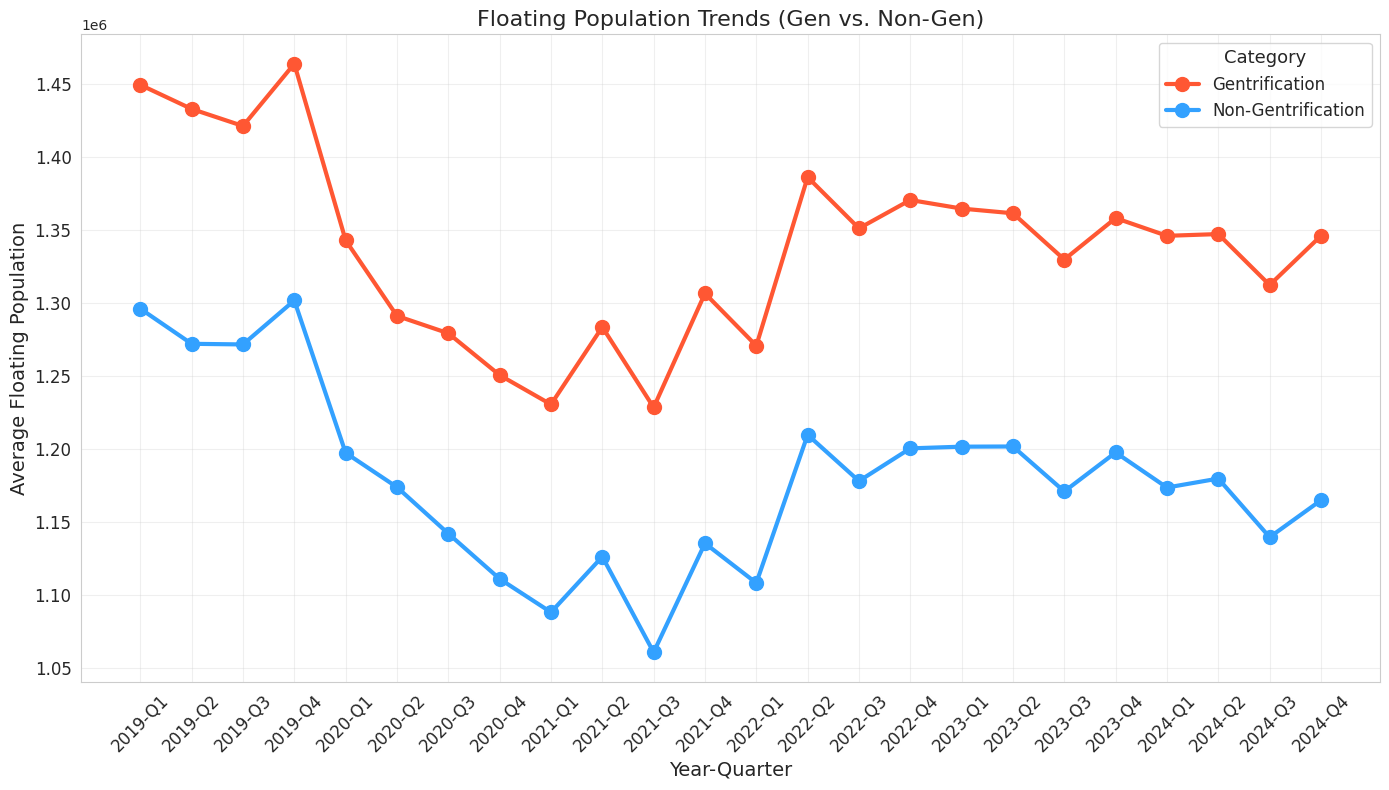

In [39]:
# 데이터 타입 변환
df_dong_floating_total['총_유동인구_수'] = pd.to_numeric(df_dong_floating_total['총_유동인구_수'], errors='coerce')

# 연도_분기 컬럼 변환
df_dong_floating_total['연도_분기_라벨'] = df_dong_floating_total['연도_분기'].astype(str).apply(lambda x: f"{x[:4]}-Q{x[4:]}" if len(x) >= 5 else x)

# 시계열 데이터
time_series_data = df_dong_floating_total.groupby(['연도_분기', '연도_분기_라벨', '구분'])['총_유동인구_수'].mean().reset_index()
time_series_data = time_series_data.sort_values('연도_분기')

# 젠트리피케이션, 비젠트리피케이션 데이터 분리
gen_data = time_series_data[time_series_data['구분'] == '젠트리피케이션']
non_gen_data = time_series_data[time_series_data['구분'] == '비젠트리피케이션']

plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")

# 선 그래프 그리기
line1, = plt.plot(gen_data['연도_분기_라벨'], gen_data['총_유동인구_수'], 'o-', color='#FF5733', linewidth=3, markersize=10)
line2, = plt.plot(non_gen_data['연도_분기_라벨'], non_gen_data['총_유동인구_수'], 'o-', color='#33A1FF', linewidth=3, markersize=10)

# 그래프 스타일 설정
plt.title('Floating Population Trends (Gen vs. Non-Gen)', fontsize=16)
plt.xlabel('Year-Quarter', fontsize=14)
plt.ylabel('Average Floating Population', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend([line1, line2], ['Gentrification', 'Non-Gentrification'], title='Category', fontsize=12, title_fontsize=13)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

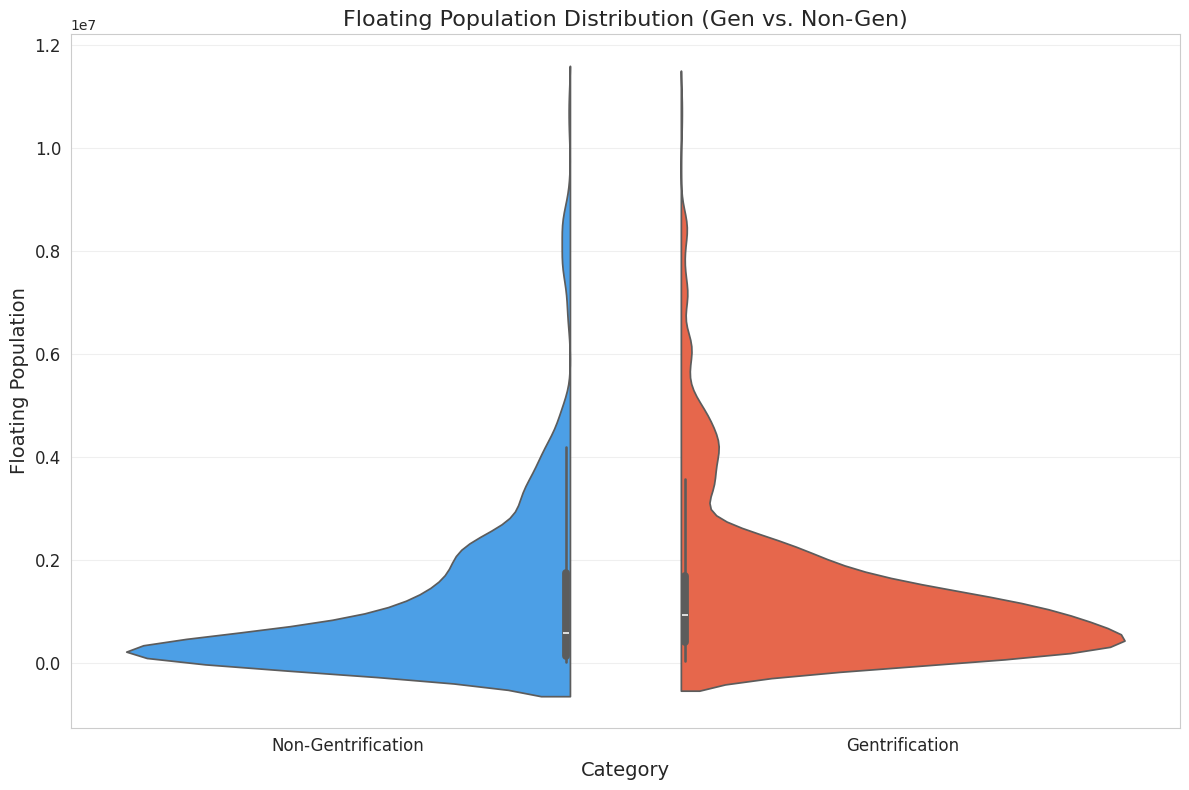

In [40]:
# 바이올린 플롯
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

# 분할된 바이올린 플롯 데이터 준비
violin_data = df_dong_floating_total.copy()
violin_data['Category'] = violin_data['구분'].map({
    '젠트리피케이션': 'Gentrification',
    '비젠트리피케이션': 'Non-Gentrification'
})

# 데이터 타입 변환 확인
violin_data['총_유동인구_수'] = pd.to_numeric(violin_data['총_유동인구_수'], errors='coerce')
violin_data = violin_data.dropna(subset=['총_유동인구_수'])

# 바이올린 플롯 그리기
ax = sns.violinplot(
    x='Category',
    y='총_유동인구_수',
    hue='Category',
    data=violin_data,
    palette={'Gentrification': '#FF5733', 'Non-Gentrification': '#33A1FF'},
    inner='box',
    split=True
)

plt.title('Floating Population Distribution (Gen vs. Non-Gen)', fontsize=16)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Floating Population', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

### 상권 유동인구 (성별)

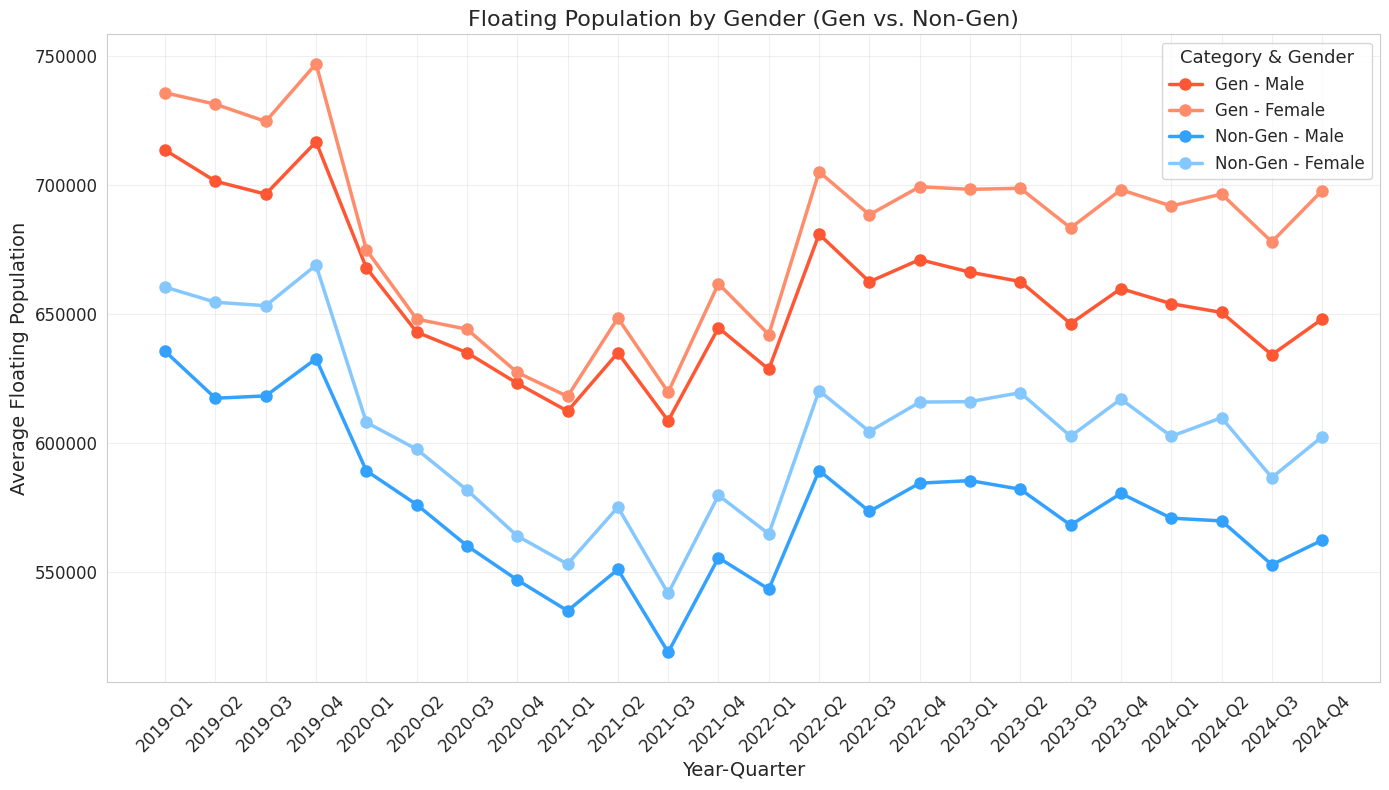

In [41]:
# 데이터 타입 변환
df_dong_floating_sex['남성_유동인구_수'] = pd.to_numeric(df_dong_floating_sex['남성_유동인구_수'], errors='coerce')
df_dong_floating_sex['여성_유동인구_수'] = pd.to_numeric(df_dong_floating_sex['여성_유동인구_수'], errors='coerce')

# 연도_분기 컬럼 변환
df_dong_floating_sex['연도_분기_라벨'] = df_dong_floating_sex['연도_분기'].astype(str).apply(lambda x: f"{x[:4]}-Q{x[4:]}" if len(x) >= 5 else x)

# 시계열 데이터
gender_time_series = df_dong_floating_sex.groupby(['연도_분기', '연도_분기_라벨', '구분']).agg({'남성_유동인구_수': 'mean', '여성_유동인구_수': 'mean'}).reset_index()
gender_time_series = gender_time_series.sort_values('연도_분기')

# 젠트리피케이션, 비젠트리피케이션 데이터 분리
gen_gender_data = gender_time_series[gender_time_series['구분'] == '젠트리피케이션']
non_gen_gender_data = gender_time_series[gender_time_series['구분'] == '비젠트리피케이션']

plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")

# 젠트리피케이션 지역의 남성/여성 유동인구
plt.plot(gen_gender_data['연도_분기_라벨'], gen_gender_data['남성_유동인구_수'], 'o-', color='#FF5733', linewidth=2.5, markersize=8, label='Gen - Male')
plt.plot(gen_gender_data['연도_분기_라벨'], gen_gender_data['여성_유동인구_수'], 'o-', color='#FF8C6B', linewidth=2.5, markersize=8, label='Gen - Female')

# 비젠트리피케이션 지역의 남성/여성 유동인구
plt.plot(non_gen_gender_data['연도_분기_라벨'], non_gen_gender_data['남성_유동인구_수'], 'o-', color='#33A1FF', linewidth=2.5, markersize=8, label='Non-Gen - Male')
plt.plot(non_gen_gender_data['연도_분기_라벨'], non_gen_gender_data['여성_유동인구_수'], 'o-', color='#85C7FF', linewidth=2.5, markersize=8, label='Non-Gen - Female')

# 그래프 스타일 설정
plt.title('Floating Population by Gender (Gen vs. Non-Gen)', fontsize=16)
plt.xlabel('Year-Quarter', fontsize=14)
plt.ylabel('Average Floating Population', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Category & Gender', fontsize=12, title_fontsize=13)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

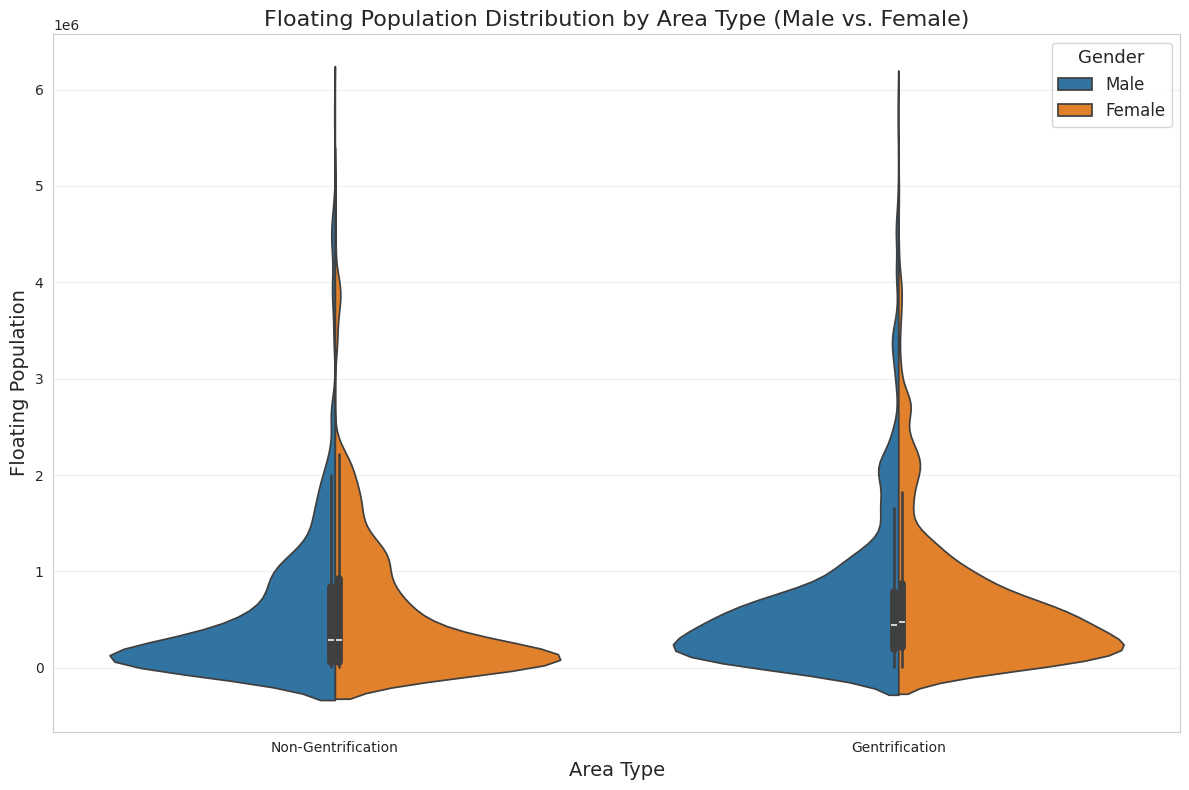

In [42]:
# 데이터 멜팅
violin_sex_data = pd.melt(
    df_dong_floating_sex,
    id_vars=['구분', '상권', '연도_분기'],
    value_vars=['남성_유동인구_수', '여성_유동인구_수'],
    var_name='성별',
    value_name='유동인구_수'
)

# 성별 레이블 변환
violin_sex_data['Gender'] = violin_sex_data['성별'].map({
    '남성_유동인구_수': 'Male',
    '여성_유동인구_수': 'Female'
})

# 구분 레이블 변환
violin_sex_data['Category'] = violin_sex_data['구분'].map({
    '젠트리피케이션': 'Gentrification',
    '비젠트리피케이션': 'Non-Gentrification'
})

plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

# X축이 Category(젠/비젠), hue가 Gender(남/여)인 분할된 바이올린 플롯 생성
ax = sns.violinplot(
    x='Category',  # X축을 젠/비젠으로 설정
    y='유동인구_수',
    hue='Gender',  # 남/여를 hue로 설정하여 분할
    data=violin_sex_data,
    palette={'Male': '#1F77B4', 'Female': '#FF7F0E'},
    split=True,    # 분할 활성화
    inner='box',
    density_norm='width'
)

plt.title('Floating Population Distribution by Area Type (Male vs. Female)', fontsize=16)
plt.xlabel('Area Type', fontsize=14)
plt.ylabel('Floating Population', fontsize=14)
plt.legend(title='Gender', fontsize=12, title_fontsize=13)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

### 상권 유동인구 (연령대)

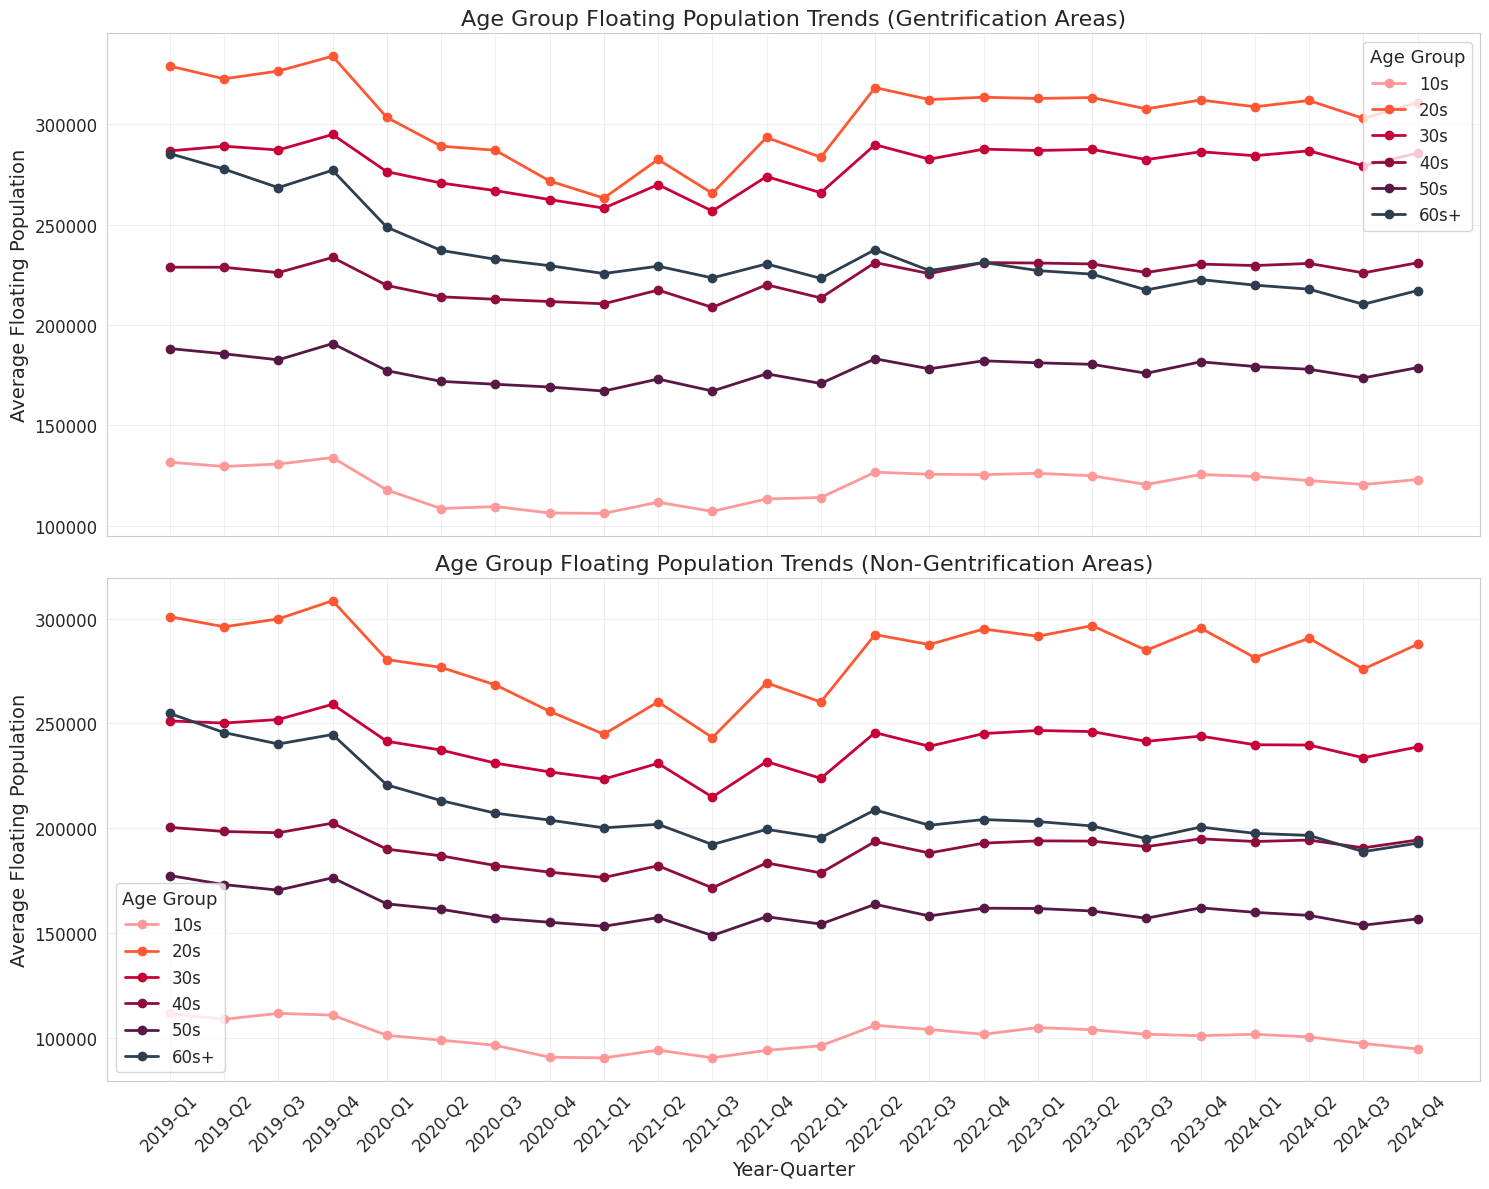

In [43]:
# 연령대 레이블 정의
age_labels = {
    "연령대_10_유동인구_수": "10s",
    "연령대_20_유동인구_수": "20s",
    "연령대_30_유동인구_수": "30s",
    "연령대_40_유동인구_수": "40s",
    "연령대_50_유동인구_수": "50s",
    "연령대_60_이상_유동인구_수": "60s+"
}

# 데이터 타입 변환
age_columns = [
    "연령대_10_유동인구_수", "연령대_20_유동인구_수", "연령대_30_유동인구_수",
    "연령대_40_유동인구_수", "연령대_50_유동인구_수", "연령대_60_이상_유동인구_수"
]

for col in age_columns:
  df_dong_floating_age[col] = pd.to_numeric(df_dong_floating_age[col], errors='coerce')

# 연도_분기 컬럼 변환
df_dong_floating_age['연도_분기_라벨'] = df_dong_floating_age['연도_분기'].astype(str).apply(
    lambda x: f"{x[:4]}-Q{x[4:]}" if len(x) >= 5 else x
)

# 3.1 시계열 라인 플롯
# 연령대별 시계열 데이터 준비
age_time_series = df_dong_floating_age.groupby(['연도_분기', '연도_분기_라벨', '구분']).agg({
    col: 'mean' for col in age_columns
}).reset_index()

age_time_series = age_time_series.sort_values('연도_분기')

# 젠트리피케이션, 비젠트리피케이션 데이터 분리
gen_age_data = age_time_series[age_time_series['구분'] == '젠트리피케이션']
non_gen_age_data = age_time_series[age_time_series['구분'] == '비젠트리피케이션']

# 연령대별 색상 지정
age_colors = {
    "연령대_10_유동인구_수": "#FF9999",
    "연령대_20_유동인구_수": "#FF5733",
    "연령대_30_유동인구_수": "#C70039",
    "연령대_40_유동인구_수": "#900C3F",
    "연령대_50_유동인구_수": "#581845",
    "연령대_60_이상_유동인구_수": "#2C3E50"
}

# 두 개의 서브플롯 생성
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), sharex=True)

# 젠트리피케이션 지역의 연령대별 유동인구 시계열 그래프
for col in age_columns:
    ax1.plot(gen_age_data['연도_분기_라벨'], gen_age_data[col], 'o-', color=age_colors[col], linewidth=2, markersize=6, label=age_labels[col])

ax1.set_title('Age Group Floating Population Trends (Gentrification Areas)', fontsize=16)
ax1.set_ylabel('Average Floating Population', fontsize=14)
ax1.tick_params(axis='y', labelsize=12)
ax1.grid(True, alpha=0.3)
ax1.legend(title='Age Group', fontsize=12, title_fontsize=13)

# 비젠트리피케이션 지역의 연령대별 유동인구 시계열 그래프
for col in age_columns:
    ax2.plot(non_gen_age_data['연도_분기_라벨'], non_gen_age_data[col], 'o-', color=age_colors[col], linewidth=2, markersize=6, label=age_labels[col])

ax2.set_title('Age Group Floating Population Trends (Non-Gentrification Areas)', fontsize=16)
ax2.set_xlabel('Year-Quarter', fontsize=14)
ax2.set_ylabel('Average Floating Population', fontsize=14)
ax2.tick_params(axis='x', rotation=45, labelsize=12)
ax2.tick_params(axis='y', labelsize=12)
ax2.grid(True, alpha=0.3)
ax2.legend(title='Age Group', fontsize=12, title_fontsize=13)

plt.tight_layout()
plt.show()

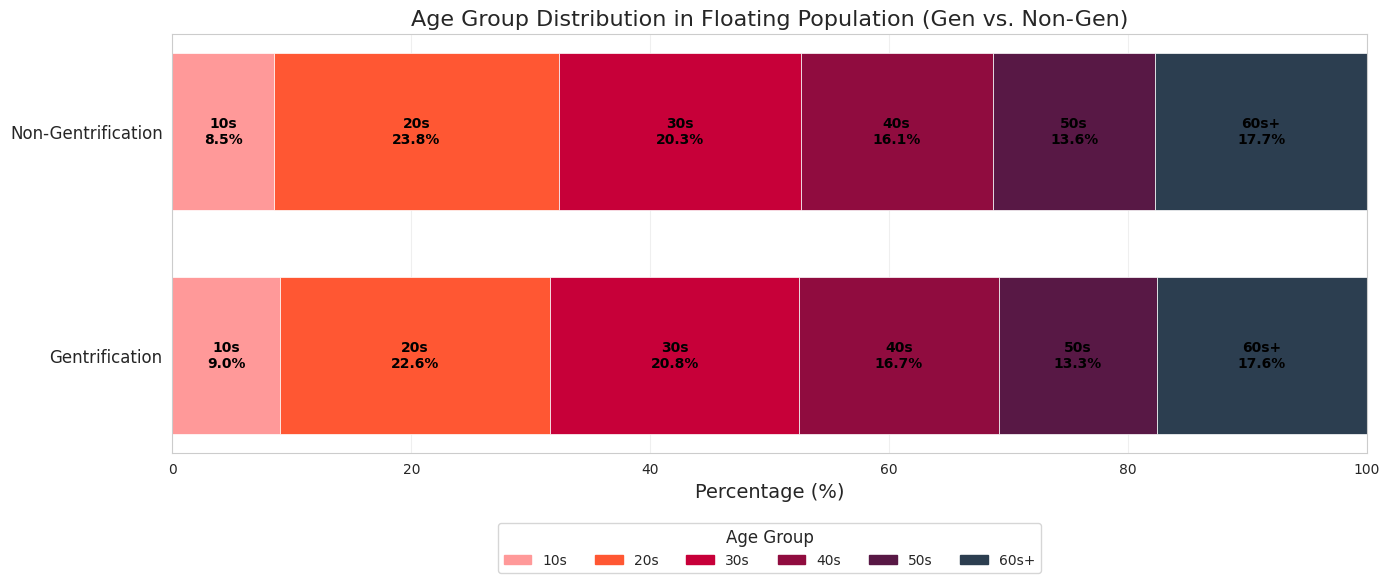

In [44]:
# 연령대 레이블 정의 (유동인구용)
age_labels = {
    "연령대_10_유동인구_수": "10s",
    "연령대_20_유동인구_수": "20s",
    "연령대_30_유동인구_수": "30s",
    "연령대_40_유동인구_수": "40s",
    "연령대_50_유동인구_수": "50s",
    "연령대_60_이상_유동인구_수": "60s+"
}

# 데이터 타입 변환 (유동인구용)
age_columns = [
    "연령대_10_유동인구_수", "연령대_20_유동인구_수", "연령대_30_유동인구_수",
    "연령대_40_유동인구_수", "연령대_50_유동인구_수", "연령대_60_이상_유동인구_수"
]

# 젠트리피케이션과 비젠트리피케이션 지역별로 연령대 비율 계산
# 먼저 각 구분별, 연령대별 평균 유동인구 계산
age_means = df_dong_floating_age.groupby('구분')[age_columns].mean().reset_index()

# 각 행(구분)별로 총 합계 계산하여 비율 구하기
for idx, row in age_means.iterrows():
    total = row[age_columns].sum()
    for col in age_columns:
        age_means.loc[idx, f'{col}_비율'] = row[col] / total * 100

# 데이터 재구성 (멜팅)
ratio_columns = [f'{col}_비율' for col in age_columns]
age_ratio_melted = pd.melt(
    age_means,
    id_vars=['구분'],
    value_vars=ratio_columns,
    var_name='연령대_비율',
    value_name='비율'
)

# 연령대 레이블 변환
age_ratio_melted['Age_Group'] = age_ratio_melted['연령대_비율'].apply(lambda x: age_labels[x.replace('_비율', '')])
age_ratio_melted['Category'] = age_ratio_melted['구분'].map({
    '젠트리피케이션': 'Gentrification',
    '비젠트리피케이션': 'Non-Gentrification'
})

# 연령대 순서 정의
age_order = ['10s', '20s', '30s', '40s', '50s', '60s+']

# 연령대 순서 컬럼 추가
age_ratio_melted['Age_Order'] = age_ratio_melted['Age_Group'].map({age: i for i, age in enumerate(age_order)})
age_ratio_melted = age_ratio_melted.sort_values(['구분', 'Age_Order'])

# 색상 팔레트 정의 (연령대별)
colors = ['#FF9999', '#FF5733', '#C70039', '#900C3F', '#581845', '#2C3E50']
palette = {age: color for age, color in zip(age_order, colors)}

# 가로 누적 막대 그래프 그리기
plt.figure(figsize=(14, 6))
sns.set_style("whitegrid")

# 젠트리피케이션과 비젠트리피케이션을 구분하여 그래프 생성
for i, category in enumerate(['Gentrification', 'Non-Gentrification']):
    # 해당 카테고리 데이터만 필터링
    category_data = age_ratio_melted[age_ratio_melted['Category'] == category]

    # 위치 설정 (젠트리피케이션: 0, 비젠트리피케이션: 1)
    y_pos = i

    # 누적 시작 위치
    left = 0

    # 각 연령대별로 막대 그리기
    for age in age_order:
        # 해당 연령대 데이터 찾기
        age_data = category_data[category_data['Age_Group'] == age]
        if not age_data.empty:
            width = age_data['비율'].values[0]
            plt.barh(y_pos, width, left=left, height=0.7, color=palette[age], edgecolor='white', linewidth=0.5)

            # 비율이 5% 이상인 경우에만 레이블 표시
            if width >= 5:
                # 텍스트 위치 계산 (막대 중앙)
                text_x = left + width / 2
                plt.text(text_x, y_pos, f"{age}\n{width:.1f}%", ha='center', va='center', color='black', fontsize=10, fontweight='bold')

            # 다음 막대의 시작 위치 업데이트
            left += width

# Y축 설정
plt.yticks([0, 1], ['Gentrification', 'Non-Gentrification'], fontsize=12)
plt.xlabel('Percentage (%)', fontsize=14)
plt.xlim(0, 100)
plt.title('Age Group Distribution in Floating Population (Gen vs. Non-Gen)', fontsize=16)
plt.grid(True, alpha=0.3, axis='x')

# 범례 추가
handles = [plt.Rectangle((0, 0), 1, 1, color=palette[age]) for age in age_order]
plt.legend(handles, age_order, title='Age Group', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=6, fontsize=10, title_fontsize=12)

plt.tight_layout()
plt.show()

### 상권 상주인구 (총 인구 수)

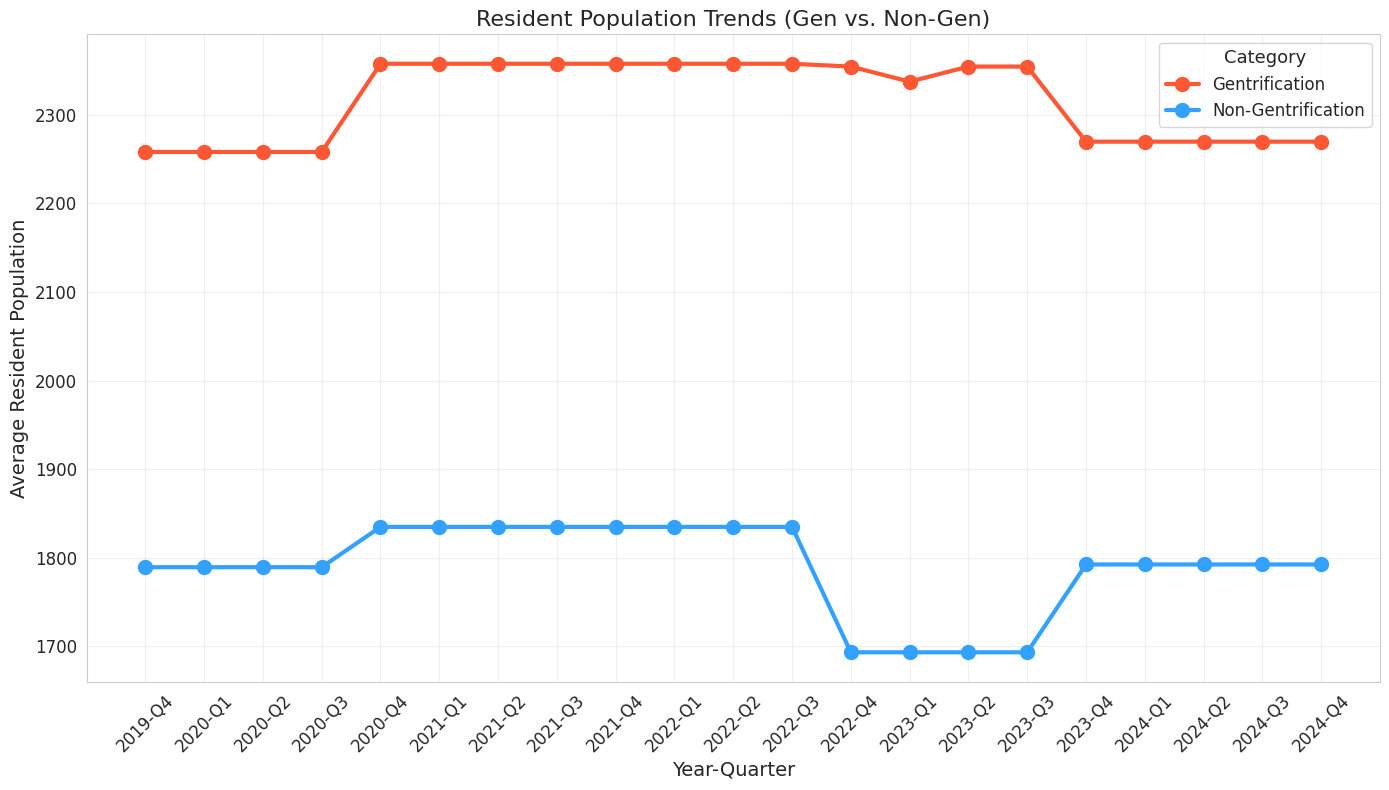

In [45]:
# 데이터 타입 변환
df_dong_resident_total['총_상주인구_수'] = pd.to_numeric(df_dong_resident_total['총_상주인구_수'], errors='coerce')

# 연도_분기 컬럼 변환
df_dong_resident_total['연도_분기_라벨'] = df_dong_resident_total['연도_분기'].astype(str).apply(lambda x: f"{x[:4]}-Q{x[4:]}" if len(x) >= 5 else x)

# 시계열 데이터
time_series_data = df_dong_resident_total.groupby(['연도_분기', '연도_분기_라벨', '구분'])['총_상주인구_수'].mean().reset_index()
time_series_data = time_series_data.sort_values('연도_분기')

# 젠트리피케이션, 비젠트리피케이션 데이터 분리
gen_data = time_series_data[time_series_data['구분'] == '젠트리피케이션']
non_gen_data = time_series_data[time_series_data['구분'] == '비젠트리피케이션']

plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")

# 선 그래프 그리기
line1, = plt.plot(gen_data['연도_분기_라벨'], gen_data['총_상주인구_수'], 'o-', color='#FF5733', linewidth=3, markersize=10)
line2, = plt.plot(non_gen_data['연도_분기_라벨'], non_gen_data['총_상주인구_수'], 'o-', color='#33A1FF', linewidth=3, markersize=10)

# 그래프 스타일 설정
plt.title('Resident Population Trends (Gen vs. Non-Gen)', fontsize=16)
plt.xlabel('Year-Quarter', fontsize=14)
plt.ylabel('Average Resident Population', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend([line1, line2], ['Gentrification', 'Non-Gentrification'], title='Category', fontsize=12, title_fontsize=13)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

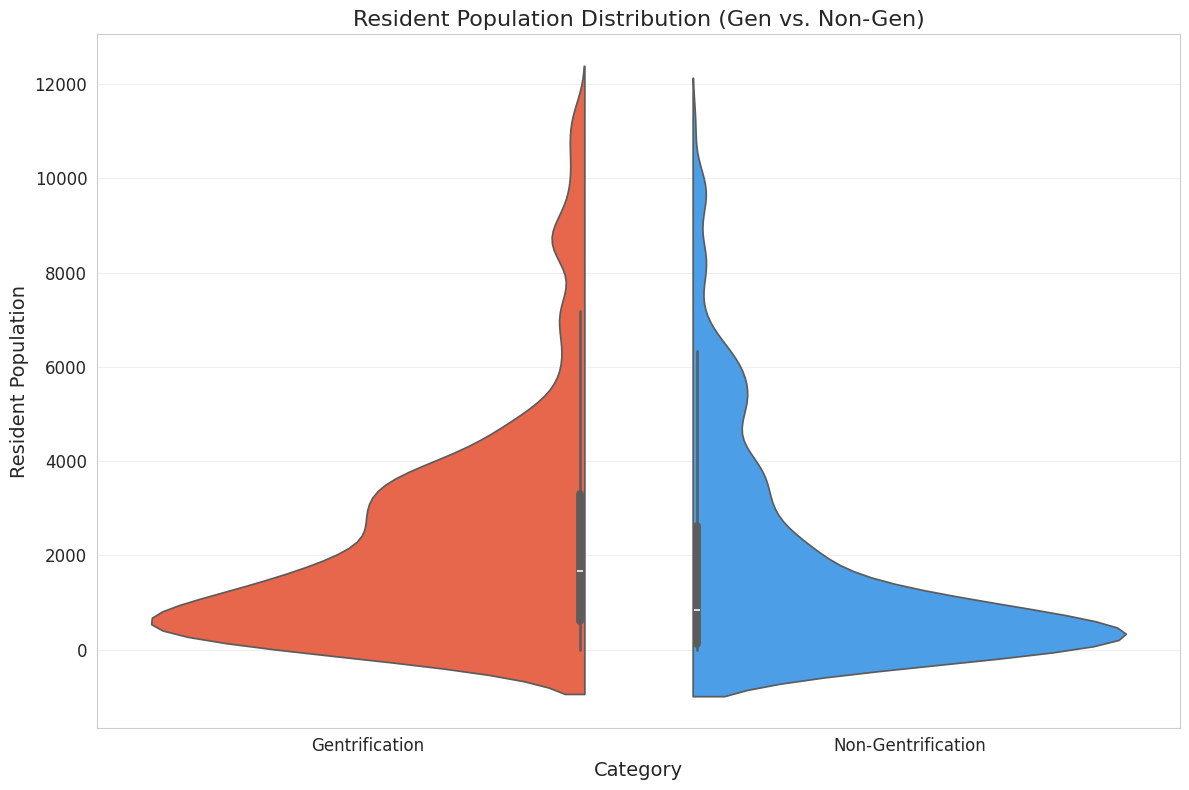

In [46]:
# 바이올린 플롯
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

# 분할된 바이올린 플롯 데이터 준비
violin_data = df_dong_resident_total.copy()
violin_data['Category'] = violin_data['구분'].map({
    '젠트리피케이션': 'Gentrification',
    '비젠트리피케이션': 'Non-Gentrification'
})

# 바이올린 플롯 그리기
ax = sns.violinplot(
    x='Category',
    y='총_상주인구_수',
    hue='Category',
    data=violin_data,
    palette={'Gentrification': '#FF5733', 'Non-Gentrification': '#33A1FF'},
    inner='box',
    density_norm='width',
    split=True
)

plt.title('Resident Population Distribution (Gen vs. Non-Gen)', fontsize=16)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Resident Population', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

### 상권 상주인구 (성별)

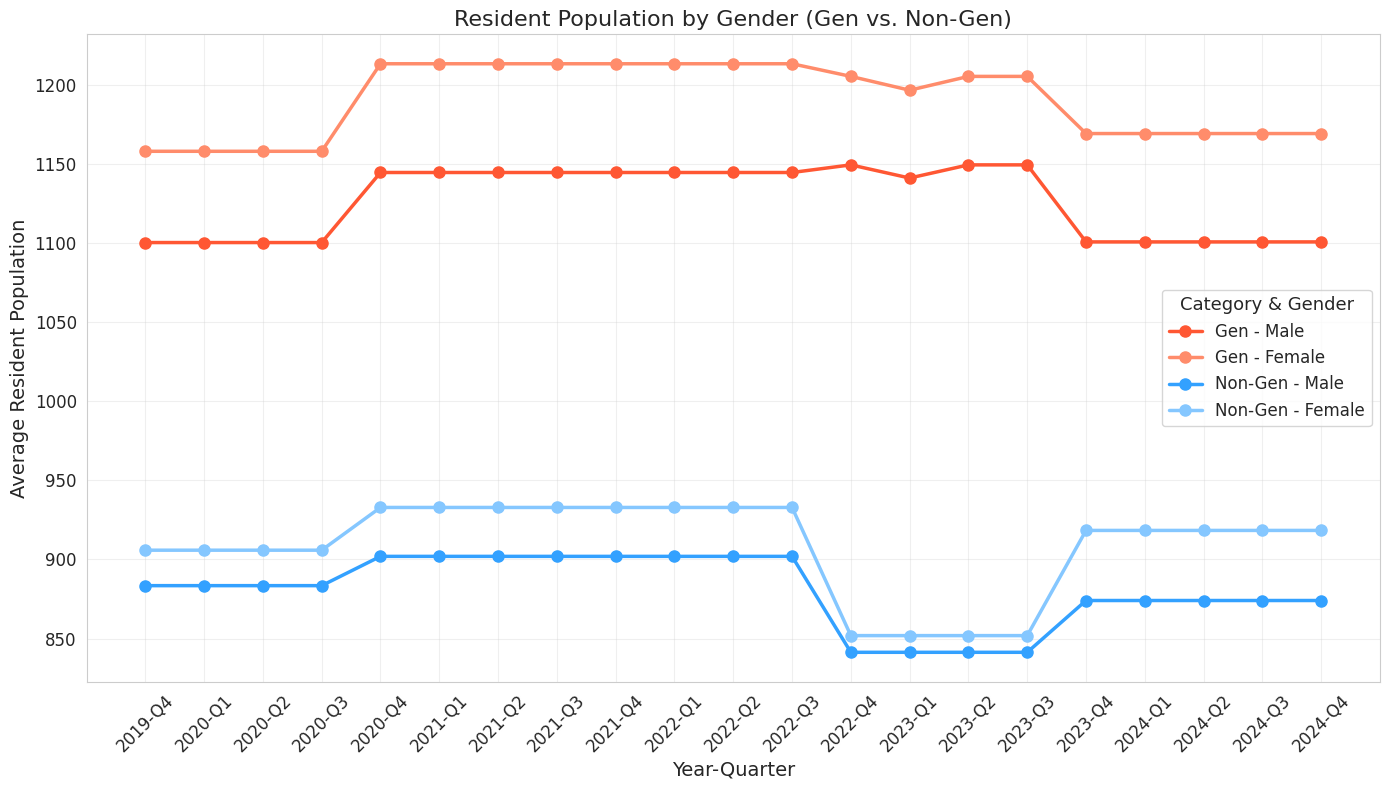

In [47]:
# 데이터 타입 변환
df_dong_resident_sex['남성_상주인구_수'] = pd.to_numeric(df_dong_resident_sex['남성_상주인구_수'], errors='coerce')
df_dong_resident_sex['여성_상주인구_수'] = pd.to_numeric(df_dong_resident_sex['여성_상주인구_수'], errors='coerce')

# 연도_분기 컬럼 변환
df_dong_resident_sex['연도_분기_라벨'] = df_dong_resident_sex['연도_분기'].astype(str).apply(lambda x: f"{x[:4]}-Q{x[4:]}" if len(x) >= 5 else x)

# 시계열 데이터
gender_time_series = df_dong_resident_sex.groupby(['연도_분기', '연도_분기_라벨', '구분']).agg({'남성_상주인구_수': 'mean', '여성_상주인구_수': 'mean'}).reset_index()
gender_time_series = gender_time_series.sort_values('연도_분기')

# 젠트리피케이션, 비젠트리피케이션 데이터 분리
gen_gender_data = gender_time_series[gender_time_series['구분'] == '젠트리피케이션']
non_gen_gender_data = gender_time_series[gender_time_series['구분'] == '비젠트리피케이션']

plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")

# 젠트리피케이션 지역의 남성/여성 상주인구
plt.plot(gen_gender_data['연도_분기_라벨'], gen_gender_data['남성_상주인구_수'], 'o-', color='#FF5733', linewidth=2.5, markersize=8, label='Gen - Male')
plt.plot(gen_gender_data['연도_분기_라벨'], gen_gender_data['여성_상주인구_수'], 'o-', color='#FF8C6B', linewidth=2.5, markersize=8, label='Gen - Female')

# 비젠트리피케이션 지역의 남성/여성 상주인구
plt.plot(non_gen_gender_data['연도_분기_라벨'], non_gen_gender_data['남성_상주인구_수'], 'o-', color='#33A1FF', linewidth=2.5, markersize=8, label='Non-Gen - Male')
plt.plot(non_gen_gender_data['연도_분기_라벨'], non_gen_gender_data['여성_상주인구_수'], 'o-', color='#85C7FF', linewidth=2.5, markersize=8, label='Non-Gen - Female')

# 그래프 스타일 설정
plt.title('Resident Population by Gender (Gen vs. Non-Gen)', fontsize=16)
plt.xlabel('Year-Quarter', fontsize=14)
plt.ylabel('Average Resident Population', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Category & Gender', fontsize=12, title_fontsize=13)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

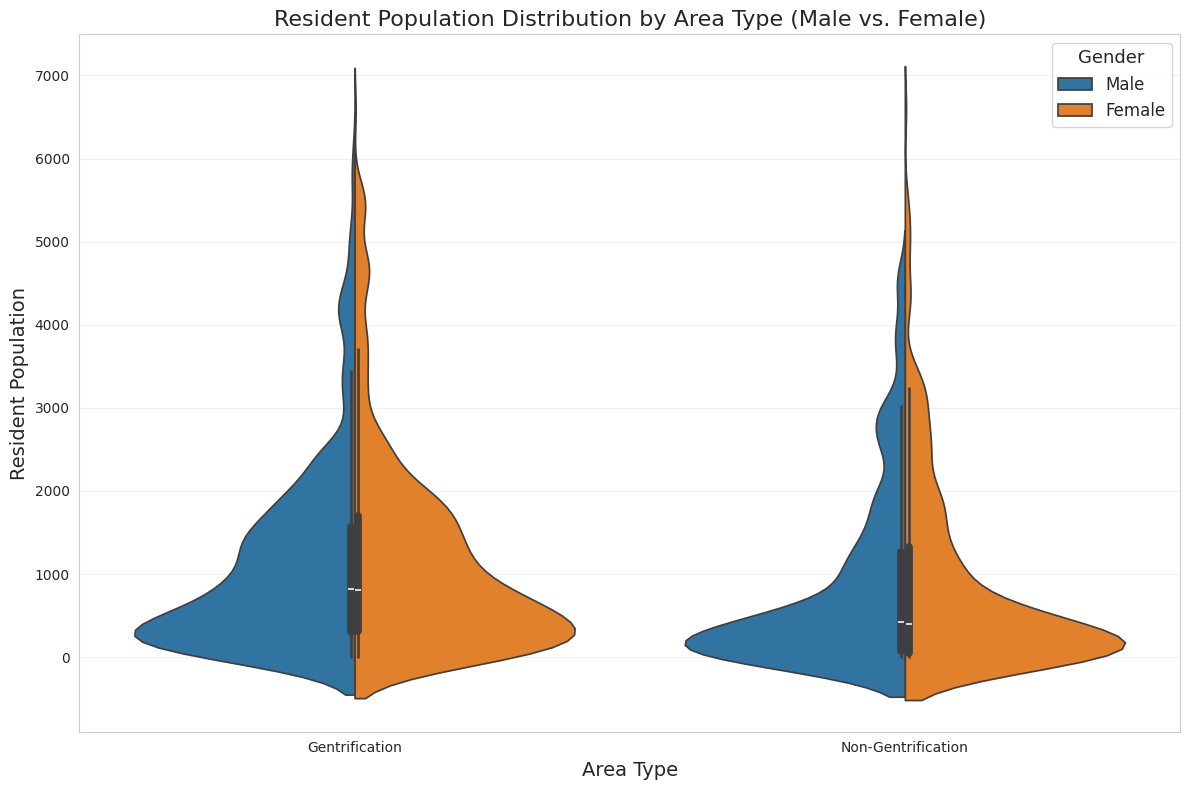

In [48]:
# 데이터 멜팅
violin_sex_data = pd.melt(
    df_dong_resident_sex,
    id_vars=['구분', '상권', '연도_분기'],
    value_vars=['남성_상주인구_수', '여성_상주인구_수'],
    var_name='성별',
    value_name='상주인구_수'
)

# 성별 레이블 변환
violin_sex_data['Gender'] = violin_sex_data['성별'].map({
    '남성_상주인구_수': 'Male',
    '여성_상주인구_수': 'Female'
})

# 구분 레이블 변환
violin_sex_data['Category'] = violin_sex_data['구분'].map({
    '젠트리피케이션': 'Gentrification',
    '비젠트리피케이션': 'Non-Gentrification'
})

plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

# X축이 Category(젠/비젠), hue가 Gender(남/여)인 분할된 바이올린 플롯 생성
ax = sns.violinplot(
    x='Category',  # X축을 젠/비젠으로 설정
    y='상주인구_수',
    hue='Gender',  # 남/여를 hue로 설정하여 분할
    data=violin_sex_data,
    palette={'Male': '#1F77B4', 'Female': '#FF7F0E'},
    split=True,    # 분할 활성화
    inner='box',
    density_norm='width'
)

plt.title('Resident Population Distribution by Area Type (Male vs. Female)', fontsize=16)
plt.xlabel('Area Type', fontsize=14)
plt.ylabel('Resident Population', fontsize=14)
plt.legend(title='Gender', fontsize=12, title_fontsize=13)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

### 상권 상주인구 (연령대)

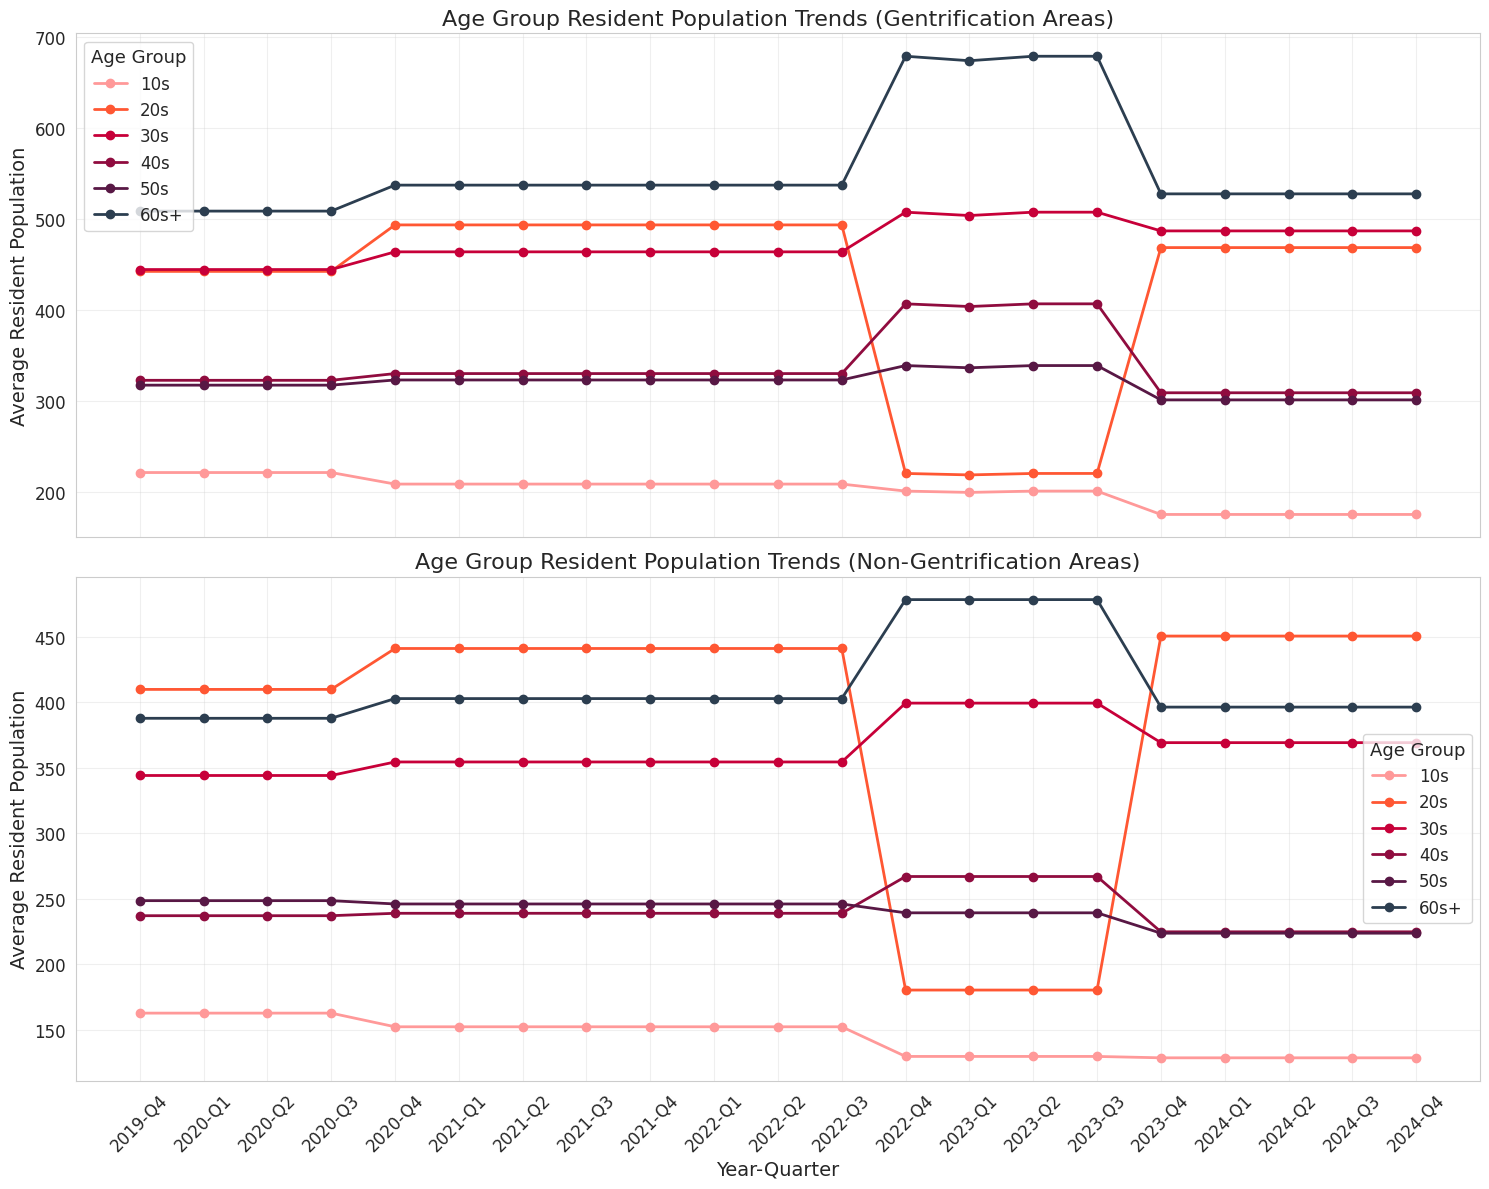

In [49]:
# 연령대 레이블 정의
age_labels = {
    "연령대_10_상주인구_수": "10s",
    "연령대_20_상주인구_수": "20s",
    "연령대_30_상주인구_수": "30s",
    "연령대_40_상주인구_수": "40s",
    "연령대_50_상주인구_수": "50s",
    "연령대_60_이상_상주인구_수": "60s+"
}

# 데이터 타입 변환
age_columns = [
    "연령대_10_상주인구_수", "연령대_20_상주인구_수", "연령대_30_상주인구_수",
    "연령대_40_상주인구_수", "연령대_50_상주인구_수", "연령대_60_이상_상주인구_수"
]

for col in age_columns:
  df_dong_resident_age[col] = pd.to_numeric(df_dong_resident_age[col], errors='coerce')

# 연도_분기 컬럼 변환
df_dong_resident_age['연도_분기_라벨'] = df_dong_resident_age['연도_분기'].astype(str).apply(
    lambda x: f"{x[:4]}-Q{x[4:]}" if len(x) >= 5 else x
)

# 3.1 시계열 라인 플롯
# 연령대별 시계열 데이터 준비
age_time_series = df_dong_resident_age.groupby(['연도_분기', '연도_분기_라벨', '구분']).agg({
    col: 'mean' for col in age_columns
}).reset_index()

age_time_series = age_time_series.sort_values('연도_분기')

# 젠트리피케이션, 비젠트리피케이션 데이터 분리
gen_age_data = age_time_series[age_time_series['구분'] == '젠트리피케이션']
non_gen_age_data = age_time_series[age_time_series['구분'] == '비젠트리피케이션']

# 연령대별 색상 지정
age_colors = {
    "연령대_10_상주인구_수": "#FF9999",
    "연령대_20_상주인구_수": "#FF5733",
    "연령대_30_상주인구_수": "#C70039",
    "연령대_40_상주인구_수": "#900C3F",
    "연령대_50_상주인구_수": "#581845",
    "연령대_60_이상_상주인구_수": "#2C3E50"
}

# 두 개의 서브플롯 생성
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), sharex=True)

# 젠트리피케이션 지역의 연령대별 상주인구 시계열 그래프
for col in age_columns:
    ax1.plot(gen_age_data['연도_분기_라벨'], gen_age_data[col], 'o-',
             color=age_colors[col], linewidth=2, markersize=6, label=age_labels[col])

ax1.set_title('Age Group Resident Population Trends (Gentrification Areas)', fontsize=16)
ax1.set_ylabel('Average Resident Population', fontsize=14)
ax1.tick_params(axis='y', labelsize=12)
ax1.grid(True, alpha=0.3)
ax1.legend(title='Age Group', fontsize=12, title_fontsize=13)

# 비젠트리피케이션 지역의 연령대별 상주인구 시계열 그래프
for col in age_columns:
    ax2.plot(non_gen_age_data['연도_분기_라벨'], non_gen_age_data[col], 'o-',
             color=age_colors[col], linewidth=2, markersize=6, label=age_labels[col])

ax2.set_title('Age Group Resident Population Trends (Non-Gentrification Areas)', fontsize=16)
ax2.set_xlabel('Year-Quarter', fontsize=14)
ax2.set_ylabel('Average Resident Population', fontsize=14)
ax2.tick_params(axis='x', rotation=45, labelsize=12)
ax2.tick_params(axis='y', labelsize=12)
ax2.grid(True, alpha=0.3)
ax2.legend(title='Age Group', fontsize=12, title_fontsize=13)

plt.tight_layout()
plt.show()

In [85]:
# 20224부터 20233까지의 연도_분기 필터링
filtered_data = df_dong_resident_age[
    (df_dong_resident_age['연도_분기'] >= '20224') &
    (df_dong_resident_age['연도_분기'] <= '20233')
]

# 연도_분기와 연령대_20대_상주인구_수 열만 선택
result = filtered_data[['연도_분기', '연령대_20_상주인구_수']]

# 결과 출력
result.describe()

연령대_20_상주인구_수
count     909.000000
mean      204.259626
std       228.368362
min         0.000000
25%        30.000000
50%       117.000000
75%       316.000000
max      1151.000000

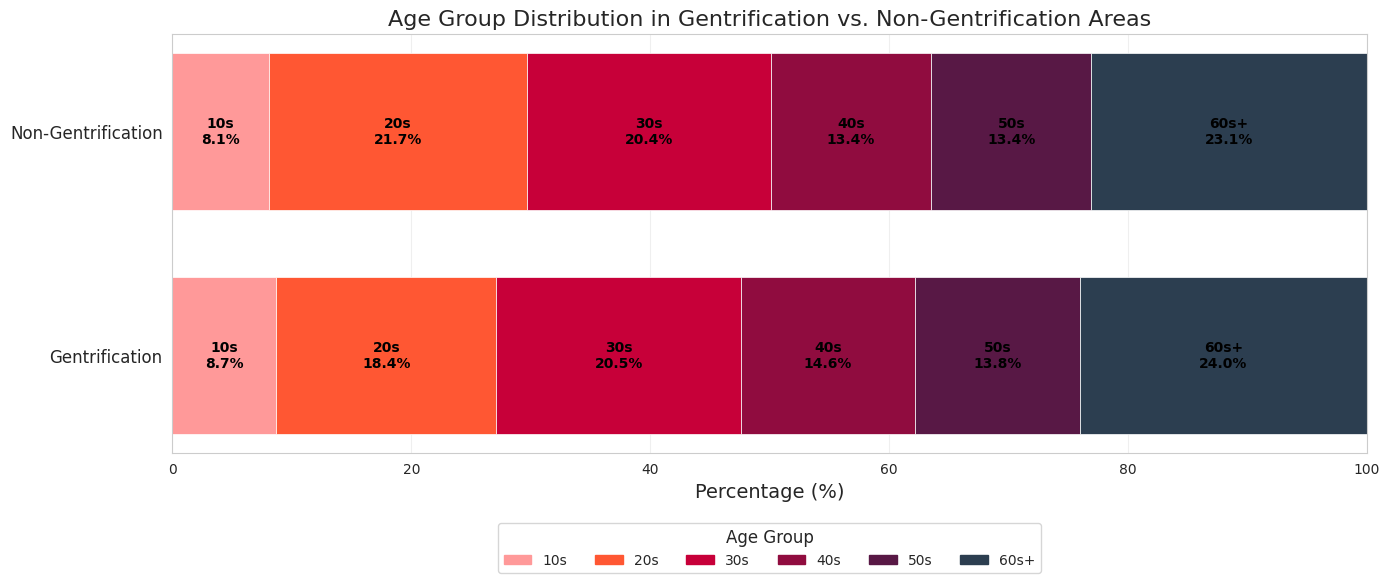

In [50]:
# 젠트리피케이션과 비젠트리피케이션 지역별로 연령대 비율 계산
# 먼저 각 구분별, 연령대별 평균 상주인구 계산
age_means = df_dong_resident_age.groupby('구분')[age_columns].mean().reset_index()

# 각 행(구분)별로 총 합계 계산하여 비율 구하기
for idx, row in age_means.iterrows():
    total = row[age_columns].sum()
    for col in age_columns:
        age_means.loc[idx, f'{col}_비율'] = row[col] / total * 100

# 데이터 재구성 (멜팅)
ratio_columns = [f'{col}_비율' for col in age_columns]
age_ratio_melted = pd.melt(
    age_means,
    id_vars=['구분'],
    value_vars=ratio_columns,
    var_name='연령대_비율',
    value_name='비율'
)

# 연령대 레이블 변환
age_ratio_melted['Age_Group'] = age_ratio_melted['연령대_비율'].apply(lambda x: age_labels[x.replace('_비율', '')])
age_ratio_melted['Category'] = age_ratio_melted['구분'].map({
    '젠트리피케이션': 'Gentrification',
    '비젠트리피케이션': 'Non-Gentrification'
})

# 연령대 순서 정의
age_order = ['10s', '20s', '30s', '40s', '50s', '60s+']

# 연령대 순서 컬럼 추가
age_ratio_melted['Age_Order'] = age_ratio_melted['Age_Group'].map({age: i for i, age in enumerate(age_order)})
age_ratio_melted = age_ratio_melted.sort_values(['구분', 'Age_Order'])

# 색상 팔레트 정의 (연령대별)
colors = ['#FF9999', '#FF5733', '#C70039', '#900C3F', '#581845', '#2C3E50']
palette = {age: color for age, color in zip(age_order, colors)}

# 가로 누적 막대 그래프 그리기
plt.figure(figsize=(14, 6))
sns.set_style("whitegrid")

# 젠트리피케이션과 비젠트리피케이션을 구분하여 그래프 생성
for i, category in enumerate(['Gentrification', 'Non-Gentrification']):
    # 해당 카테고리 데이터만 필터링
    category_data = age_ratio_melted[age_ratio_melted['Category'] == category]

    # 위치 설정 (젠트리피케이션: 0, 비젠트리피케이션: 1)
    y_pos = i

    # 누적 시작 위치
    left = 0

    # 각 연령대별로 막대 그리기
    for age in age_order:
        # 해당 연령대 데이터 찾기
        age_data = category_data[category_data['Age_Group'] == age]
        if not age_data.empty:
            width = age_data['비율'].values[0]
            plt.barh(y_pos, width, left=left, height=0.7, color=palette[age], edgecolor='white', linewidth=0.5)

            # 비율이 5% 이상인 경우에만 레이블 표시
            if width >= 5:
                # 텍스트 위치 계산 (막대 중앙)
                text_x = left + width / 2
                plt.text(text_x, y_pos, f"{age}\n{width:.1f}%", ha='center', va='center', color='black', fontsize=10, fontweight='bold')

            # 다음 막대의 시작 위치 업데이트
            left += width

# Y축 설정
plt.yticks([0, 1], ['Gentrification', 'Non-Gentrification'], fontsize=12)
plt.xlabel('Percentage (%)', fontsize=14)
plt.xlim(0, 100)
plt.title('Age Group Distribution in Gentrification vs. Non-Gentrification Areas', fontsize=16)
plt.grid(True, alpha=0.3, axis='x')

# 범례 추가
handles = [plt.Rectangle((0, 0), 1, 1, color=palette[age]) for age in age_order]
plt.legend(handles, age_order, title='Age Group', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=6, fontsize=10, title_fontsize=12)

plt.tight_layout()
plt.show()

### 상권 직장인구 (총 인구 수)

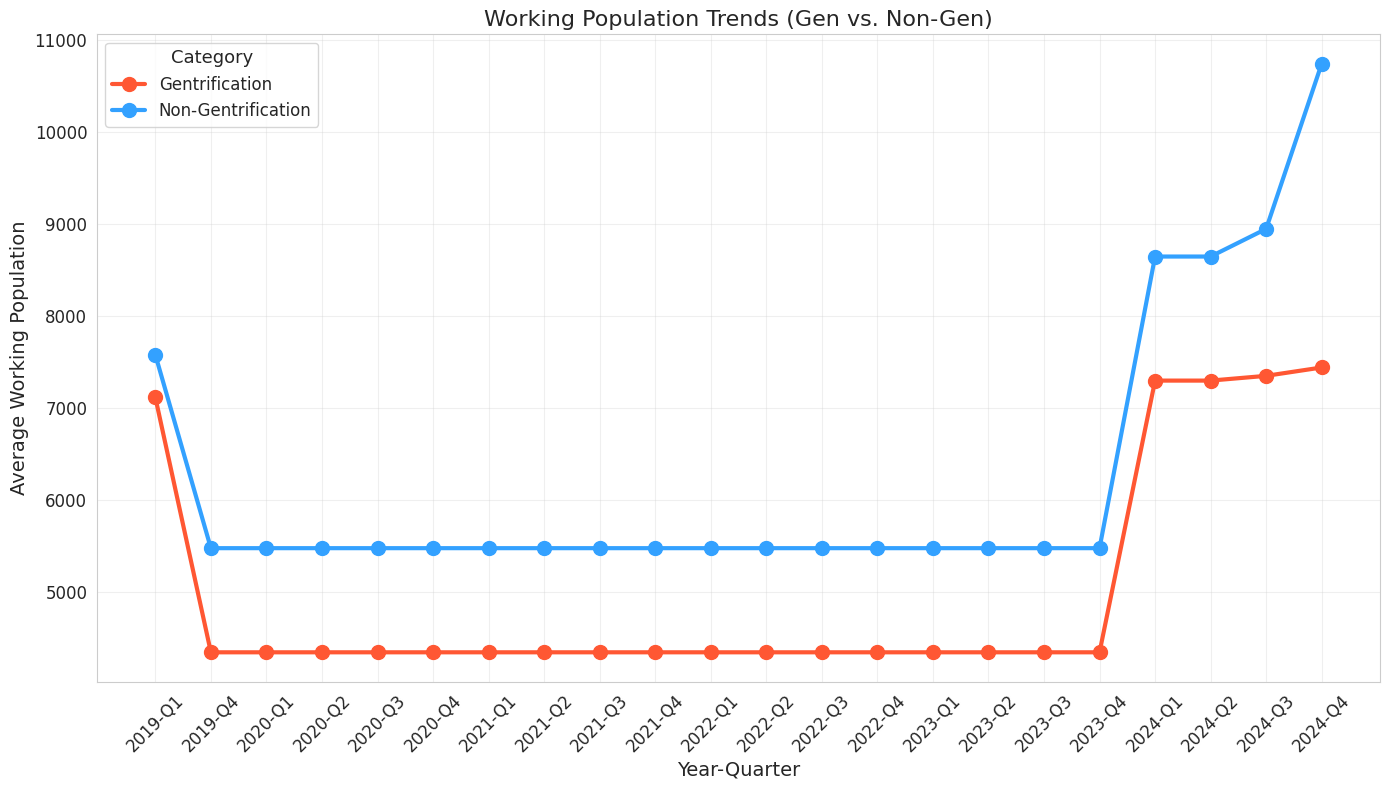

In [51]:
# 데이터 타입 변환
df_dong_working_total['총_직장인구_수'] = pd.to_numeric(df_dong_working_total['총_직장인구_수'], errors='coerce')

# 연도_분기 컬럼 변환
df_dong_working_total['연도_분기_라벨'] = df_dong_working_total['연도_분기'].astype(str).apply(lambda x: f"{x[:4]}-Q{x[4:]}" if len(x) >= 5 else x)

# 시계열 데이터
time_series_data = df_dong_working_total.groupby(['연도_분기', '연도_분기_라벨', '구분'])['총_직장인구_수'].mean().reset_index()
time_series_data = time_series_data.sort_values('연도_분기')

# 젠트리피케이션, 비젠트리피케이션 데이터 분리
gen_data = time_series_data[time_series_data['구분'] == '젠트리피케이션']
non_gen_data = time_series_data[time_series_data['구분'] == '비젠트리피케이션']

plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")

# 선 그래프 그리기
line1, = plt.plot(gen_data['연도_분기_라벨'], gen_data['총_직장인구_수'], 'o-', color='#FF5733', linewidth=3, markersize=10)
line2, = plt.plot(non_gen_data['연도_분기_라벨'], non_gen_data['총_직장인구_수'], 'o-', color='#33A1FF', linewidth=3, markersize=10)

# 그래프 스타일 설정
plt.title('Working Population Trends (Gen vs. Non-Gen)', fontsize=16)
plt.xlabel('Year-Quarter', fontsize=14)
plt.ylabel('Average Working Population', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend([line1, line2], ['Gentrification', 'Non-Gentrification'], title='Category', fontsize=12, title_fontsize=13)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

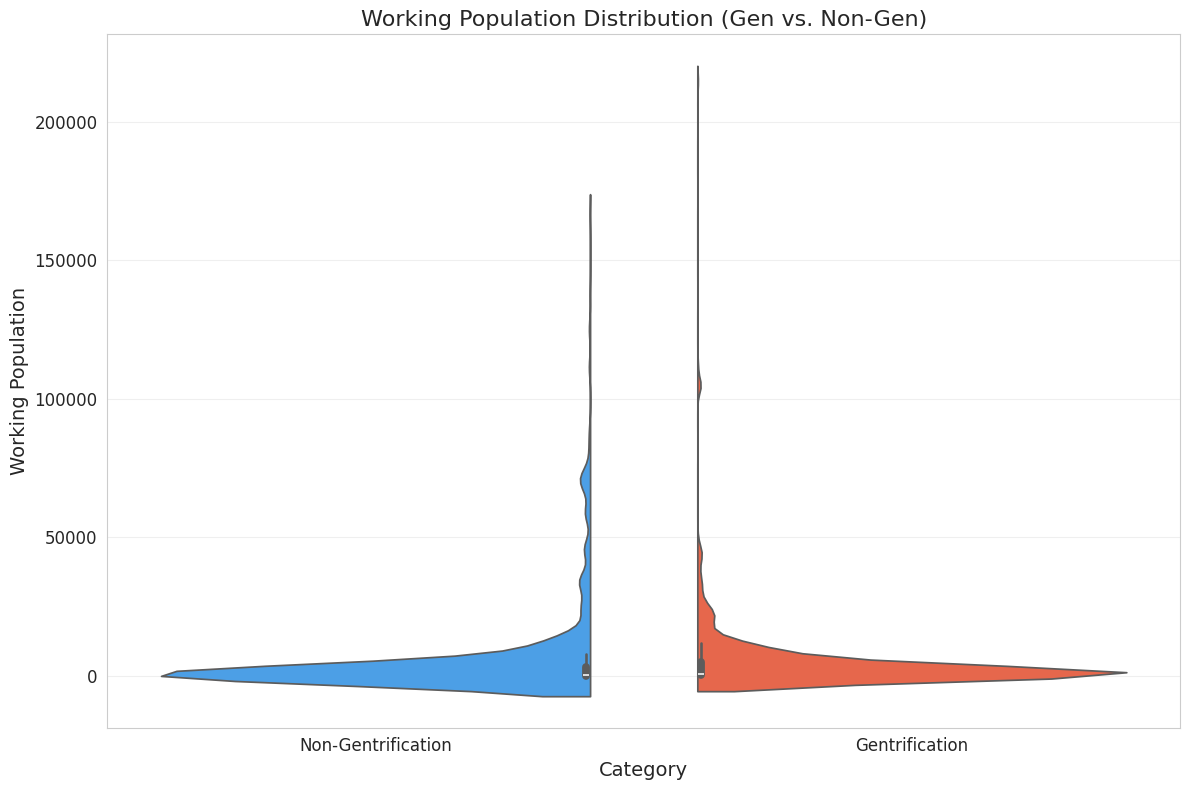

In [52]:
# 바이올린 플롯
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

# 분할된 바이올린 플롯 데이터 준비
violin_data = df_dong_working_total.copy()
violin_data['Category'] = violin_data['구분'].map({
    '젠트리피케이션': 'Gentrification',
    '비젠트리피케이션': 'Non-Gentrification'
})

# 바이올린 플롯 그리기
ax = sns.violinplot(
    x='Category',
    y='총_직장인구_수',
    hue='Category',
    data=violin_data,
    palette={'Gentrification': '#FF5733', 'Non-Gentrification': '#33A1FF'},
    inner='box',
    density_norm='width',
    split=True
)

plt.title('Working Population Distribution (Gen vs. Non-Gen)', fontsize=16)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Working Population', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

### 상권 직장인구 (성별)

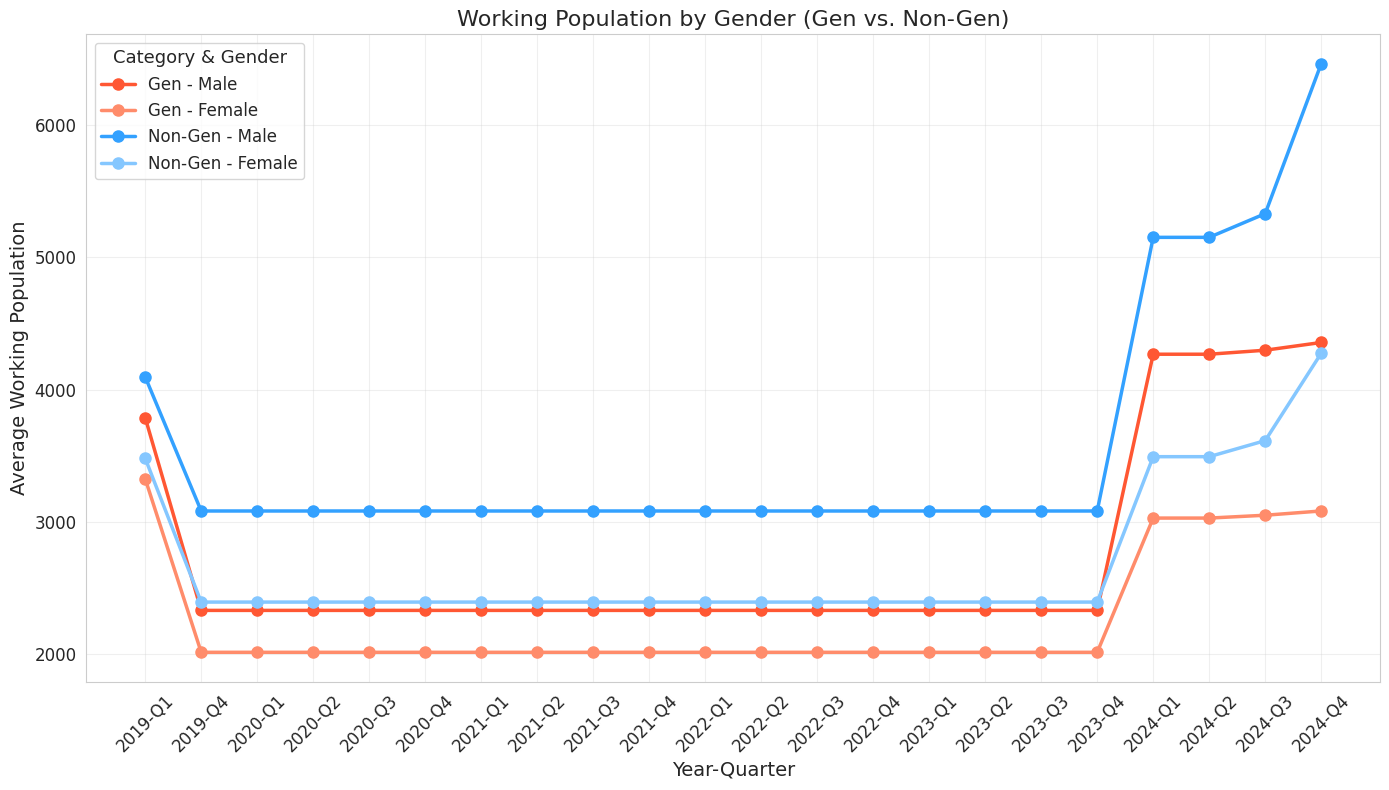

In [53]:
# 데이터 타입 변환
df_dong_working_sex['남성_직장인구_수'] = pd.to_numeric(df_dong_working_sex['남성_직장인구_수'], errors='coerce')
df_dong_working_sex['여성_직장인구_수'] = pd.to_numeric(df_dong_working_sex['여성_직장인구_수'], errors='coerce')

# 연도_분기 컬럼 변환
df_dong_working_sex['연도_분기_라벨'] = df_dong_working_sex['연도_분기'].astype(str).apply(lambda x: f"{x[:4]}-Q{x[4:]}" if len(x) >= 5 else x)

# 시계열 데이터
gender_time_series = df_dong_working_sex.groupby(['연도_분기', '연도_분기_라벨', '구분']).agg({'남성_직장인구_수': 'mean', '여성_직장인구_수': 'mean'}).reset_index()
gender_time_series = gender_time_series.sort_values('연도_분기')

# 젠트리피케이션, 비젠트리피케이션 데이터 분리
gen_gender_data = gender_time_series[gender_time_series['구분'] == '젠트리피케이션']
non_gen_gender_data = gender_time_series[gender_time_series['구분'] == '비젠트리피케이션']

plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")

# 젠트리피케이션 지역의 남성/여성 직장인구
plt.plot(gen_gender_data['연도_분기_라벨'], gen_gender_data['남성_직장인구_수'], 'o-', color='#FF5733', linewidth=2.5, markersize=8, label='Gen - Male')
plt.plot(gen_gender_data['연도_분기_라벨'], gen_gender_data['여성_직장인구_수'], 'o-', color='#FF8C6B', linewidth=2.5, markersize=8, label='Gen - Female')

# 비젠트리피케이션 지역의 남성/여성 직장인구
plt.plot(non_gen_gender_data['연도_분기_라벨'], non_gen_gender_data['남성_직장인구_수'], 'o-', color='#33A1FF', linewidth=2.5, markersize=8, label='Non-Gen - Male')
plt.plot(non_gen_gender_data['연도_분기_라벨'], non_gen_gender_data['여성_직장인구_수'], 'o-', color='#85C7FF', linewidth=2.5, markersize=8, label='Non-Gen - Female')

# 그래프 스타일 설정
plt.title('Working Population by Gender (Gen vs. Non-Gen)', fontsize=16)
plt.xlabel('Year-Quarter', fontsize=14)
plt.ylabel('Average Working Population', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Category & Gender', fontsize=12, title_fontsize=13)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

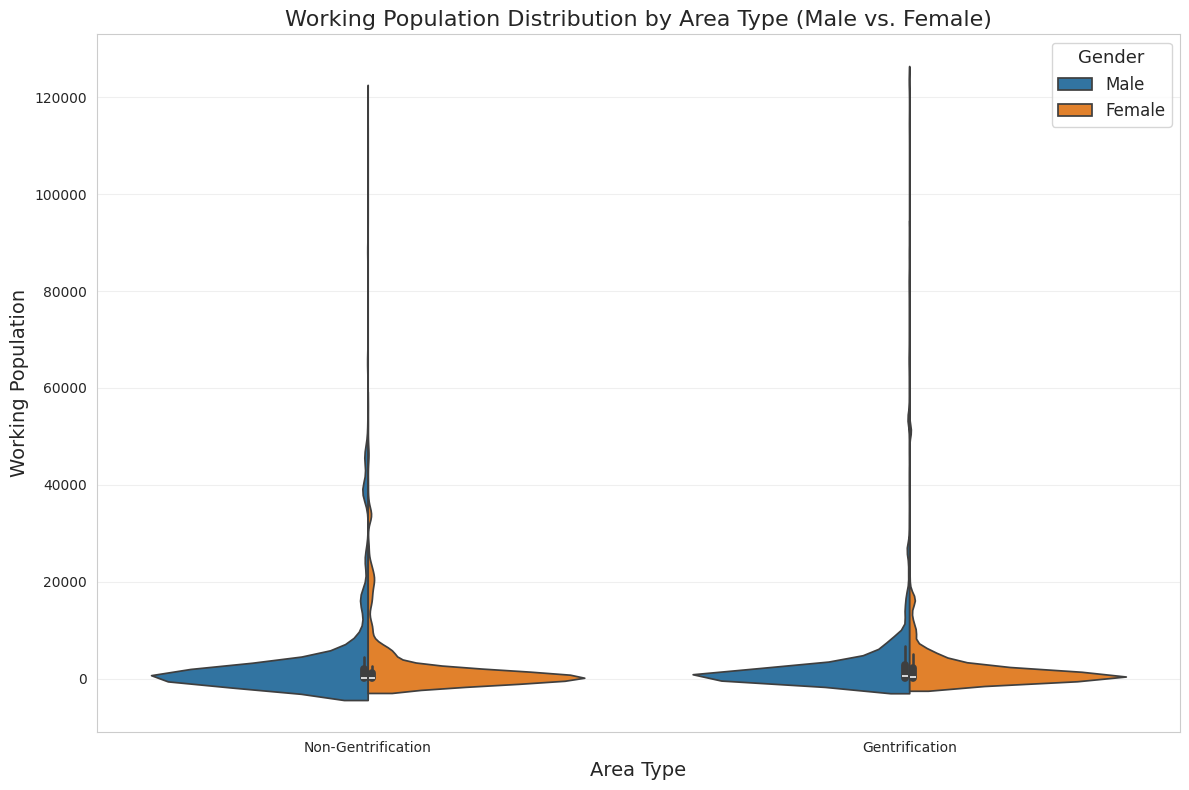

In [54]:
# 데이터 멜팅
violin_sex_data = pd.melt(
    df_dong_working_sex,
    id_vars=['구분', '상권', '연도_분기'],
    value_vars=['남성_직장인구_수', '여성_직장인구_수'],
    var_name='성별',
    value_name='직장인구_수'
)

# 성별 레이블 변환
violin_sex_data['Gender'] = violin_sex_data['성별'].map({
    '남성_직장인구_수': 'Male',
    '여성_직장인구_수': 'Female'
})

# 구분 레이블 변환
violin_sex_data['Category'] = violin_sex_data['구분'].map({
    '젠트리피케이션': 'Gentrification',
    '비젠트리피케이션': 'Non-Gentrification'
})

plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

# X축이 Category(젠/비젠), hue가 Gender(남/여)인 분할된 바이올린 플롯 생성
ax = sns.violinplot(
    x='Category',  # X축을 젠/비젠으로 설정
    y='직장인구_수',
    hue='Gender',  # 남/여를 hue로 설정하여 분할
    data=violin_sex_data,
    palette={'Male': '#1F77B4', 'Female': '#FF7F0E'},
    split=True,    # 분할 활성화
    inner='box',
    density_norm='width'
)

plt.title('Working Population Distribution by Area Type (Male vs. Female)', fontsize=16)
plt.xlabel('Area Type', fontsize=14)
plt.ylabel('Working Population', fontsize=14)
plt.legend(title='Gender', fontsize=12, title_fontsize=13)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

### 상권 직장인구 (연령대)

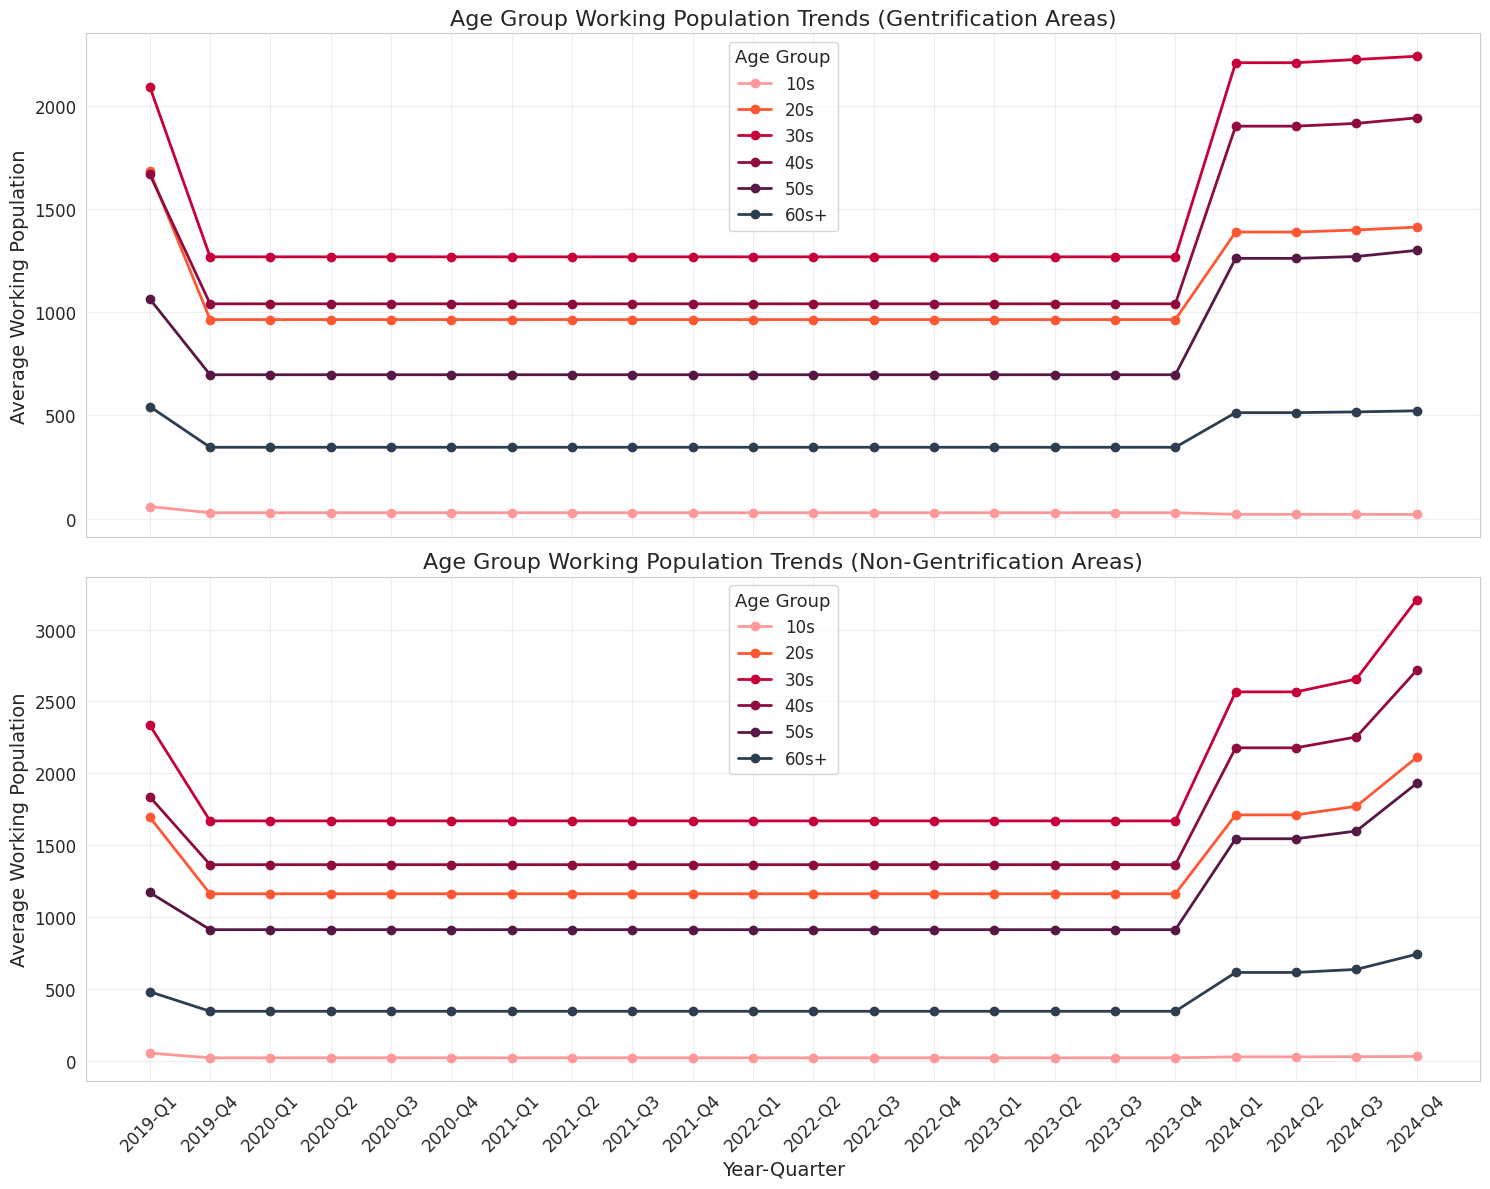

In [55]:
# 연령대 레이블 정의
age_labels = {
    "연령대_10_직장인구_수": "10s",
    "연령대_20_직장인구_수": "20s",
    "연령대_30_직장인구_수": "30s",
    "연령대_40_직장인구_수": "40s",
    "연령대_50_직장인구_수": "50s",
    "연령대_60_이상_직장인구_수": "60s+"
}

# 데이터 타입 변환
age_columns = [
    "연령대_10_직장인구_수", "연령대_20_직장인구_수", "연령대_30_직장인구_수",
    "연령대_40_직장인구_수", "연령대_50_직장인구_수", "연령대_60_이상_직장인구_수"
]

for col in age_columns:
  df_dong_working_age[col] = pd.to_numeric(df_dong_working_age[col], errors='coerce')

# 연도_분기 컬럼 변환
df_dong_working_age['연도_분기_라벨'] = df_dong_working_age['연도_분기'].astype(str).apply(
    lambda x: f"{x[:4]}-Q{x[4:]}" if len(x) >= 5 else x
)

# 3.1 시계열 라인 플롯
# 연령대별 시계열 데이터 준비
age_time_series = df_dong_working_age.groupby(['연도_분기', '연도_분기_라벨', '구분']).agg({
    col: 'mean' for col in age_columns
}).reset_index()

age_time_series = age_time_series.sort_values('연도_분기')

# 젠트리피케이션, 비젠트리피케이션 데이터 분리
gen_age_data = age_time_series[age_time_series['구분'] == '젠트리피케이션']
non_gen_age_data = age_time_series[age_time_series['구분'] == '비젠트리피케이션']

# 연령대별 색상 지정
age_colors = {
    "연령대_10_직장인구_수": "#FF9999",
    "연령대_20_직장인구_수": "#FF5733",
    "연령대_30_직장인구_수": "#C70039",
    "연령대_40_직장인구_수": "#900C3F",
    "연령대_50_직장인구_수": "#581845",
    "연령대_60_이상_직장인구_수": "#2C3E50"
}

# 두 개의 서브플롯 생성
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), sharex=True)

# 젠트리피케이션 지역의 연령대별 직장인구 시계열 그래프
for col in age_columns:
    ax1.plot(gen_age_data['연도_분기_라벨'], gen_age_data[col], 'o-', color=age_colors[col], linewidth=2, markersize=6, label=age_labels[col])

ax1.set_title('Age Group Working Population Trends (Gentrification Areas)', fontsize=16)
ax1.set_ylabel('Average Working Population', fontsize=14)
ax1.tick_params(axis='y', labelsize=12)
ax1.grid(True, alpha=0.3)
ax1.legend(title='Age Group', fontsize=12, title_fontsize=13)

# 비젠트리피케이션 지역의 연령대별 직장인구 시계열 그래프
for col in age_columns:
    ax2.plot(non_gen_age_data['연도_분기_라벨'], non_gen_age_data[col], 'o-', color=age_colors[col], linewidth=2, markersize=6, label=age_labels[col])

ax2.set_title('Age Group Working Population Trends (Non-Gentrification Areas)', fontsize=16)
ax2.set_xlabel('Year-Quarter', fontsize=14)
ax2.set_ylabel('Average Working Population', fontsize=14)
ax2.tick_params(axis='x', rotation=45, labelsize=12)
ax2.tick_params(axis='y', labelsize=12)
ax2.grid(True, alpha=0.3)
ax2.legend(title='Age Group', fontsize=12, title_fontsize=13)

plt.tight_layout()
plt.show()

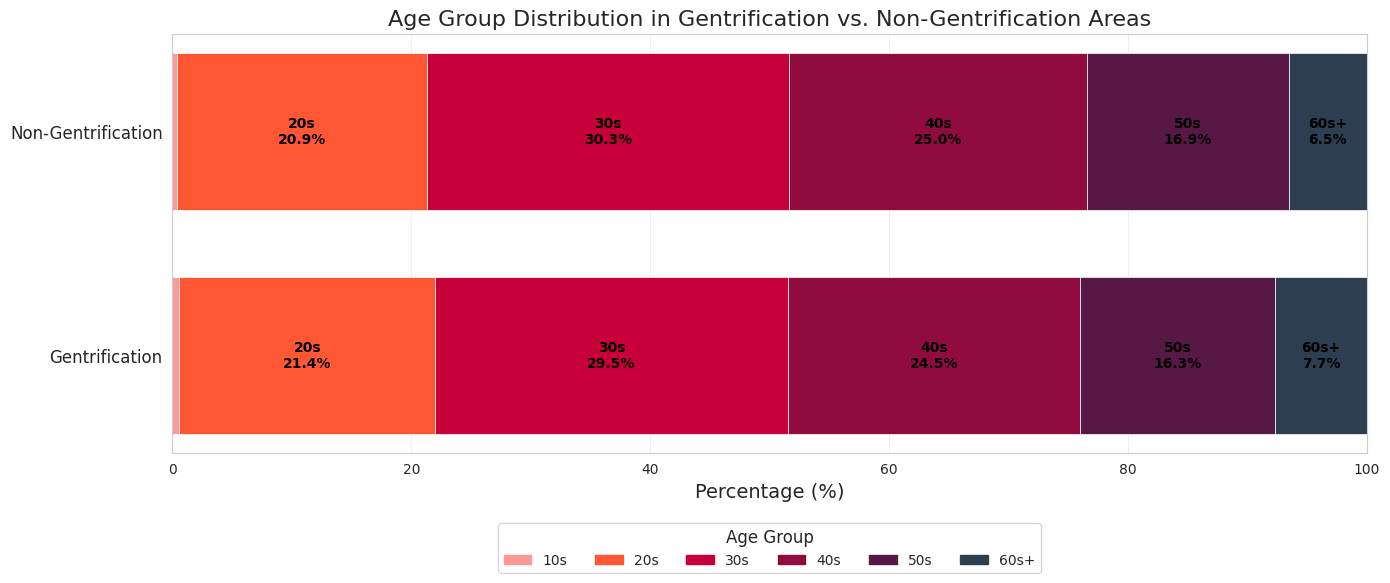

In [56]:
# 젠트리피케이션과 비젠트리피케이션 지역별로 연령대 비율 계산
# 먼저 각 구분별, 연령대별 평균 직장인구 계산
age_means = df_dong_working_age.groupby('구분')[age_columns].mean().reset_index()

# 각 행(구분)별로 총 합계 계산하여 비율 구하기
for idx, row in age_means.iterrows():
    total = row[age_columns].sum()
    for col in age_columns:
        age_means.loc[idx, f'{col}_비율'] = row[col] / total * 100

# 데이터 재구성 (멜팅)
ratio_columns = [f'{col}_비율' for col in age_columns]
age_ratio_melted = pd.melt(
    age_means,
    id_vars=['구분'],
    value_vars=ratio_columns,
    var_name='연령대_비율',
    value_name='비율'
)

# 연령대 레이블 변환
age_ratio_melted['Age_Group'] = age_ratio_melted['연령대_비율'].apply(lambda x: age_labels[x.replace('_비율', '')])
age_ratio_melted['Category'] = age_ratio_melted['구분'].map({
    '젠트리피케이션': 'Gentrification',
    '비젠트리피케이션': 'Non-Gentrification'
})

# 연령대 순서 정의
age_order = ['10s', '20s', '30s', '40s', '50s', '60s+']

# 연령대 순서 컬럼 추가
age_ratio_melted['Age_Order'] = age_ratio_melted['Age_Group'].map({age: i for i, age in enumerate(age_order)})
age_ratio_melted = age_ratio_melted.sort_values(['구분', 'Age_Order'])

# 색상 팔레트 정의 (연령대별)
colors = ['#FF9999', '#FF5733', '#C70039', '#900C3F', '#581845', '#2C3E50']
palette = {age: color for age, color in zip(age_order, colors)}

# 가로 누적 막대 그래프 그리기
plt.figure(figsize=(14, 6))
sns.set_style("whitegrid")

# 젠트리피케이션과 비젠트리피케이션을 구분하여 그래프 생성
for i, category in enumerate(['Gentrification', 'Non-Gentrification']):
    # 해당 카테고리 데이터만 필터링
    category_data = age_ratio_melted[age_ratio_melted['Category'] == category]

    # 위치 설정 (젠트리피케이션: 0, 비젠트리피케이션: 1)
    y_pos = i

    # 누적 시작 위치
    left = 0

    # 각 연령대별로 막대 그리기
    for age in age_order:
        # 해당 연령대 데이터 찾기
        age_data = category_data[category_data['Age_Group'] == age]
        if not age_data.empty:
            width = age_data['비율'].values[0]
            plt.barh(y_pos, width, left=left, height=0.7, color=palette[age], edgecolor='white', linewidth=0.5)

            # 비율이 5% 이상인 경우에만 레이블 표시
            if width >= 5:
                # 텍스트 위치 계산 (막대 중앙)
                text_x = left + width / 2
                plt.text(text_x, y_pos, f"{age}\n{width:.1f}%", ha='center', va='center', color='black', fontsize=10, fontweight='bold')

            # 다음 막대의 시작 위치 업데이트
            left += width

# Y축 설정
plt.yticks([0, 1], ['Gentrification', 'Non-Gentrification'], fontsize=12)
plt.xlabel('Percentage (%)', fontsize=14)
plt.xlim(0, 100)
plt.title('Age Group Distribution in Gentrification vs. Non-Gentrification Areas', fontsize=16)
plt.grid(True, alpha=0.3, axis='x')

# 범례 추가
handles = [plt.Rectangle((0, 0), 1, 1, color=palette[age]) for age in age_order]
plt.legend(handles, age_order, title='Age Group', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=6, fontsize=10, title_fontsize=12)

plt.tight_layout()
plt.show()

### 상권배후지 유동인구 (총 인구 수)
- 유동 인구는 젠/비젠 상관 없이 꾸준히 하락세

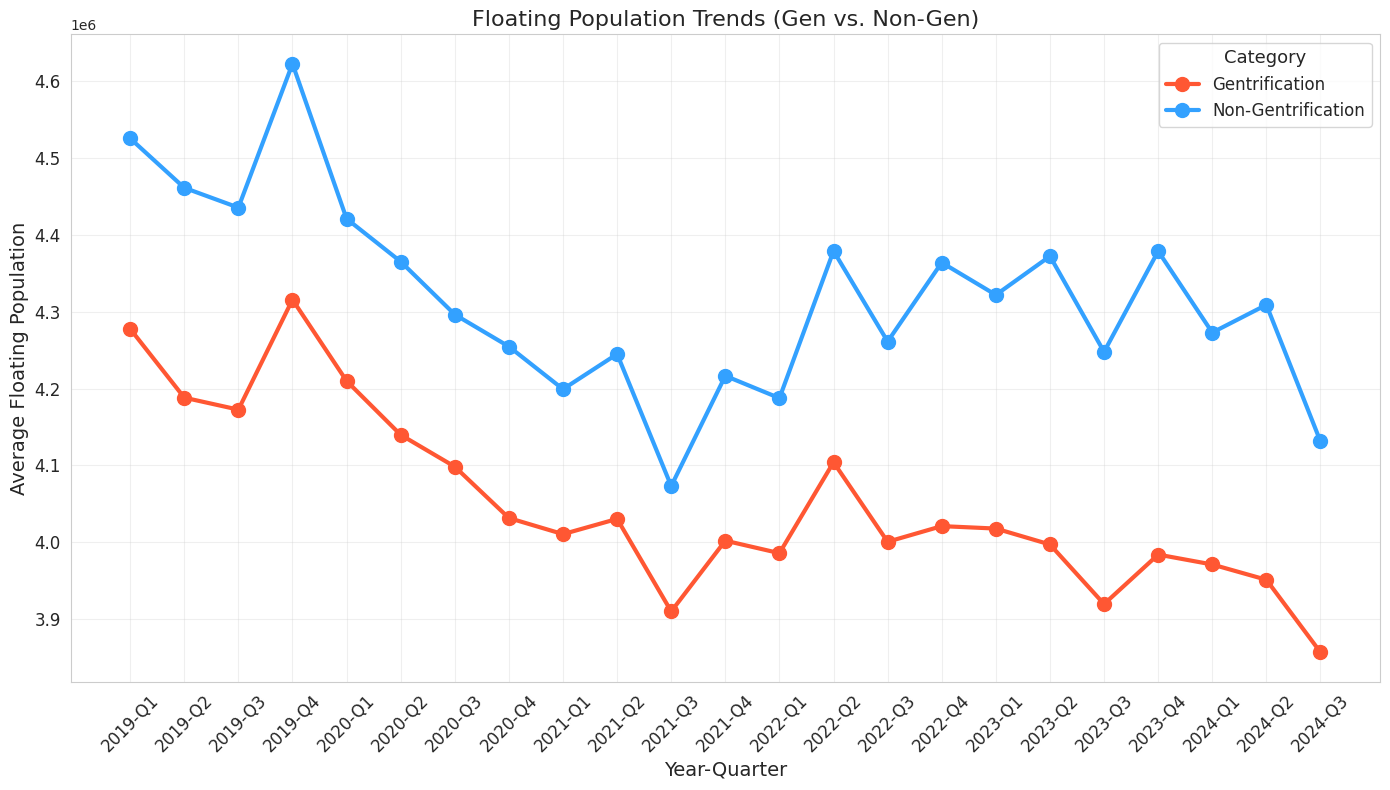

In [57]:
# 데이터 타입 변환
df_bg_dong_floating_total['총_유동인구_수'] = pd.to_numeric(df_bg_dong_floating_total['총_유동인구_수'], errors='coerce')

# 연도_분기 컬럼 변환
df_bg_dong_floating_total['연도_분기_라벨'] = df_bg_dong_floating_total['연도_분기'].astype(str).apply(lambda x: f"{x[:4]}-Q{x[4:]}" if len(x) >= 5 else x)

# 시계열 데이터
time_series_data = df_bg_dong_floating_total.groupby(['연도_분기', '연도_분기_라벨', '구분'])['총_유동인구_수'].mean().reset_index()
time_series_data = time_series_data.sort_values('연도_분기')

# 젠트리피케이션, 비젠트리피케이션 데이터 분리
gen_data = time_series_data[time_series_data['구분'] == '젠트리피케이션']
non_gen_data = time_series_data[time_series_data['구분'] == '비젠트리피케이션']

plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")

# 선 그래프 그리기
line1, = plt.plot(gen_data['연도_분기_라벨'], gen_data['총_유동인구_수'], 'o-', color='#FF5733', linewidth=3, markersize=10)
line2, = plt.plot(non_gen_data['연도_분기_라벨'], non_gen_data['총_유동인구_수'], 'o-', color='#33A1FF', linewidth=3, markersize=10)

# 그래프 스타일 설정
plt.title('Floating Population Trends (Gen vs. Non-Gen)', fontsize=16)
plt.xlabel('Year-Quarter', fontsize=14)
plt.ylabel('Average Floating Population', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend([line1, line2], ['Gentrification', 'Non-Gentrification'], title='Category', fontsize=12, title_fontsize=13)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

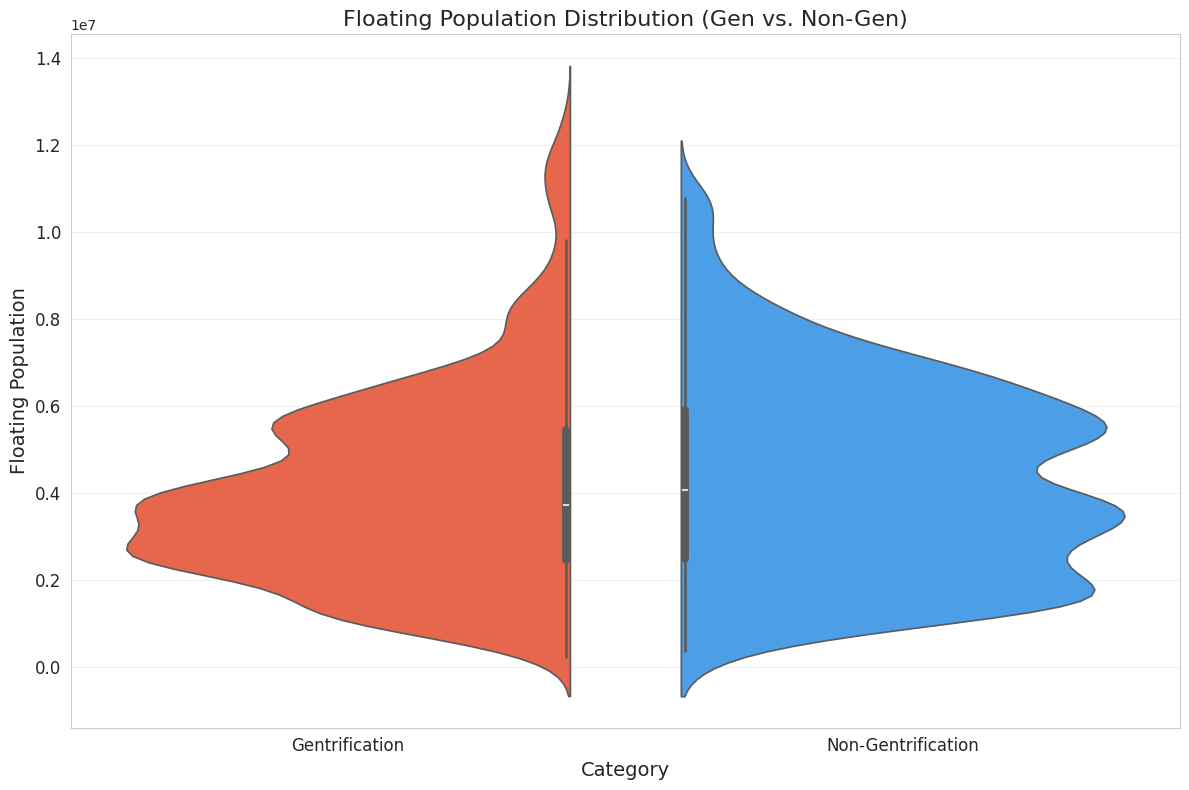

In [58]:
# 바이올린 플롯
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

# 분할된 바이올린 플롯 데이터 준비
violin_data = df_bg_dong_floating_total.copy()
violin_data['Category'] = violin_data['구분'].map({
    '젠트리피케이션': 'Gentrification',
    '비젠트리피케이션': 'Non-Gentrification'
})

# 데이터 타입 변환 확인
violin_data['총_유동인구_수'] = pd.to_numeric(violin_data['총_유동인구_수'], errors='coerce')
violin_data = violin_data.dropna(subset=['총_유동인구_수'])

# 바이올린 플롯 그리기
ax = sns.violinplot(
    x='Category',
    y='총_유동인구_수',
    hue='Category',
    data=violin_data,
    palette={'Gentrification': '#FF5733', 'Non-Gentrification': '#33A1FF'},
    inner='box',
    split=True
)

plt.title('Floating Population Distribution (Gen vs. Non-Gen)', fontsize=16)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Floating Population', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

### 상권배후지 유동인구 (성별)
- 젠/비젠 관계 없이 여성의 인구가 더 많음
- 급 상승: 2019-Q4, 2022-Q2, 2023-Q4
- 급 하락: 2019-Q2, 2020-Q1, 2021-Q3, 2022-Q3, 2023-Q3, 2024-Q3
- 비젠 여성의 경우 2022-Q1 이후 매우 요동침


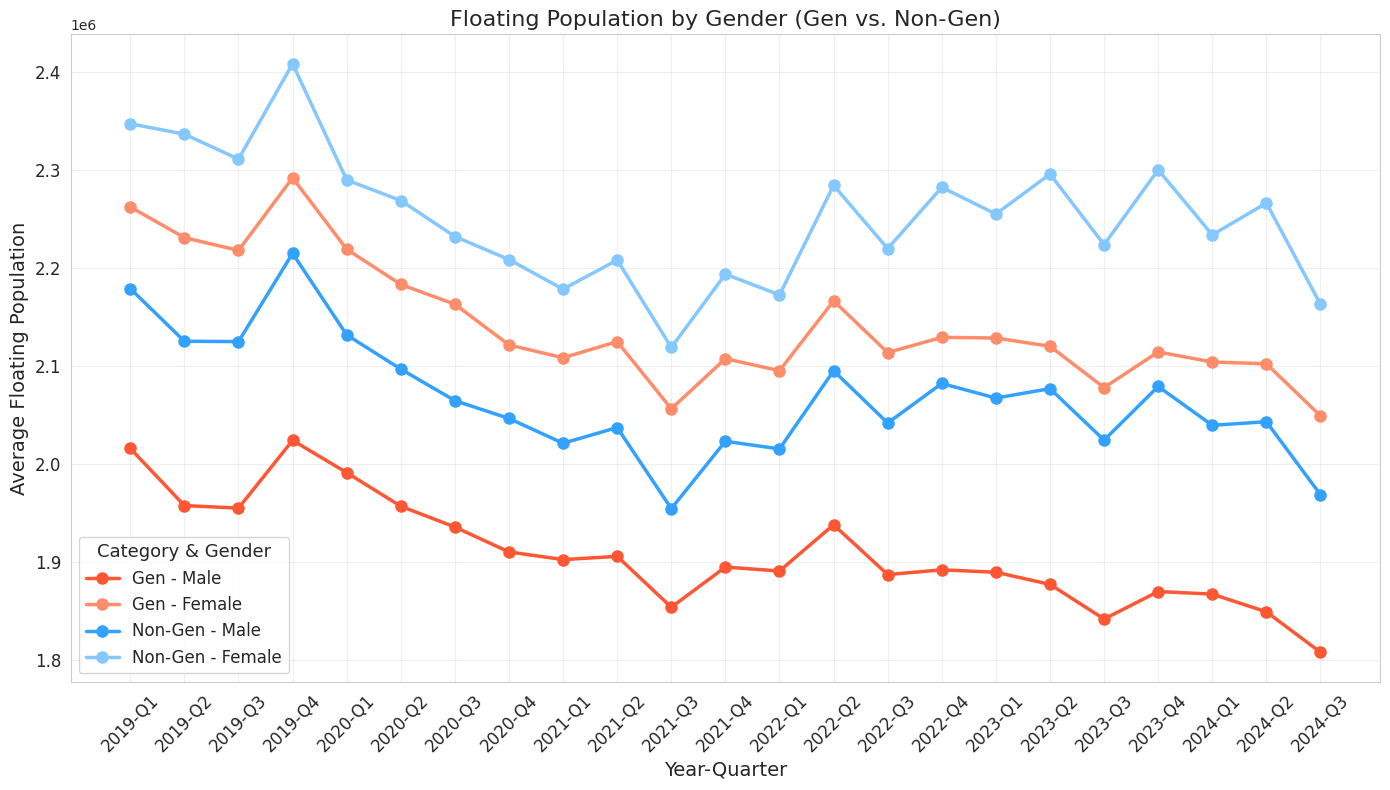

In [59]:
# 데이터 타입 변환
df_bg_dong_floating_sex['남성_유동인구_수'] = pd.to_numeric(df_bg_dong_floating_sex['남성_유동인구_수'], errors='coerce')
df_bg_dong_floating_sex['여성_유동인구_수'] = pd.to_numeric(df_bg_dong_floating_sex['여성_유동인구_수'], errors='coerce')

# 연도_분기 컬럼 변환
df_bg_dong_floating_sex['연도_분기_라벨'] = df_bg_dong_floating_sex['연도_분기'].astype(str).apply(lambda x: f"{x[:4]}-Q{x[4:]}" if len(x) >= 5 else x)

# 시계열 데이터
gender_time_series = df_bg_dong_floating_sex.groupby(['연도_분기', '연도_분기_라벨', '구분']).agg({'남성_유동인구_수': 'mean', '여성_유동인구_수': 'mean'}).reset_index()
gender_time_series = gender_time_series.sort_values('연도_분기')

# 젠트리피케이션, 비젠트리피케이션 데이터 분리
gen_gender_data = gender_time_series[gender_time_series['구분'] == '젠트리피케이션']
non_gen_gender_data = gender_time_series[gender_time_series['구분'] == '비젠트리피케이션']

plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")

# 젠트리피케이션 지역의 남성/여성 유동인구
plt.plot(gen_gender_data['연도_분기_라벨'], gen_gender_data['남성_유동인구_수'], 'o-', color='#FF5733', linewidth=2.5, markersize=8, label='Gen - Male')
plt.plot(gen_gender_data['연도_분기_라벨'], gen_gender_data['여성_유동인구_수'], 'o-', color='#FF8C6B', linewidth=2.5, markersize=8, label='Gen - Female')

# 비젠트리피케이션 지역의 남성/여성 유동인구
plt.plot(non_gen_gender_data['연도_분기_라벨'], non_gen_gender_data['남성_유동인구_수'], 'o-', color='#33A1FF', linewidth=2.5, markersize=8, label='Non-Gen - Male')
plt.plot(non_gen_gender_data['연도_분기_라벨'], non_gen_gender_data['여성_유동인구_수'], 'o-', color='#85C7FF', linewidth=2.5, markersize=8, label='Non-Gen - Female')

# 그래프 스타일 설정
plt.title('Floating Population by Gender (Gen vs. Non-Gen)', fontsize=16)
plt.xlabel('Year-Quarter', fontsize=14)
plt.ylabel('Average Floating Population', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Category & Gender', fontsize=12, title_fontsize=13)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

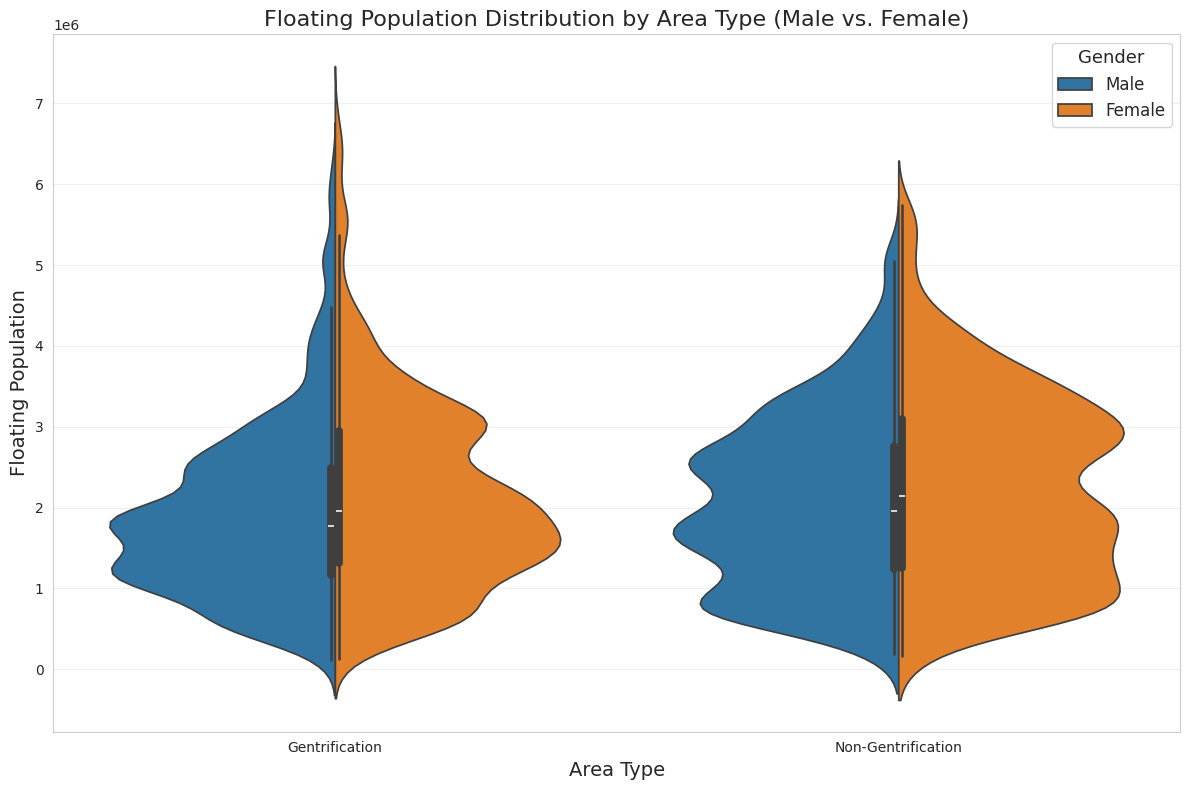

In [60]:
# 데이터 멜팅
violin_sex_data = pd.melt(
    df_bg_dong_floating_sex,
    id_vars=['구분', '상권배후지', '연도_분기'],
    value_vars=['남성_유동인구_수', '여성_유동인구_수'],
    var_name='성별',
    value_name='유동인구_수'
)

# 성별 레이블 변환
violin_sex_data['Gender'] = violin_sex_data['성별'].map({
    '남성_유동인구_수': 'Male',
    '여성_유동인구_수': 'Female'
})

# 구분 레이블 변환
violin_sex_data['Category'] = violin_sex_data['구분'].map({
    '젠트리피케이션': 'Gentrification',
    '비젠트리피케이션': 'Non-Gentrification'
})

plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

# X축이 Category(젠/비젠), hue가 Gender(남/여)인 분할된 바이올린 플롯 생성
ax = sns.violinplot(
    x='Category',  # X축을 젠/비젠으로 설정
    y='유동인구_수',
    hue='Gender',  # 남/여를 hue로 설정하여 분할
    data=violin_sex_data,
    palette={'Male': '#1F77B4', 'Female': '#FF7F0E'},
    split=True,    # 분할 활성화
    inner='box',
    density_norm='width'
)

plt.title('Floating Population Distribution by Area Type (Male vs. Female)', fontsize=16)
plt.xlabel('Area Type', fontsize=14)
plt.ylabel('Floating Population', fontsize=14)
plt.legend(title='Gender', fontsize=12, title_fontsize=13)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

### 상권배후지 유동인구 (연령대)

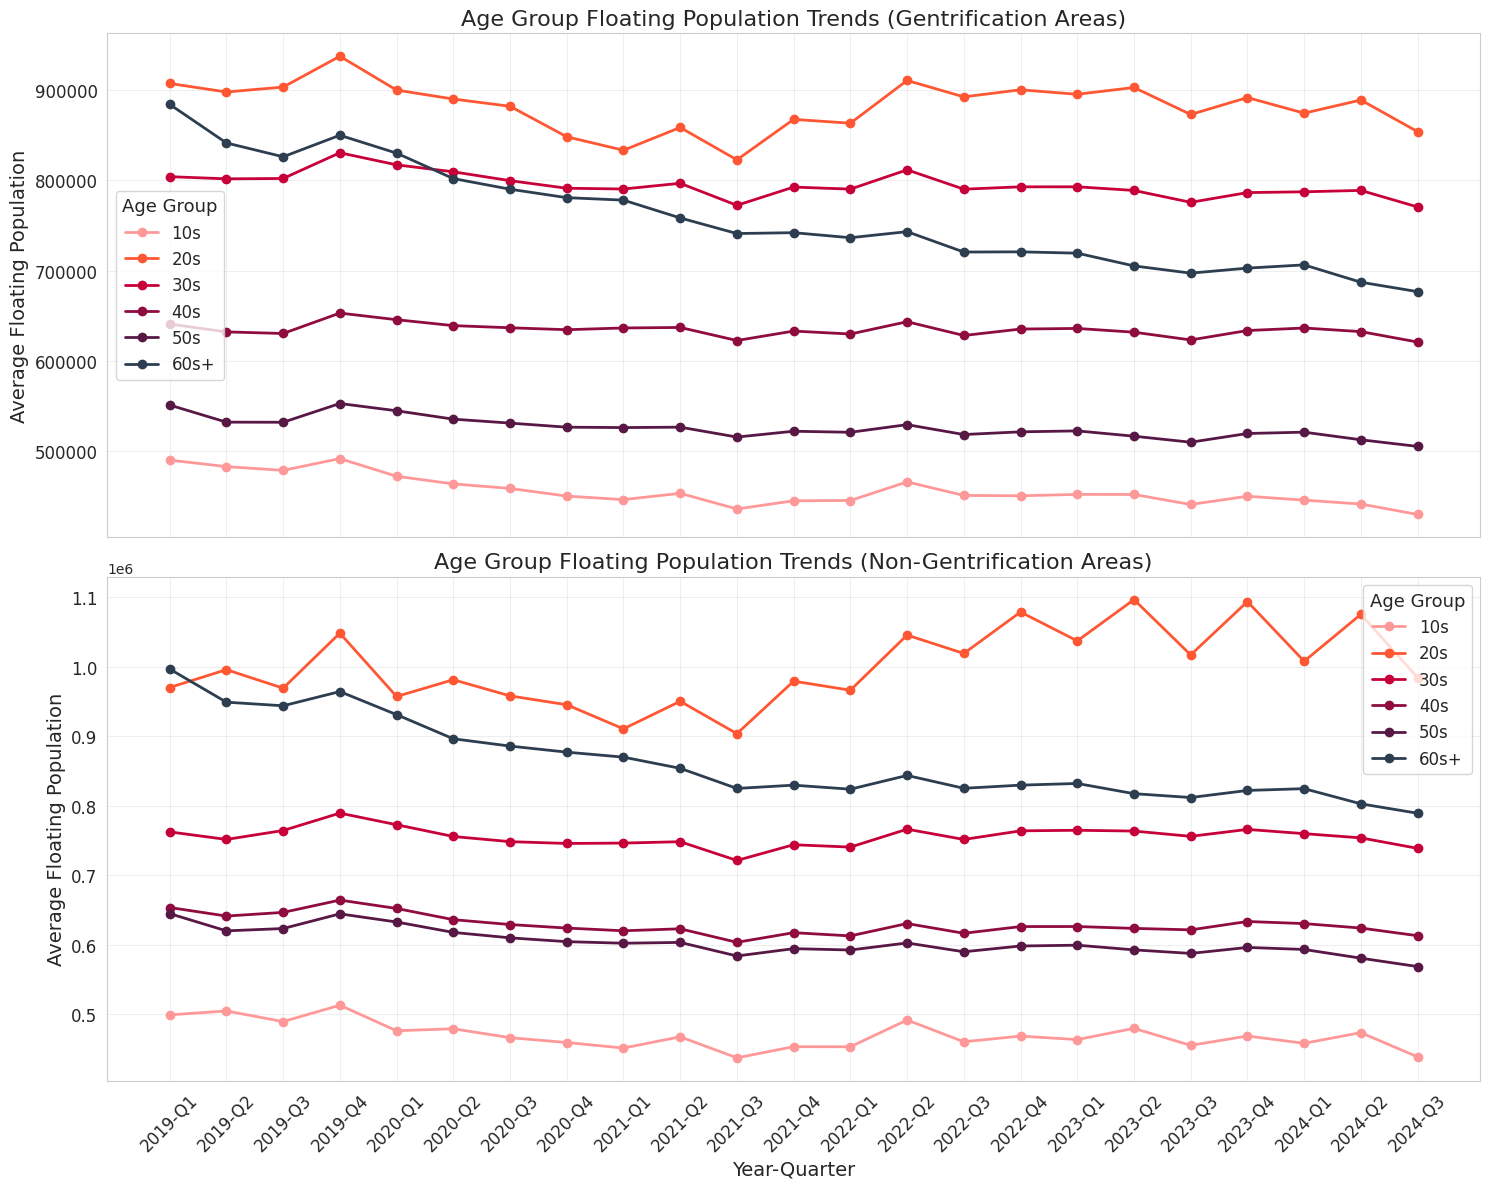

In [61]:
# 연령대 레이블 정의
age_labels = {
    "연령대_10_유동인구_수": "10s",
    "연령대_20_유동인구_수": "20s",
    "연령대_30_유동인구_수": "30s",
    "연령대_40_유동인구_수": "40s",
    "연령대_50_유동인구_수": "50s",
    "연령대_60_이상_유동인구_수": "60s+"
}

# 데이터 타입 변환
age_columns = [
    "연령대_10_유동인구_수", "연령대_20_유동인구_수", "연령대_30_유동인구_수",
    "연령대_40_유동인구_수", "연령대_50_유동인구_수", "연령대_60_이상_유동인구_수"
]

for col in age_columns:
  df_bg_dong_floating_age[col] = pd.to_numeric(df_bg_dong_floating_age[col], errors='coerce')

# 연도_분기 컬럼 변환
df_bg_dong_floating_age['연도_분기_라벨'] = df_bg_dong_floating_age['연도_분기'].astype(str).apply(
    lambda x: f"{x[:4]}-Q{x[4:]}" if len(x) >= 5 else x
)

# 3.1 시계열 라인 플롯
# 연령대별 시계열 데이터 준비
age_time_series = df_bg_dong_floating_age.groupby(['연도_분기', '연도_분기_라벨', '구분']).agg({
    col: 'mean' for col in age_columns
}).reset_index()

age_time_series = age_time_series.sort_values('연도_분기')

# 젠트리피케이션, 비젠트리피케이션 데이터 분리
gen_age_data = age_time_series[age_time_series['구분'] == '젠트리피케이션']
non_gen_age_data = age_time_series[age_time_series['구분'] == '비젠트리피케이션']

# 연령대별 색상 지정
age_colors = {
    "연령대_10_유동인구_수": "#FF9999",
    "연령대_20_유동인구_수": "#FF5733",
    "연령대_30_유동인구_수": "#C70039",
    "연령대_40_유동인구_수": "#900C3F",
    "연령대_50_유동인구_수": "#581845",
    "연령대_60_이상_유동인구_수": "#2C3E50"
}

# 두 개의 서브플롯 생성
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), sharex=True)

# 젠트리피케이션 지역의 연령대별 유동인구 시계열 그래프
for col in age_columns:
    ax1.plot(gen_age_data['연도_분기_라벨'], gen_age_data[col], 'o-', color=age_colors[col], linewidth=2, markersize=6, label=age_labels[col])

ax1.set_title('Age Group Floating Population Trends (Gentrification Areas)', fontsize=16)
ax1.set_ylabel('Average Floating Population', fontsize=14)
ax1.tick_params(axis='y', labelsize=12)
ax1.grid(True, alpha=0.3)
ax1.legend(title='Age Group', fontsize=12, title_fontsize=13)

# 비젠트리피케이션 지역의 연령대별 유동인구 시계열 그래프
for col in age_columns:
    ax2.plot(non_gen_age_data['연도_분기_라벨'], non_gen_age_data[col], 'o-', color=age_colors[col], linewidth=2, markersize=6, label=age_labels[col])

ax2.set_title('Age Group Floating Population Trends (Non-Gentrification Areas)', fontsize=16)
ax2.set_xlabel('Year-Quarter', fontsize=14)
ax2.set_ylabel('Average Floating Population', fontsize=14)
ax2.tick_params(axis='x', rotation=45, labelsize=12)
ax2.tick_params(axis='y', labelsize=12)
ax2.grid(True, alpha=0.3)
ax2.legend(title='Age Group', fontsize=12, title_fontsize=13)

plt.tight_layout()
plt.show()

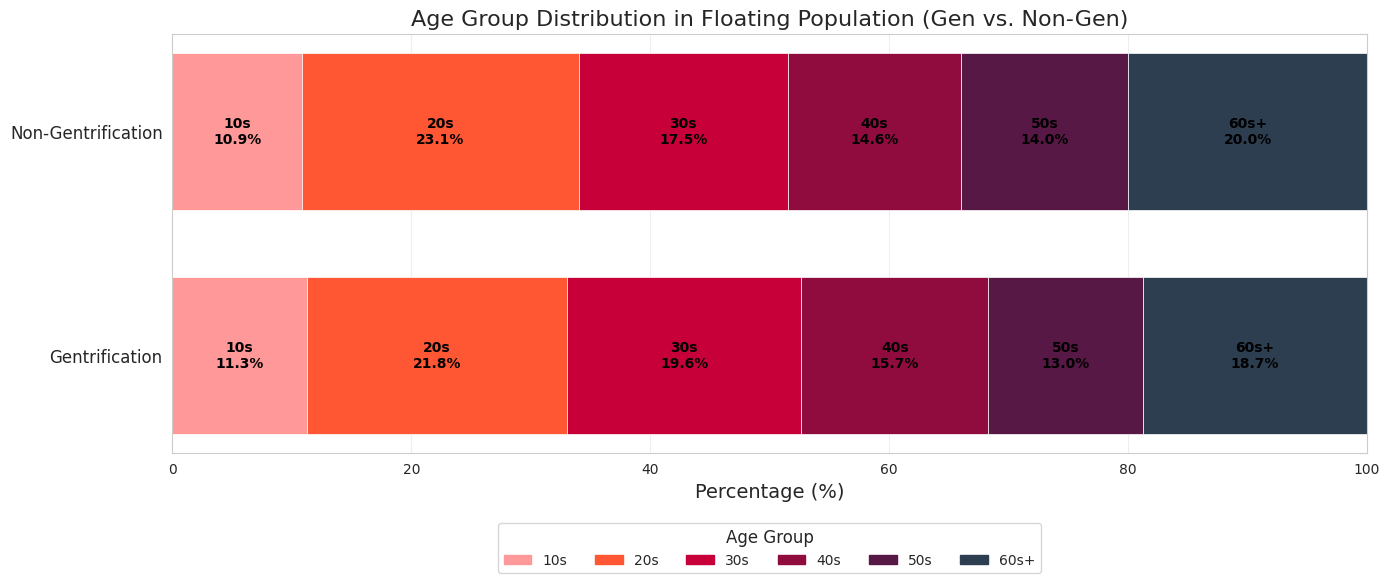

In [62]:
# 연령대 레이블 정의 (유동인구용)
age_labels = {
    "연령대_10_유동인구_수": "10s",
    "연령대_20_유동인구_수": "20s",
    "연령대_30_유동인구_수": "30s",
    "연령대_40_유동인구_수": "40s",
    "연령대_50_유동인구_수": "50s",
    "연령대_60_이상_유동인구_수": "60s+"
}

# 데이터 타입 변환 (유동인구용)
age_columns = [
    "연령대_10_유동인구_수", "연령대_20_유동인구_수", "연령대_30_유동인구_수",
    "연령대_40_유동인구_수", "연령대_50_유동인구_수", "연령대_60_이상_유동인구_수"
]

# 젠트리피케이션과 비젠트리피케이션 지역별로 연령대 비율 계산
# 먼저 각 구분별, 연령대별 평균 유동인구 계산
age_means = df_bg_dong_floating_age.groupby('구분')[age_columns].mean().reset_index()

# 각 행(구분)별로 총 합계 계산하여 비율 구하기
for idx, row in age_means.iterrows():
    total = row[age_columns].sum()
    for col in age_columns:
        age_means.loc[idx, f'{col}_비율'] = row[col] / total * 100

# 데이터 재구성 (멜팅)
ratio_columns = [f'{col}_비율' for col in age_columns]
age_ratio_melted = pd.melt(
    age_means,
    id_vars=['구분'],
    value_vars=ratio_columns,
    var_name='연령대_비율',
    value_name='비율'
)

# 연령대 레이블 변환
age_ratio_melted['Age_Group'] = age_ratio_melted['연령대_비율'].apply(lambda x: age_labels[x.replace('_비율', '')])
age_ratio_melted['Category'] = age_ratio_melted['구분'].map({
    '젠트리피케이션': 'Gentrification',
    '비젠트리피케이션': 'Non-Gentrification'
})

# 연령대 순서 정의
age_order = ['10s', '20s', '30s', '40s', '50s', '60s+']

# 연령대 순서 컬럼 추가
age_ratio_melted['Age_Order'] = age_ratio_melted['Age_Group'].map({age: i for i, age in enumerate(age_order)})
age_ratio_melted = age_ratio_melted.sort_values(['구분', 'Age_Order'])

# 색상 팔레트 정의 (연령대별)
colors = ['#FF9999', '#FF5733', '#C70039', '#900C3F', '#581845', '#2C3E50']
palette = {age: color for age, color in zip(age_order, colors)}

# 가로 누적 막대 그래프 그리기
plt.figure(figsize=(14, 6))
sns.set_style("whitegrid")

# 젠트리피케이션과 비젠트리피케이션을 구분하여 그래프 생성
for i, category in enumerate(['Gentrification', 'Non-Gentrification']):
    # 해당 카테고리 데이터만 필터링
    category_data = age_ratio_melted[age_ratio_melted['Category'] == category]

    # 위치 설정 (젠트리피케이션: 0, 비젠트리피케이션: 1)
    y_pos = i

    # 누적 시작 위치
    left = 0

    # 각 연령대별로 막대 그리기
    for age in age_order:
        # 해당 연령대 데이터 찾기
        age_data = category_data[category_data['Age_Group'] == age]
        if not age_data.empty:
            width = age_data['비율'].values[0]
            plt.barh(y_pos, width, left=left, height=0.7, color=palette[age], edgecolor='white', linewidth=0.5)

            # 비율이 5% 이상인 경우에만 레이블 표시
            if width >= 5:
                # 텍스트 위치 계산 (막대 중앙)
                text_x = left + width / 2
                plt.text(text_x, y_pos, f"{age}\n{width:.1f}%", ha='center', va='center', color='black', fontsize=10, fontweight='bold')

            # 다음 막대의 시작 위치 업데이트
            left += width

# Y축 설정
plt.yticks([0, 1], ['Gentrification', 'Non-Gentrification'], fontsize=12)
plt.xlabel('Percentage (%)', fontsize=14)
plt.xlim(0, 100)
plt.title('Age Group Distribution in Floating Population (Gen vs. Non-Gen)', fontsize=16)
plt.grid(True, alpha=0.3, axis='x')

# 범례 추가
handles = [plt.Rectangle((0, 0), 1, 1, color=palette[age]) for age in age_order]
plt.legend(handles, age_order, title='Age Group', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=6, fontsize=10, title_fontsize=12)

plt.tight_layout()
plt.show()

### 상권배후지 상주인구 (총 인구 수)
- 젠트리피케이션 지역의 상주 인구 수는 상승하다가 2023-Q3 이후로 하락세
- 비젠트리피케이션 지역의 상주 인구 수는 꾸준히 하락세

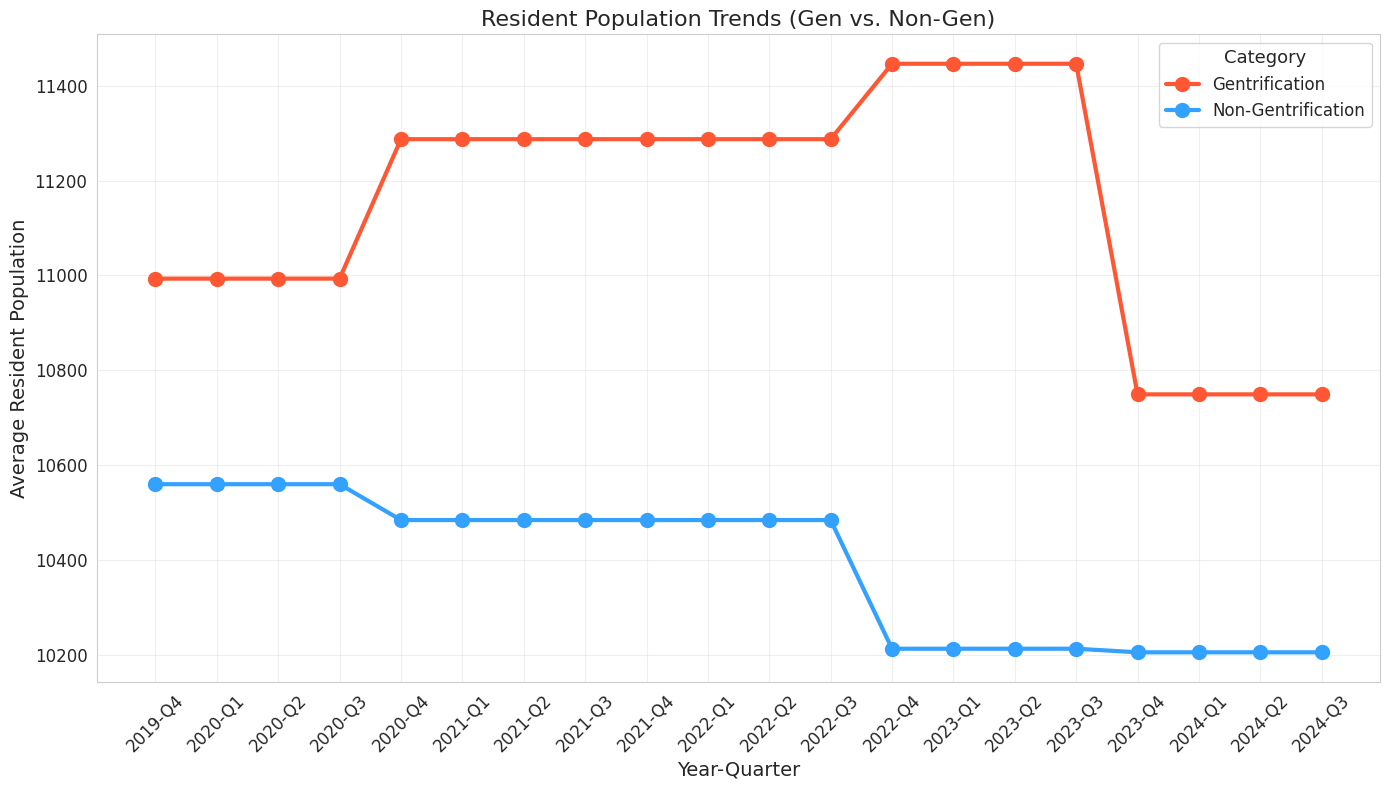

In [63]:
# 데이터 타입 변환
df_bg_dong_resident_total['총_상주인구_수'] = pd.to_numeric(df_bg_dong_resident_total['총_상주인구_수'], errors='coerce')

# 연도_분기 컬럼 변환
df_bg_dong_resident_total['연도_분기_라벨'] = df_bg_dong_resident_total['연도_분기'].astype(str).apply(lambda x: f"{x[:4]}-Q{x[4:]}" if len(x) >= 5 else x)

# 시계열 데이터
time_series_data = df_bg_dong_resident_total.groupby(['연도_분기', '연도_분기_라벨', '구분'])['총_상주인구_수'].mean().reset_index()
time_series_data = time_series_data.sort_values('연도_분기')

# 젠트리피케이션, 비젠트리피케이션 데이터 분리
gen_data = time_series_data[time_series_data['구분'] == '젠트리피케이션']
non_gen_data = time_series_data[time_series_data['구분'] == '비젠트리피케이션']

plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")

# 선 그래프 그리기
line1, = plt.plot(gen_data['연도_분기_라벨'], gen_data['총_상주인구_수'], 'o-', color='#FF5733', linewidth=3, markersize=10)
line2, = plt.plot(non_gen_data['연도_분기_라벨'], non_gen_data['총_상주인구_수'], 'o-', color='#33A1FF', linewidth=3, markersize=10)

# 그래프 스타일 설정
plt.title('Resident Population Trends (Gen vs. Non-Gen)', fontsize=16)
plt.xlabel('Year-Quarter', fontsize=14)
plt.ylabel('Average Resident Population', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend([line1, line2], ['Gentrification', 'Non-Gentrification'], title='Category', fontsize=12, title_fontsize=13)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

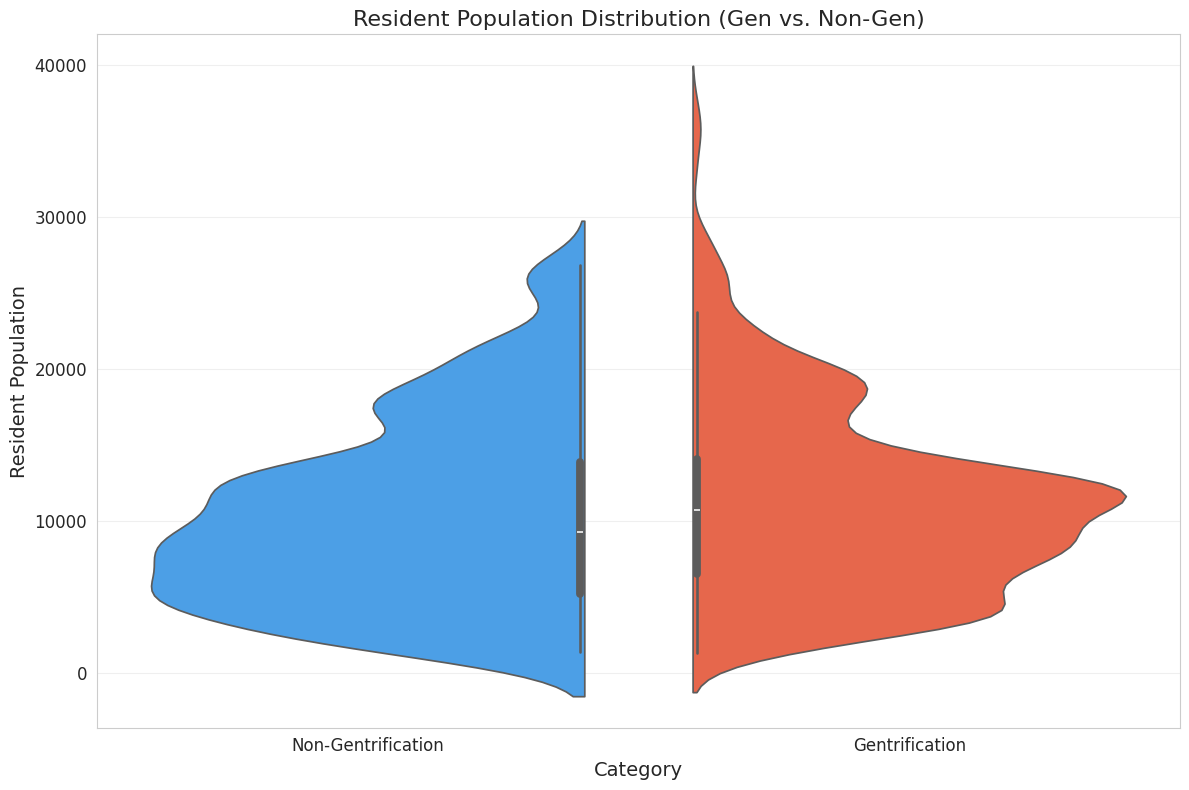

In [64]:
# 바이올린 플롯
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

# 분할된 바이올린 플롯 데이터 준비
violin_data = df_bg_dong_resident_total.copy()
violin_data['Category'] = violin_data['구분'].map({
    '젠트리피케이션': 'Gentrification',
    '비젠트리피케이션': 'Non-Gentrification'
})

# 바이올린 플롯 그리기
ax = sns.violinplot(
    x='Category',
    y='총_상주인구_수',
    hue='Category',
    data=violin_data,
    palette={'Gentrification': '#FF5733', 'Non-Gentrification': '#33A1FF'},
    inner='box',
    density_norm='width',
    split=True
)

plt.title('Resident Population Distribution (Gen vs. Non-Gen)', fontsize=16)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Resident Population', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

### 상권배후지 상주인구 (성별)

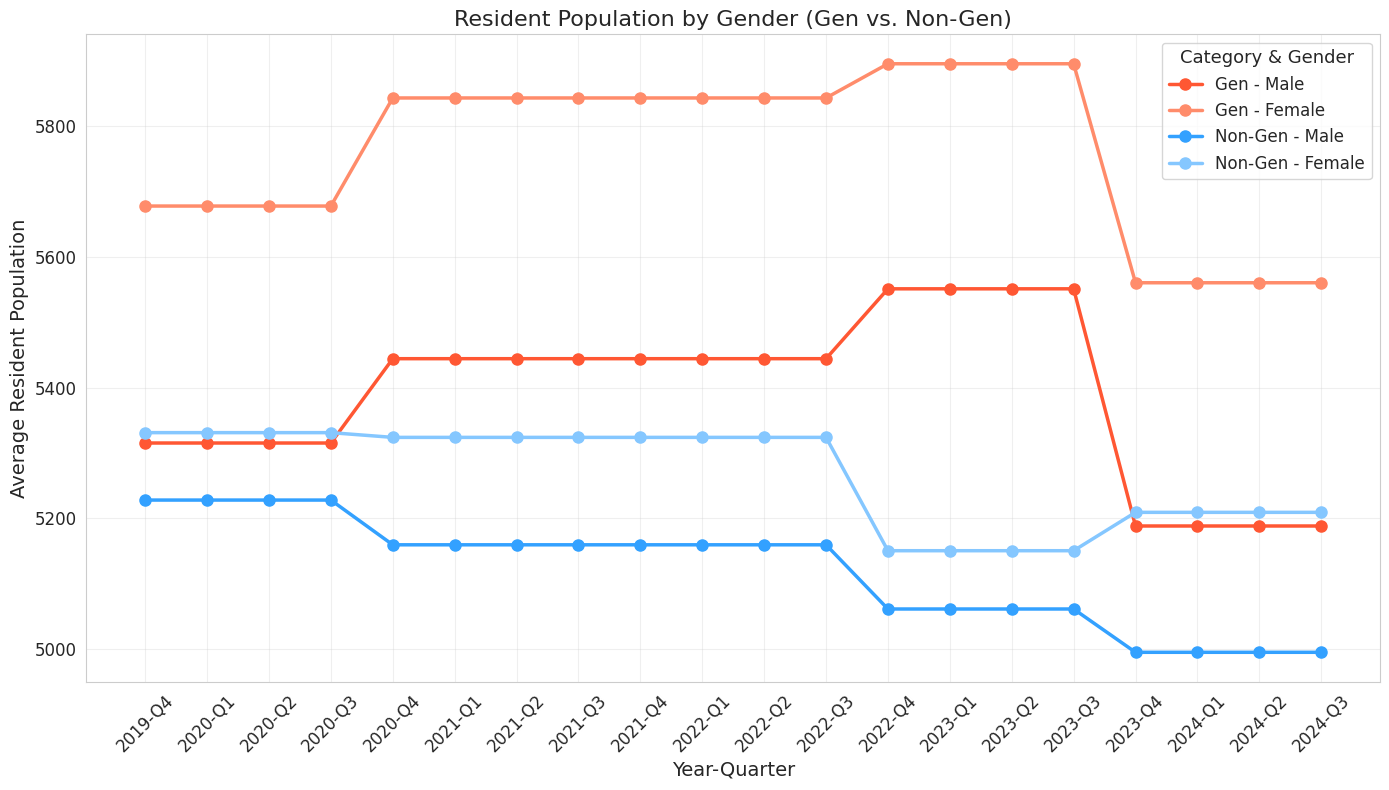

In [65]:
# 데이터 타입 변환
df_bg_dong_resident_sex['남성_상주인구_수'] = pd.to_numeric(df_bg_dong_resident_sex['남성_상주인구_수'], errors='coerce')
df_bg_dong_resident_sex['여성_상주인구_수'] = pd.to_numeric(df_bg_dong_resident_sex['여성_상주인구_수'], errors='coerce')

# 연도_분기 컬럼 변환
df_bg_dong_resident_sex['연도_분기_라벨'] = df_bg_dong_resident_sex['연도_분기'].astype(str).apply(lambda x: f"{x[:4]}-Q{x[4:]}" if len(x) >= 5 else x)

# 시계열 데이터
gender_time_series = df_bg_dong_resident_sex.groupby(['연도_분기', '연도_분기_라벨', '구분']).agg({'남성_상주인구_수': 'mean', '여성_상주인구_수': 'mean'}).reset_index()
gender_time_series = gender_time_series.sort_values('연도_분기')

# 젠트리피케이션, 비젠트리피케이션 데이터 분리
gen_gender_data = gender_time_series[gender_time_series['구분'] == '젠트리피케이션']
non_gen_gender_data = gender_time_series[gender_time_series['구분'] == '비젠트리피케이션']

plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")

# 젠트리피케이션 지역의 남성/여성 상주인구
plt.plot(gen_gender_data['연도_분기_라벨'], gen_gender_data['남성_상주인구_수'], 'o-', color='#FF5733', linewidth=2.5, markersize=8, label='Gen - Male')
plt.plot(gen_gender_data['연도_분기_라벨'], gen_gender_data['여성_상주인구_수'], 'o-', color='#FF8C6B', linewidth=2.5, markersize=8, label='Gen - Female')

# 비젠트리피케이션 지역의 남성/여성 상주인구
plt.plot(non_gen_gender_data['연도_분기_라벨'], non_gen_gender_data['남성_상주인구_수'], 'o-', color='#33A1FF', linewidth=2.5, markersize=8, label='Non-Gen - Male')
plt.plot(non_gen_gender_data['연도_분기_라벨'], non_gen_gender_data['여성_상주인구_수'], 'o-', color='#85C7FF', linewidth=2.5, markersize=8, label='Non-Gen - Female')

# 그래프 스타일 설정
plt.title('Resident Population by Gender (Gen vs. Non-Gen)', fontsize=16)
plt.xlabel('Year-Quarter', fontsize=14)
plt.ylabel('Average Resident Population', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Category & Gender', fontsize=12, title_fontsize=13)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

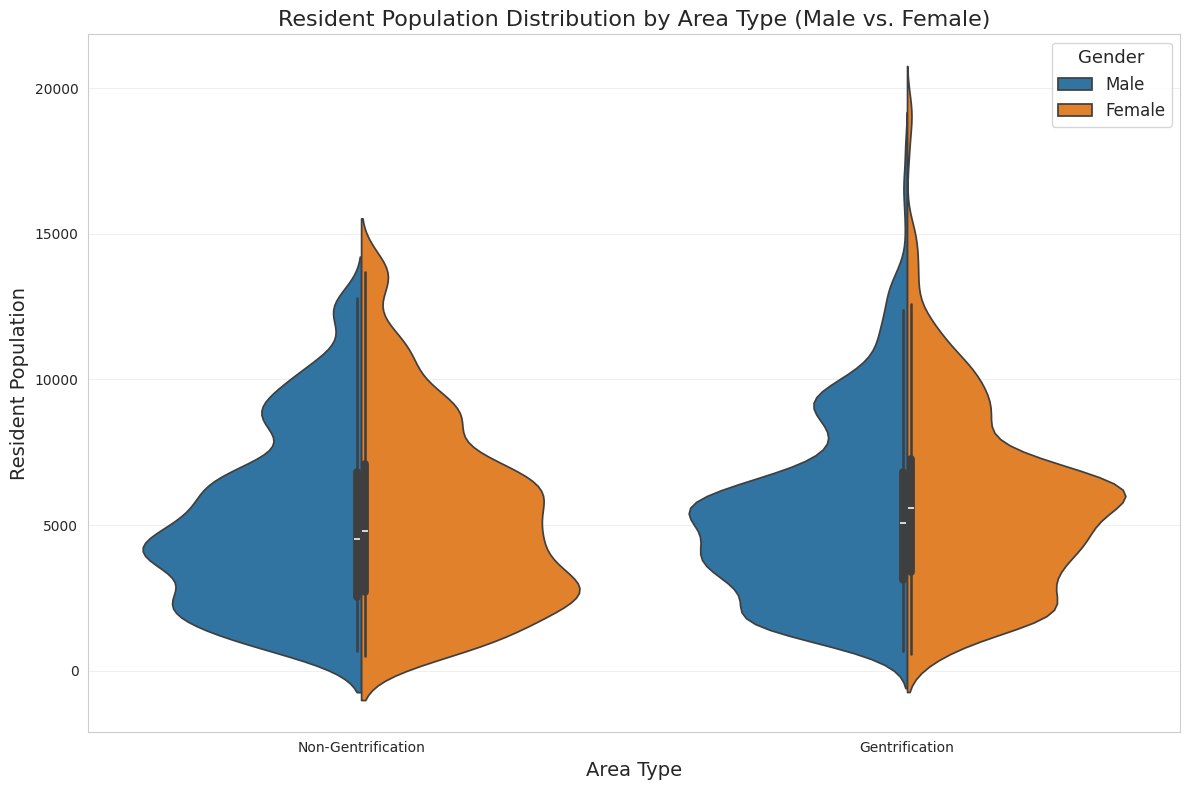

In [66]:
# 데이터 멜팅
violin_sex_data = pd.melt(
    df_bg_dong_resident_sex,
    id_vars=['구분', '상권배후지', '연도_분기'],
    value_vars=['남성_상주인구_수', '여성_상주인구_수'],
    var_name='성별',
    value_name='상주인구_수'
)

# 성별 레이블 변환
violin_sex_data['Gender'] = violin_sex_data['성별'].map({
    '남성_상주인구_수': 'Male',
    '여성_상주인구_수': 'Female'
})

# 구분 레이블 변환
violin_sex_data['Category'] = violin_sex_data['구분'].map({
    '젠트리피케이션': 'Gentrification',
    '비젠트리피케이션': 'Non-Gentrification'
})

plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

# X축이 Category(젠/비젠), hue가 Gender(남/여)인 분할된 바이올린 플롯 생성
ax = sns.violinplot(
    x='Category',  # X축을 젠/비젠으로 설정
    y='상주인구_수',
    hue='Gender',  # 남/여를 hue로 설정하여 분할
    data=violin_sex_data,
    palette={'Male': '#1F77B4', 'Female': '#FF7F0E'},
    split=True,    # 분할 활성화
    inner='box',
    density_norm='width'
)

plt.title('Resident Population Distribution by Area Type (Male vs. Female)', fontsize=16)
plt.xlabel('Area Type', fontsize=14)
plt.ylabel('Resident Population', fontsize=14)
plt.legend(title='Gender', fontsize=12, title_fontsize=13)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

### 상권배후지 상주인구 (연령대)

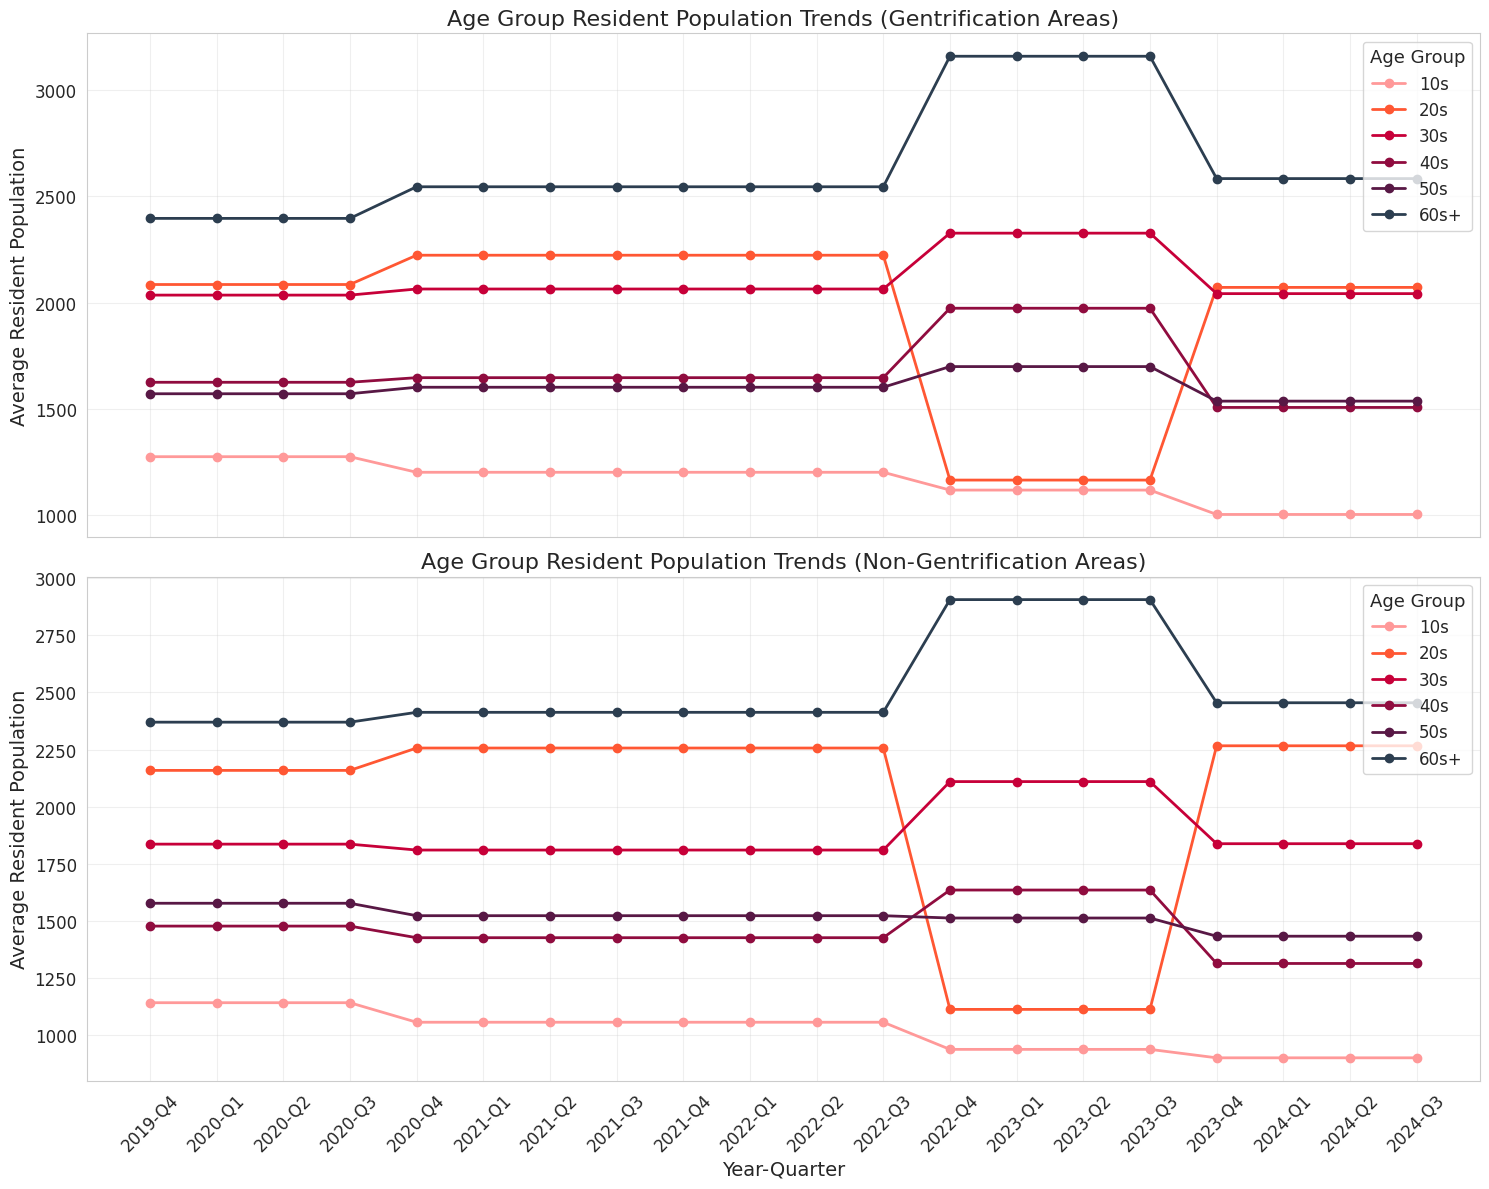

In [67]:
# 연령대 레이블 정의
age_labels = {
    "연령대_10_상주인구_수": "10s",
    "연령대_20_상주인구_수": "20s",
    "연령대_30_상주인구_수": "30s",
    "연령대_40_상주인구_수": "40s",
    "연령대_50_상주인구_수": "50s",
    "연령대_60_이상_상주인구_수": "60s+"
}

# 데이터 타입 변환
age_columns = [
    "연령대_10_상주인구_수", "연령대_20_상주인구_수", "연령대_30_상주인구_수",
    "연령대_40_상주인구_수", "연령대_50_상주인구_수", "연령대_60_이상_상주인구_수"
]

for col in age_columns:
  df_bg_dong_resident_age[col] = pd.to_numeric(df_bg_dong_resident_age[col], errors='coerce')

# 연도_분기 컬럼 변환
df_bg_dong_resident_age['연도_분기_라벨'] = df_bg_dong_resident_age['연도_분기'].astype(str).apply(
    lambda x: f"{x[:4]}-Q{x[4:]}" if len(x) >= 5 else x
)

# 3.1 시계열 라인 플롯
# 연령대별 시계열 데이터 준비
age_time_series = df_bg_dong_resident_age.groupby(['연도_분기', '연도_분기_라벨', '구분']).agg({
    col: 'mean' for col in age_columns
}).reset_index()

age_time_series = age_time_series.sort_values('연도_분기')

# 젠트리피케이션, 비젠트리피케이션 데이터 분리
gen_age_data = age_time_series[age_time_series['구분'] == '젠트리피케이션']
non_gen_age_data = age_time_series[age_time_series['구분'] == '비젠트리피케이션']

# 연령대별 색상 지정
age_colors = {
    "연령대_10_상주인구_수": "#FF9999",
    "연령대_20_상주인구_수": "#FF5733",
    "연령대_30_상주인구_수": "#C70039",
    "연령대_40_상주인구_수": "#900C3F",
    "연령대_50_상주인구_수": "#581845",
    "연령대_60_이상_상주인구_수": "#2C3E50"
}

# 두 개의 서브플롯 생성
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), sharex=True)

# 젠트리피케이션 지역의 연령대별 상주인구 시계열 그래프
for col in age_columns:
    ax1.plot(gen_age_data['연도_분기_라벨'], gen_age_data[col], 'o-',
             color=age_colors[col], linewidth=2, markersize=6, label=age_labels[col])

ax1.set_title('Age Group Resident Population Trends (Gentrification Areas)', fontsize=16)
ax1.set_ylabel('Average Resident Population', fontsize=14)
ax1.tick_params(axis='y', labelsize=12)
ax1.grid(True, alpha=0.3)
ax1.legend(title='Age Group', fontsize=12, title_fontsize=13)

# 비젠트리피케이션 지역의 연령대별 상주인구 시계열 그래프
for col in age_columns:
    ax2.plot(non_gen_age_data['연도_분기_라벨'], non_gen_age_data[col], 'o-',
             color=age_colors[col], linewidth=2, markersize=6, label=age_labels[col])

ax2.set_title('Age Group Resident Population Trends (Non-Gentrification Areas)', fontsize=16)
ax2.set_xlabel('Year-Quarter', fontsize=14)
ax2.set_ylabel('Average Resident Population', fontsize=14)
ax2.tick_params(axis='x', rotation=45, labelsize=12)
ax2.tick_params(axis='y', labelsize=12)
ax2.grid(True, alpha=0.3)
ax2.legend(title='Age Group', fontsize=12, title_fontsize=13)

plt.tight_layout()
plt.show()

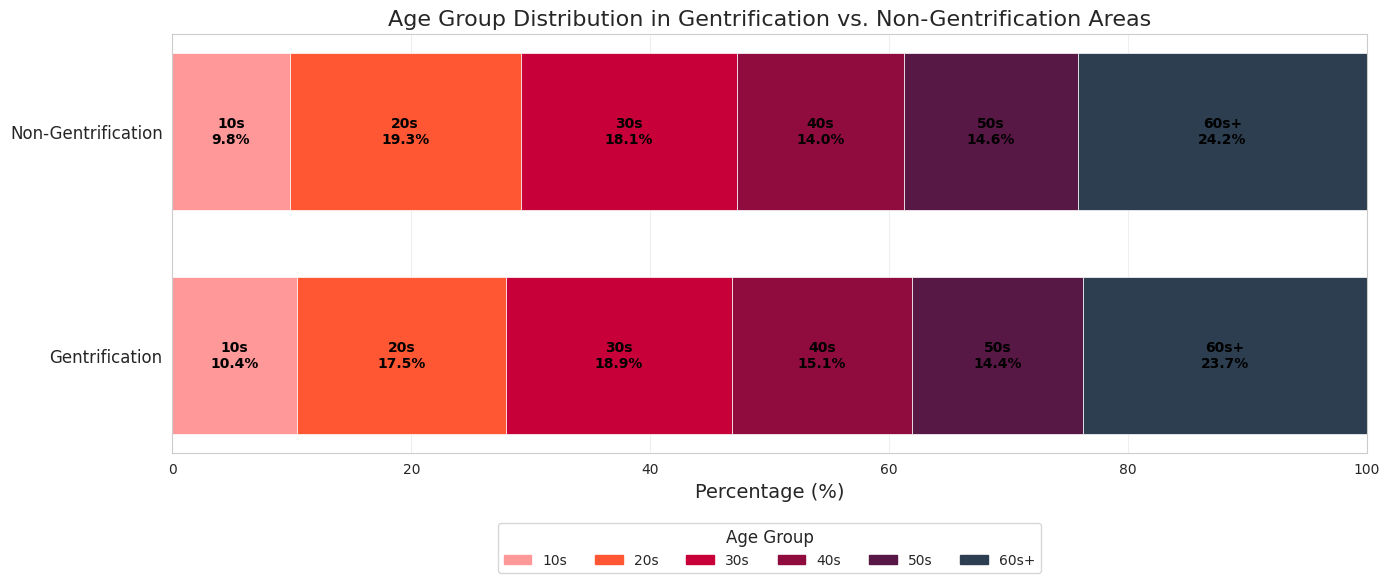

In [68]:
# 젠트리피케이션과 비젠트리피케이션 지역별로 연령대 비율 계산
# 먼저 각 구분별, 연령대별 평균 상주인구 계산
age_means = df_bg_dong_resident_age.groupby('구분')[age_columns].mean().reset_index()

# 각 행(구분)별로 총 합계 계산하여 비율 구하기
for idx, row in age_means.iterrows():
    total = row[age_columns].sum()
    for col in age_columns:
        age_means.loc[idx, f'{col}_비율'] = row[col] / total * 100

# 데이터 재구성 (멜팅)
ratio_columns = [f'{col}_비율' for col in age_columns]
age_ratio_melted = pd.melt(
    age_means,
    id_vars=['구분'],
    value_vars=ratio_columns,
    var_name='연령대_비율',
    value_name='비율'
)

# 연령대 레이블 변환
age_ratio_melted['Age_Group'] = age_ratio_melted['연령대_비율'].apply(lambda x: age_labels[x.replace('_비율', '')])
age_ratio_melted['Category'] = age_ratio_melted['구분'].map({
    '젠트리피케이션': 'Gentrification',
    '비젠트리피케이션': 'Non-Gentrification'
})

# 연령대 순서 정의
age_order = ['10s', '20s', '30s', '40s', '50s', '60s+']

# 연령대 순서 컬럼 추가
age_ratio_melted['Age_Order'] = age_ratio_melted['Age_Group'].map({age: i for i, age in enumerate(age_order)})
age_ratio_melted = age_ratio_melted.sort_values(['구분', 'Age_Order'])

# 색상 팔레트 정의 (연령대별)
colors = ['#FF9999', '#FF5733', '#C70039', '#900C3F', '#581845', '#2C3E50']
palette = {age: color for age, color in zip(age_order, colors)}

# 가로 누적 막대 그래프 그리기
plt.figure(figsize=(14, 6))
sns.set_style("whitegrid")

# 젠트리피케이션과 비젠트리피케이션을 구분하여 그래프 생성
for i, category in enumerate(['Gentrification', 'Non-Gentrification']):
    # 해당 카테고리 데이터만 필터링
    category_data = age_ratio_melted[age_ratio_melted['Category'] == category]

    # 위치 설정 (젠트리피케이션: 0, 비젠트리피케이션: 1)
    y_pos = i

    # 누적 시작 위치
    left = 0

    # 각 연령대별로 막대 그리기
    for age in age_order:
        # 해당 연령대 데이터 찾기
        age_data = category_data[category_data['Age_Group'] == age]
        if not age_data.empty:
            width = age_data['비율'].values[0]
            plt.barh(y_pos, width, left=left, height=0.7, color=palette[age], edgecolor='white', linewidth=0.5)

            # 비율이 5% 이상인 경우에만 레이블 표시
            if width >= 5:
                # 텍스트 위치 계산 (막대 중앙)
                text_x = left + width / 2
                plt.text(text_x, y_pos, f"{age}\n{width:.1f}%", ha='center', va='center', color='black', fontsize=10, fontweight='bold')

            # 다음 막대의 시작 위치 업데이트
            left += width

# Y축 설정
plt.yticks([0, 1], ['Gentrification', 'Non-Gentrification'], fontsize=12)
plt.xlabel('Percentage (%)', fontsize=14)
plt.xlim(0, 100)
plt.title('Age Group Distribution in Gentrification vs. Non-Gentrification Areas', fontsize=16)
plt.grid(True, alpha=0.3, axis='x')

# 범례 추가
handles = [plt.Rectangle((0, 0), 1, 1, color=palette[age]) for age in age_order]
plt.legend(handles, age_order, title='Age Group', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=6, fontsize=10, title_fontsize=12)

plt.tight_layout()
plt.show()

### 상권배후지 직장인구 (총 인구 수)
- 사실상 의미 없는 것으로 보임.

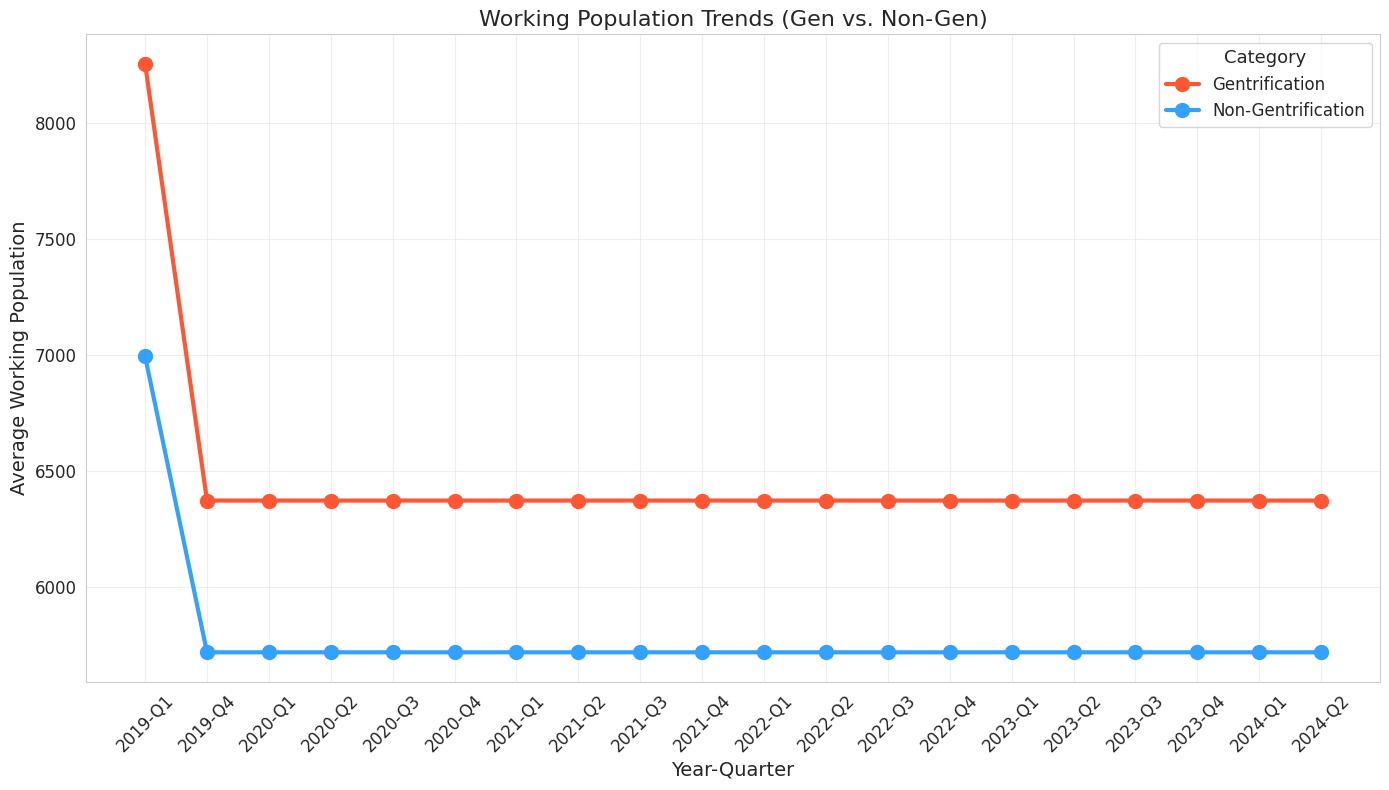

In [69]:
# 데이터 타입 변환
df_bg_dong_working_total['총_직장인구_수'] = pd.to_numeric(df_bg_dong_working_total['총_직장인구_수'], errors='coerce')

# 연도_분기 컬럼 변환
df_bg_dong_working_total['연도_분기_라벨'] = df_bg_dong_working_total['연도_분기'].astype(str).apply(lambda x: f"{x[:4]}-Q{x[4:]}" if len(x) >= 5 else x)

# 시계열 데이터
time_series_data = df_bg_dong_working_total.groupby(['연도_분기', '연도_분기_라벨', '구분'])['총_직장인구_수'].mean().reset_index()
time_series_data = time_series_data.sort_values('연도_분기')

# 젠트리피케이션, 비젠트리피케이션 데이터 분리
gen_data = time_series_data[time_series_data['구분'] == '젠트리피케이션']
non_gen_data = time_series_data[time_series_data['구분'] == '비젠트리피케이션']

plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")

# 선 그래프 그리기
line1, = plt.plot(gen_data['연도_분기_라벨'], gen_data['총_직장인구_수'], 'o-', color='#FF5733', linewidth=3, markersize=10)
line2, = plt.plot(non_gen_data['연도_분기_라벨'], non_gen_data['총_직장인구_수'], 'o-', color='#33A1FF', linewidth=3, markersize=10)

# 그래프 스타일 설정
plt.title('Working Population Trends (Gen vs. Non-Gen)', fontsize=16)
plt.xlabel('Year-Quarter', fontsize=14)
plt.ylabel('Average Working Population', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend([line1, line2], ['Gentrification', 'Non-Gentrification'], title='Category', fontsize=12, title_fontsize=13)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

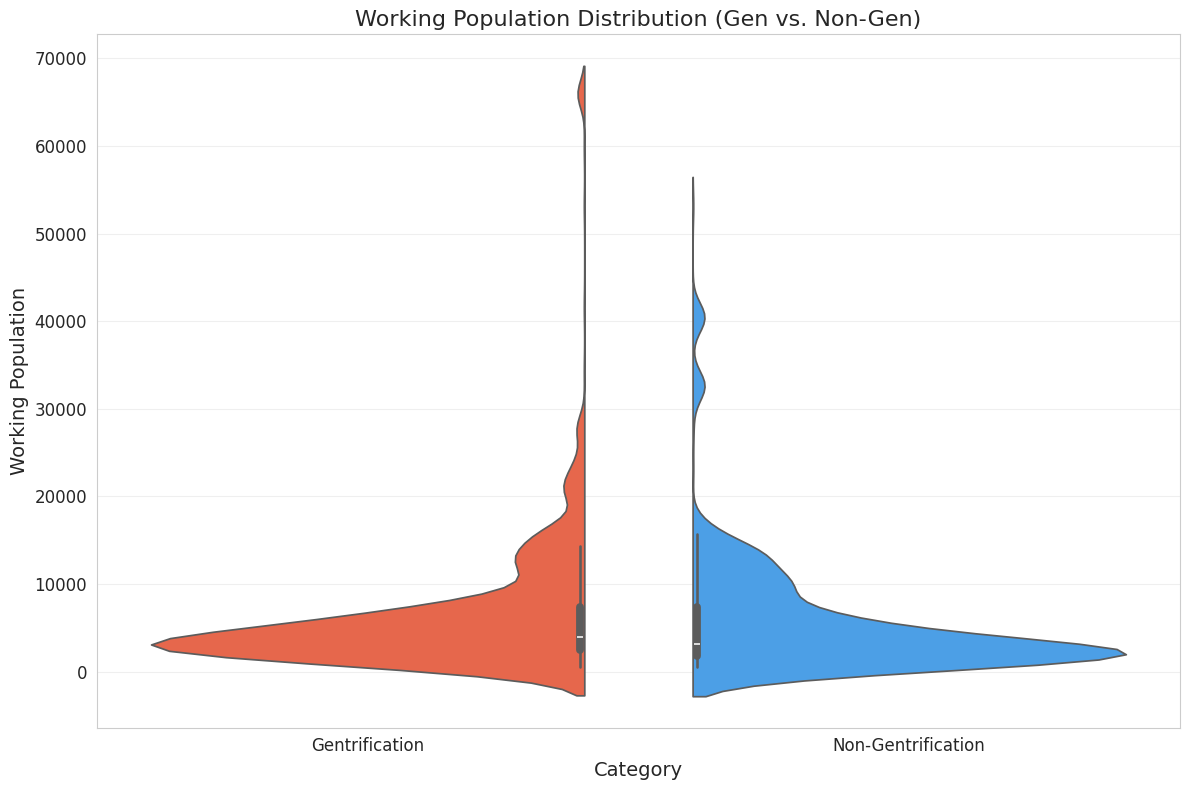

In [70]:
# 바이올린 플롯
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

# 분할된 바이올린 플롯 데이터 준비
violin_data = df_bg_dong_working_total.copy()
violin_data['Category'] = violin_data['구분'].map({
    '젠트리피케이션': 'Gentrification',
    '비젠트리피케이션': 'Non-Gentrification'
})

# 바이올린 플롯 그리기
ax = sns.violinplot(
    x='Category',
    y='총_직장인구_수',
    hue='Category',
    data=violin_data,
    palette={'Gentrification': '#FF5733', 'Non-Gentrification': '#33A1FF'},
    inner='box',
    density_norm='width',
    split=True
)

plt.title('Working Population Distribution (Gen vs. Non-Gen)', fontsize=16)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Working Population', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

### 상권배후지 직장인구 (성별)

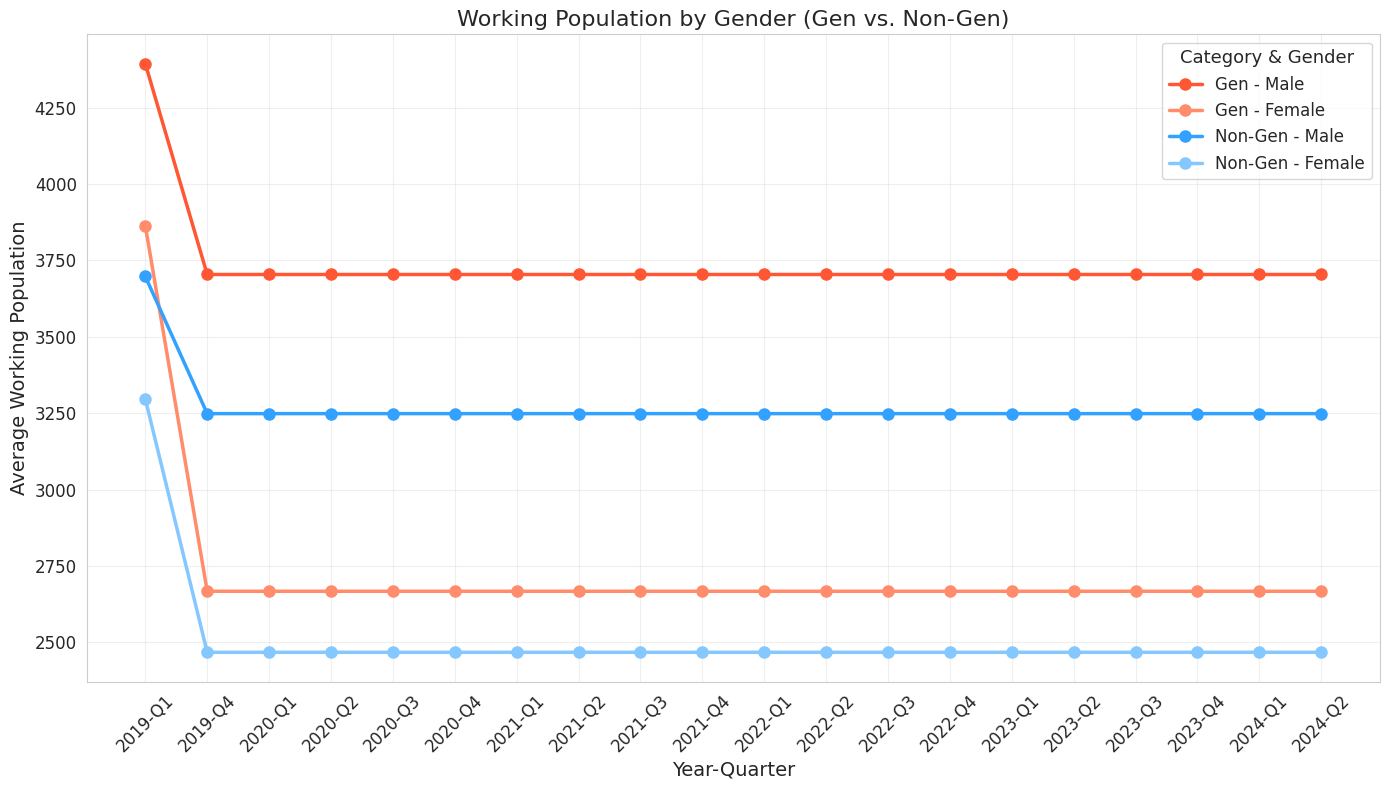

In [71]:
# 데이터 타입 변환
df_bg_dong_working_sex['남성_직장인구_수'] = pd.to_numeric(df_bg_dong_working_sex['남성_직장인구_수'], errors='coerce')
df_bg_dong_working_sex['여성_직장인구_수'] = pd.to_numeric(df_bg_dong_working_sex['여성_직장인구_수'], errors='coerce')

# 연도_분기 컬럼 변환
df_bg_dong_working_sex['연도_분기_라벨'] = df_bg_dong_working_sex['연도_분기'].astype(str).apply(lambda x: f"{x[:4]}-Q{x[4:]}" if len(x) >= 5 else x)

# 시계열 데이터
gender_time_series = df_bg_dong_working_sex.groupby(['연도_분기', '연도_분기_라벨', '구분']).agg({'남성_직장인구_수': 'mean', '여성_직장인구_수': 'mean'}).reset_index()
gender_time_series = gender_time_series.sort_values('연도_분기')

# 젠트리피케이션, 비젠트리피케이션 데이터 분리
gen_gender_data = gender_time_series[gender_time_series['구분'] == '젠트리피케이션']
non_gen_gender_data = gender_time_series[gender_time_series['구분'] == '비젠트리피케이션']

plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")

# 젠트리피케이션 지역의 남성/여성 직장인구
plt.plot(gen_gender_data['연도_분기_라벨'], gen_gender_data['남성_직장인구_수'], 'o-', color='#FF5733', linewidth=2.5, markersize=8, label='Gen - Male')
plt.plot(gen_gender_data['연도_분기_라벨'], gen_gender_data['여성_직장인구_수'], 'o-', color='#FF8C6B', linewidth=2.5, markersize=8, label='Gen - Female')

# 비젠트리피케이션 지역의 남성/여성 직장인구
plt.plot(non_gen_gender_data['연도_분기_라벨'], non_gen_gender_data['남성_직장인구_수'], 'o-', color='#33A1FF', linewidth=2.5, markersize=8, label='Non-Gen - Male')
plt.plot(non_gen_gender_data['연도_분기_라벨'], non_gen_gender_data['여성_직장인구_수'], 'o-', color='#85C7FF', linewidth=2.5, markersize=8, label='Non-Gen - Female')

# 그래프 스타일 설정
plt.title('Working Population by Gender (Gen vs. Non-Gen)', fontsize=16)
plt.xlabel('Year-Quarter', fontsize=14)
plt.ylabel('Average Working Population', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Category & Gender', fontsize=12, title_fontsize=13)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

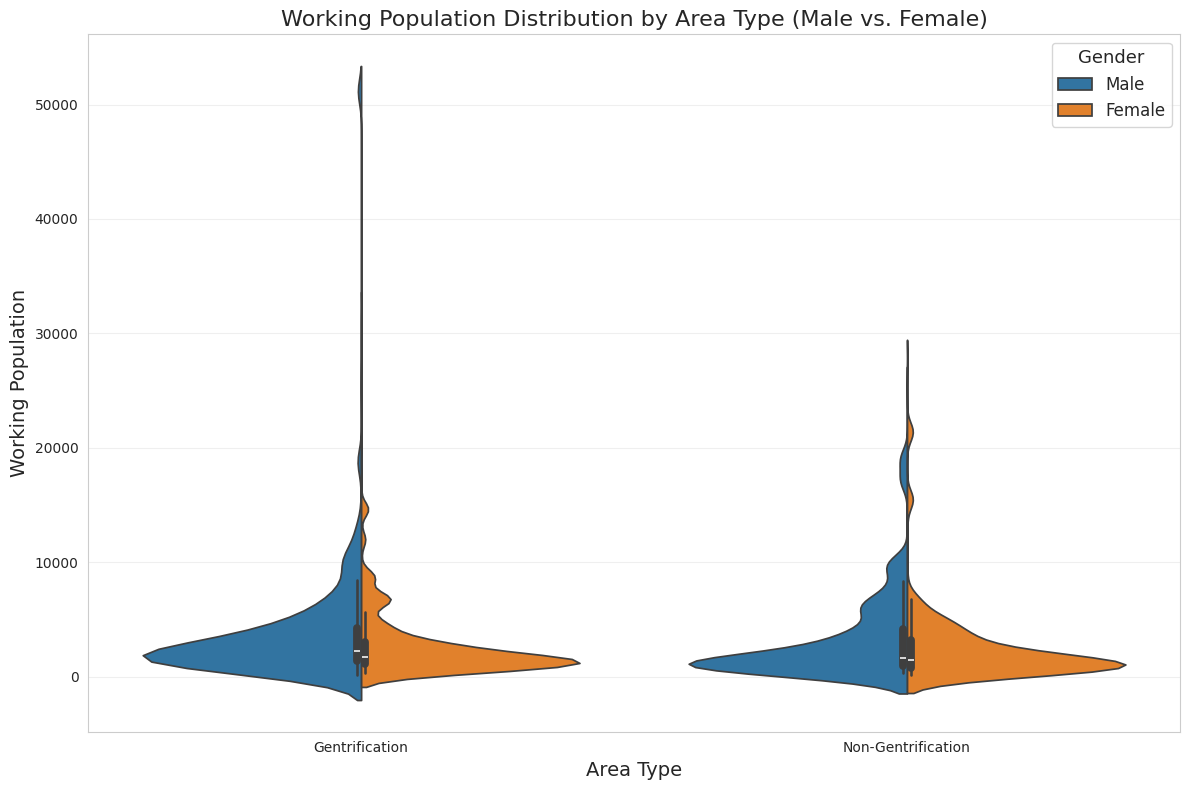

In [72]:
# 데이터 멜팅
violin_sex_data = pd.melt(
    df_bg_dong_working_sex,
    id_vars=['구분', '상권배후지', '연도_분기'],
    value_vars=['남성_직장인구_수', '여성_직장인구_수'],
    var_name='성별',
    value_name='직장인구_수'
)

# 성별 레이블 변환
violin_sex_data['Gender'] = violin_sex_data['성별'].map({
    '남성_직장인구_수': 'Male',
    '여성_직장인구_수': 'Female'
})

# 구분 레이블 변환
violin_sex_data['Category'] = violin_sex_data['구분'].map({
    '젠트리피케이션': 'Gentrification',
    '비젠트리피케이션': 'Non-Gentrification'
})

plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

# X축이 Category(젠/비젠), hue가 Gender(남/여)인 분할된 바이올린 플롯 생성
ax = sns.violinplot(
    x='Category',  # X축을 젠/비젠으로 설정
    y='직장인구_수',
    hue='Gender',  # 남/여를 hue로 설정하여 분할
    data=violin_sex_data,
    palette={'Male': '#1F77B4', 'Female': '#FF7F0E'},
    split=True,    # 분할 활성화
    inner='box',
    density_norm='width'
)

plt.title('Working Population Distribution by Area Type (Male vs. Female)', fontsize=16)
plt.xlabel('Area Type', fontsize=14)
plt.ylabel('Working Population', fontsize=14)
plt.legend(title='Gender', fontsize=12, title_fontsize=13)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

### 상권배후지 직장인구 (연령대)

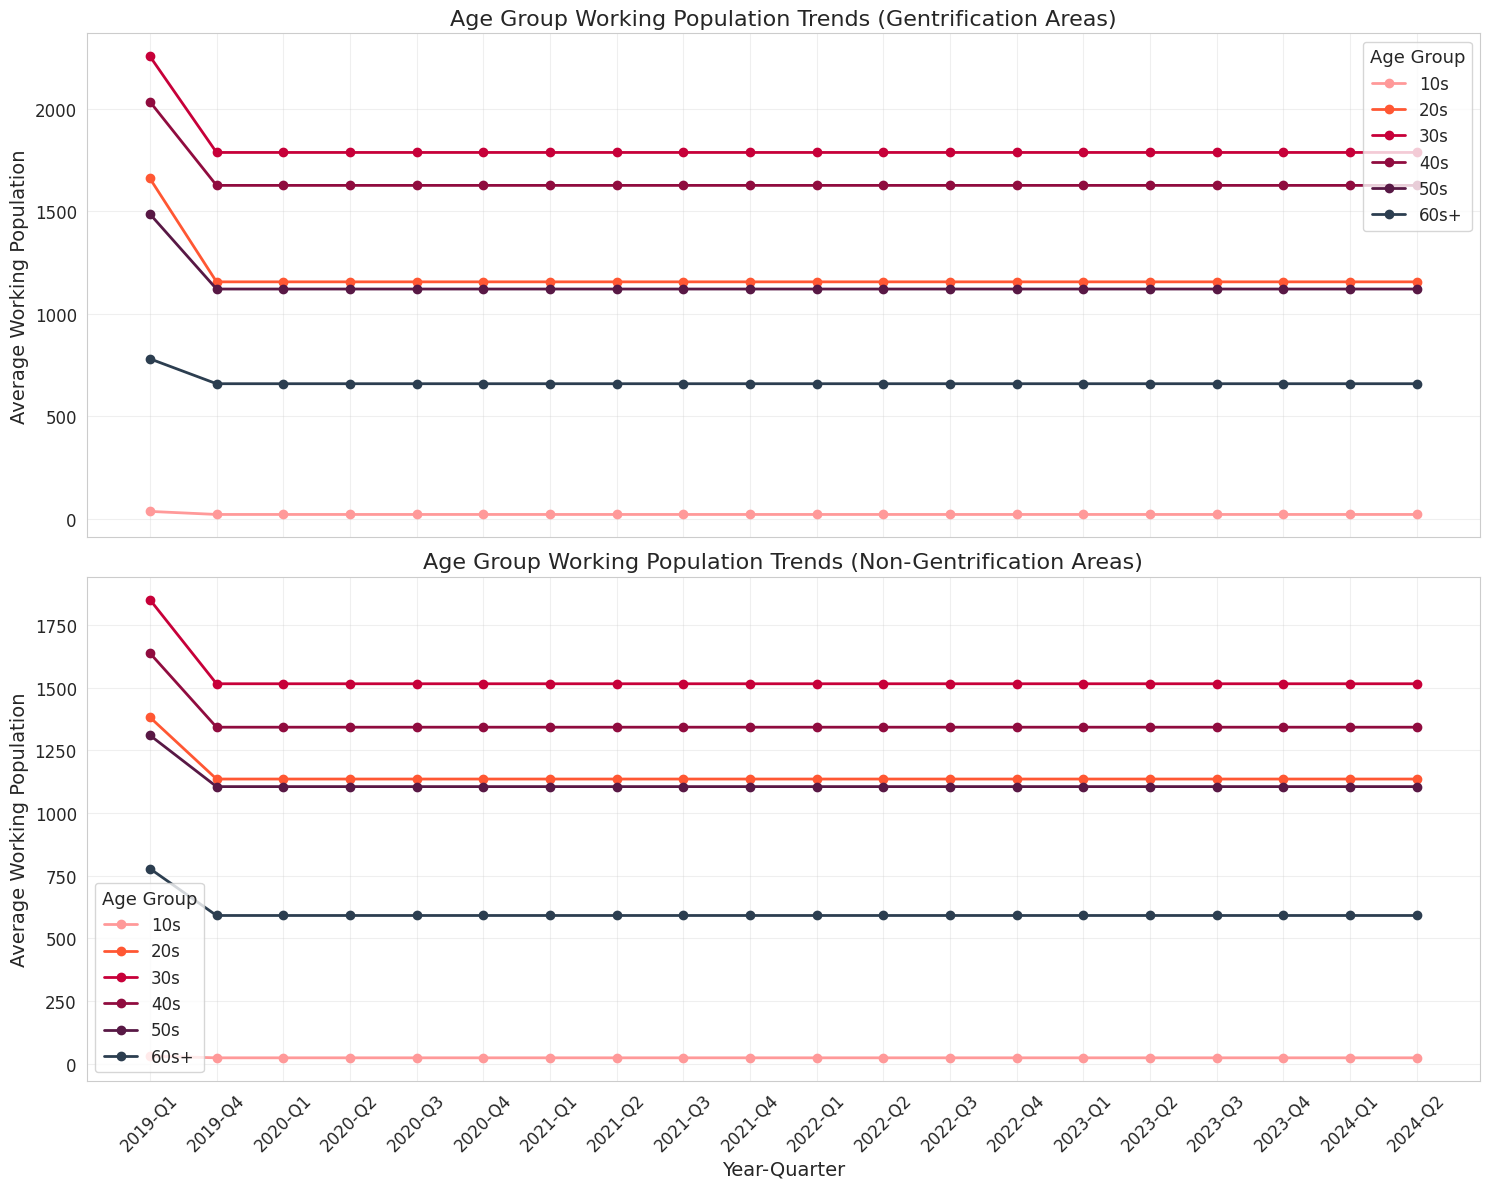

In [73]:
# 연령대 레이블 정의
age_labels = {
    "연령대_10_직장인구_수": "10s",
    "연령대_20_직장인구_수": "20s",
    "연령대_30_직장인구_수": "30s",
    "연령대_40_직장인구_수": "40s",
    "연령대_50_직장인구_수": "50s",
    "연령대_60_이상_직장인구_수": "60s+"
}

# 데이터 타입 변환
age_columns = [
    "연령대_10_직장인구_수", "연령대_20_직장인구_수", "연령대_30_직장인구_수",
    "연령대_40_직장인구_수", "연령대_50_직장인구_수", "연령대_60_이상_직장인구_수"
]

for col in age_columns:
  df_bg_dong_working_age[col] = pd.to_numeric(df_bg_dong_working_age[col], errors='coerce')

# 연도_분기 컬럼 변환
df_bg_dong_working_age['연도_분기_라벨'] = df_bg_dong_working_age['연도_분기'].astype(str).apply(
    lambda x: f"{x[:4]}-Q{x[4:]}" if len(x) >= 5 else x
)

# 3.1 시계열 라인 플롯
# 연령대별 시계열 데이터 준비
age_time_series = df_bg_dong_working_age.groupby(['연도_분기', '연도_분기_라벨', '구분']).agg({
    col: 'mean' for col in age_columns
}).reset_index()

age_time_series = age_time_series.sort_values('연도_분기')

# 젠트리피케이션, 비젠트리피케이션 데이터 분리
gen_age_data = age_time_series[age_time_series['구분'] == '젠트리피케이션']
non_gen_age_data = age_time_series[age_time_series['구분'] == '비젠트리피케이션']

# 연령대별 색상 지정
age_colors = {
    "연령대_10_직장인구_수": "#FF9999",
    "연령대_20_직장인구_수": "#FF5733",
    "연령대_30_직장인구_수": "#C70039",
    "연령대_40_직장인구_수": "#900C3F",
    "연령대_50_직장인구_수": "#581845",
    "연령대_60_이상_직장인구_수": "#2C3E50"
}

# 두 개의 서브플롯 생성
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), sharex=True)

# 젠트리피케이션 지역의 연령대별 직장인구 시계열 그래프
for col in age_columns:
    ax1.plot(gen_age_data['연도_분기_라벨'], gen_age_data[col], 'o-', color=age_colors[col], linewidth=2, markersize=6, label=age_labels[col])

ax1.set_title('Age Group Working Population Trends (Gentrification Areas)', fontsize=16)
ax1.set_ylabel('Average Working Population', fontsize=14)
ax1.tick_params(axis='y', labelsize=12)
ax1.grid(True, alpha=0.3)
ax1.legend(title='Age Group', fontsize=12, title_fontsize=13)

# 비젠트리피케이션 지역의 연령대별 직장인구 시계열 그래프
for col in age_columns:
    ax2.plot(non_gen_age_data['연도_분기_라벨'], non_gen_age_data[col], 'o-', color=age_colors[col], linewidth=2, markersize=6, label=age_labels[col])

ax2.set_title('Age Group Working Population Trends (Non-Gentrification Areas)', fontsize=16)
ax2.set_xlabel('Year-Quarter', fontsize=14)
ax2.set_ylabel('Average Working Population', fontsize=14)
ax2.tick_params(axis='x', rotation=45, labelsize=12)
ax2.tick_params(axis='y', labelsize=12)
ax2.grid(True, alpha=0.3)
ax2.legend(title='Age Group', fontsize=12, title_fontsize=13)

plt.tight_layout()
plt.show()

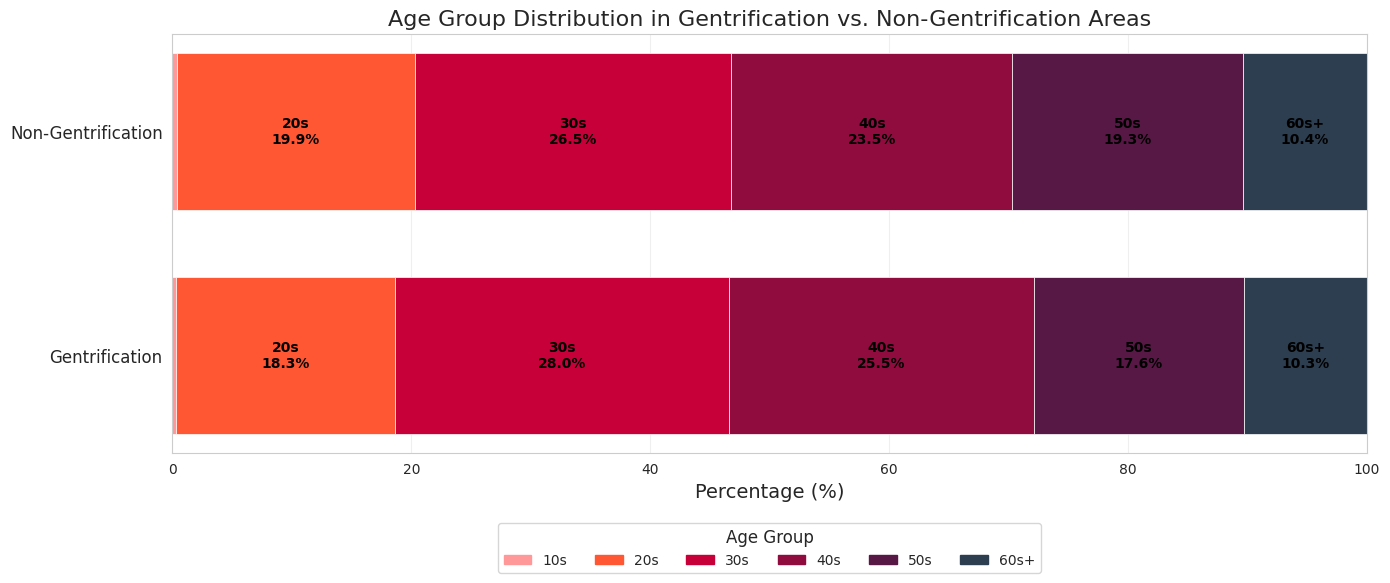

In [74]:
# 젠트리피케이션과 비젠트리피케이션 지역별로 연령대 비율 계산
# 먼저 각 구분별, 연령대별 평균 직장인구 계산
age_means = df_bg_dong_working_age.groupby('구분')[age_columns].mean().reset_index()

# 각 행(구분)별로 총 합계 계산하여 비율 구하기
for idx, row in age_means.iterrows():
    total = row[age_columns].sum()
    for col in age_columns:
        age_means.loc[idx, f'{col}_비율'] = row[col] / total * 100

# 데이터 재구성 (멜팅)
ratio_columns = [f'{col}_비율' for col in age_columns]
age_ratio_melted = pd.melt(
    age_means,
    id_vars=['구분'],
    value_vars=ratio_columns,
    var_name='연령대_비율',
    value_name='비율'
)

# 연령대 레이블 변환
age_ratio_melted['Age_Group'] = age_ratio_melted['연령대_비율'].apply(lambda x: age_labels[x.replace('_비율', '')])
age_ratio_melted['Category'] = age_ratio_melted['구분'].map({
    '젠트리피케이션': 'Gentrification',
    '비젠트리피케이션': 'Non-Gentrification'
})

# 연령대 순서 정의
age_order = ['10s', '20s', '30s', '40s', '50s', '60s+']

# 연령대 순서 컬럼 추가
age_ratio_melted['Age_Order'] = age_ratio_melted['Age_Group'].map({age: i for i, age in enumerate(age_order)})
age_ratio_melted = age_ratio_melted.sort_values(['구분', 'Age_Order'])

# 색상 팔레트 정의 (연령대별)
colors = ['#FF9999', '#FF5733', '#C70039', '#900C3F', '#581845', '#2C3E50']
palette = {age: color for age, color in zip(age_order, colors)}

# 가로 누적 막대 그래프 그리기
plt.figure(figsize=(14, 6))
sns.set_style("whitegrid")

# 젠트리피케이션과 비젠트리피케이션을 구분하여 그래프 생성
for i, category in enumerate(['Gentrification', 'Non-Gentrification']):
    # 해당 카테고리 데이터만 필터링
    category_data = age_ratio_melted[age_ratio_melted['Category'] == category]

    # 위치 설정 (젠트리피케이션: 0, 비젠트리피케이션: 1)
    y_pos = i

    # 누적 시작 위치
    left = 0

    # 각 연령대별로 막대 그리기
    for age in age_order:
        # 해당 연령대 데이터 찾기
        age_data = category_data[category_data['Age_Group'] == age]
        if not age_data.empty:
            width = age_data['비율'].values[0]
            plt.barh(y_pos, width, left=left, height=0.7, color=palette[age], edgecolor='white', linewidth=0.5)

            # 비율이 5% 이상인 경우에만 레이블 표시
            if width >= 5:
                # 텍스트 위치 계산 (막대 중앙)
                text_x = left + width / 2
                plt.text(text_x, y_pos, f"{age}\n{width:.1f}%", ha='center', va='center', color='black', fontsize=10, fontweight='bold')

            # 다음 막대의 시작 위치 업데이트
            left += width

# Y축 설정
plt.yticks([0, 1], ['Gentrification', 'Non-Gentrification'], fontsize=12)
plt.xlabel('Percentage (%)', fontsize=14)
plt.xlim(0, 100)
plt.title('Age Group Distribution in Gentrification vs. Non-Gentrification Areas', fontsize=16)
plt.grid(True, alpha=0.3, axis='x')

# 범례 추가
handles = [plt.Rectangle((0, 0), 1, 1, color=palette[age]) for age in age_order]
plt.legend(handles, age_order, title='Age Group', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=6, fontsize=10, title_fontsize=12)

plt.tight_layout()
plt.show()